In this script, we utilize **LDA topic modeling** to uncover topics from text and distill insights to solve the questions we are interested in. 

## Load functions from utils.py

In [308]:
# %load utils.py
"""
Created on Tue Nov  5 20:58:27 2019

@author: Hong.Wen.Tai
"""

import pandas as pd
import numpy as np
import re # We clean text using regex
import csv # To read the csv
from collections import defaultdict # For accumlating values
from nltk.corpus import stopwords # To remove stopwords
from gensim import corpora # To create corpus and dictionary for the LDA model
from gensim.models import LdaModel # To use the LDA model
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models import CoherenceModel
import spacy
from spacy import displacy
import en_core_web_sm
from datetime import datetime
from gensim.models.phrases import Phrases, Phraser
import random
from spacy.util import minibatch, compounding
from spacy.matcher import Matcher
import seaborn as sns
import matplotlib.pyplot as plt

#Function to print clean string for visualization
def print_clean(string):
    print ('"{}"'.format(string))

#Functions for Sentiment Analysis
def sentSentiment(sentence):
    sentence_list = tokenize.sent_tokenize(sentence)
    paragraphSentiments = 0.0
    for sentence in sentence_list:
        vs = analyser.polarity_scores(sentence)
        print("{:-<69} {}".format(sentence, str(vs["compound"])))
        paragraphSentiments += vs["compound"]
    finalSentiment = round(paragraphSentiments / len(sentence_list), 4)
    print("AVERAGE SENTIMENT FOR PARAGRAPH: \t" + str(finalSentiment))
    print("----------------------------------------------------")
    return finalSentiment

#Functions for Entity Extraction
def count_profben(content_series):
    benseries = " ".join(content_series).lower()               #join Series into one string, convert to lowercase
    benlist = re.findall("prof.?leong|prof.?ben",benseries)    #include .? to identify cases such as "profben" or "prof.ben"
    return len(benlist)

def extract_mods_courses(content_series):
    regstring = " ".join(content_series).lower()         #join Series into one string, convert to lowercase (since CS1010 is the same as cs1010)
    reglist = re.findall("(([a-z|A-Z]{2,3})\d{4}[a-z|A-Z]?)",regstring)  #Use [a-z|A-Z] since \w will extract numbers too. Add brackets to extract group (module) and sub-group (course)
    modulelist, courselist = zip(*reglist)               #Unpack tuple of pairs into two tuples
    moduleseries = pd.Series(modulelist)
    courseseries = pd.Series(courselist)
    return moduleseries, courseseries

#Functions for Topic Modeling
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  
        
def convert_bigram(contentseries):                #takes in a Series, fits bigram model and processing pipeline on it, returns list ready for topic modeling
    newdoc2= contentseries.tolist()
    sentence_stream_newdoc2 = [doc.split(".") for doc in newdoc2]
    
    a = []
    for doc in sentence_stream_newdoc2:
        for sentence in doc:
            a.append(sentence.split(" "))
    
    phrases_newdoc2 = Phrases(a, min_count=3, threshold=69) 
    bigram_newdoc2 = Phraser(phrases_newdoc2)
    
    data_words = list(sent_to_words(contentseries))
    data_words2 = [bigram_newdoc2[i] for i in data_words]
    doc_list =  [nlp2(" ".join(doc)) for doc in data_words2]
    return doc_list
    
def model_topic(doc_list):   #takes in list, return ldamodel and dataframe of top 10 topics
    words = corpora.Dictionary(doc_list)
    corpus = [words.doc2bow(doc) for doc in doc_list]
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=words, num_topics=5, random_state=42, 
                                            update_every=1, chunksize=100, passes=50, alpha='auto', 
                                            per_word_topics=True, dtype=np.float64)
    
    topic_dict = {};
    for i in range(5):
        topic_list = lda_model.show_topic(i, topn = 20)
        topic_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in topic_list]
    return lda_model, corpus, pd.DataFrame(topic_dict)


def assign_topic(original_dataframe, ldamodel, corpus):  #assign topic to each row in original dataframe
    original_dataframe["topic"] = 0
    original_dataframe["topic_probability"] = 0

    #pass corpus into lda_model to get probabilities of each doc belonging to each topic
    for i, row in enumerate(ldamodel[corpus]):
      # print (i)
      # print (row[0])
        b = 0
        for j in row[0]:        
            if j[1] > b:
                a = j[0]+1       #assign topic to a (+1 since number starts from 0), probability to b. If current probability > previous probability, overwrite b.
                b = j[1]     

        print(a,b)   
        original_dataframe["topic"].iloc[i]=a
        original_dataframe["topic_probability"].iloc[i]= b
    
    return original_dataframe

#Functions for spacy preprocessing pipeline:
def lemmatizer(doc, allowed_postags=['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV', 'NUM','X']):
    # This takes in a doc of tokens from the NER and lemmatizes them. 
    # Pronouns (like "I" and "you" get lemmatized to '-PRON-', so I'm removing those.
    doc = [token.lemma_ for token in doc if ((token.pos_ in allowed_postags) and (token.lemma_ != '-PRON-'))]
    doc = u' '.join(doc)
    return nlp2.make_doc(doc)

def remove_stopwords(doc):
    # This will remove stopwords and punctuation.
    # Use token.text to return strings, which we'll need for Gensim.
    doc = [token.text for token in doc if token.is_stop != True]
           #and token.is_punct != True]
    return doc

nlp2 = spacy.load(r"C:\Users\Hong.Wen.Tai\Downloads\nuswhispers_text_analysis\models")    
nlp2.add_pipe(lemmatizer,name='lemmatizer',after='ner')                #add back custom components to model
nlp2.add_pipe(remove_stopwords, name="stopwords", after = "lemmatizer")

## Reading and Slicing Data 

This follows the procedures in "Exploratory Analysis & Experimentation.ipynb"

In [203]:
data = pd.read_csv(r"C:\Users\Hong.Wen.Tai\Downloads\nuswhispers_text_analysis\data\nuswhispers_cleaned_complete.csv")

In [204]:
#Convert created_at variable to datetime object, then extract year

data["created_at"].iloc[0:20000] = pd.to_datetime(data.created_at.iloc[0:20000],format='%Y-%m-%d %H:%M:%S')
data["created_at"].iloc[20000:] = pd.to_datetime(data.created_at.iloc[20000:],format='%d-%m-%y %H:%M')
data["created_at"] = pd.to_datetime(data.created_at)

data["year"] = data["created_at"].dt.year

C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [205]:
#do different cuts by year
data_2015 = data.loc[data["year"]==2015]
data_2016 = data.loc[data["year"]==2016]
data_2017 = data.loc[data["year"]==2017]
data_2018 = data.loc[data["year"]==2018]
data_2019 = data.loc[data["year"]==2019]

In [206]:
#do different cuts by year and sch term
data_schterm = data.copy()
data_schterm.set_index('created_at', inplace = True)

data_2015_earlysem = data_schterm.loc['2015-01-12' : '2015-05-09']  #2015 SEM 2 - 12 Jan 2015 to 9 May 2015 
data_2015_latesem = data_schterm.loc['2015-08-03' : '2015-12-05']   #2015 SEM 1 - 3 Aug 2015 to 5 Dec 2015
data_2015_offsem = pd.concat([data_schterm.loc['2015-05-10' : '2015-08-02'], data_schterm.loc['2015-12-06' : '2015-12-31']],axis = 0, sort=False)

data_2016_earlysem = data_schterm.loc['2016-01-11' : '2016-05-07']  #2016: SEM 2 - 11 Jan 2016 to 7 May 2016  
data_2016_latesem = data_schterm.loc['2016-08-01' : '2016-12-03']   #2016: SEM 1 - 1 Aug 2016 to 3 Dec 2016
offsem1_2016 = data_schterm.loc['2016-01-01' : '2016-01-10']
offsem2_2016 = data_schterm.loc['2016-05-08' : '2016-07-31']
offsem3_2016 = data_schterm.loc['2016-12-04' : '2016-12-31']
data_2016_offsem = pd.concat([offsem1_2016, offsem2_2016, offsem3_2016],axis = 0, sort=False)

data_2017_earlysem = data_schterm.loc['2017-01-09' : '2017-05-06']  #2017: SEM 2 - 9 Jan 2017 to 6 May 2017
data_2017_latesem = data_schterm.loc['2017-08-07' : '2017-12-09']   #2017: SEM 1 - 7 Aug 2017 to 9 Dec 2017
offsem1_2017 = data_schterm.loc['2017-01-01' : '2017-01-08']
offsem2_2017 = data_schterm.loc['2017-05-07' : '2017-08-06']
offsem3_2017 = data_schterm.loc['2017-12-10' : '2017-12-31']
data_2017_offsem = pd.concat([offsem1_2017, offsem2_2017, offsem3_2017],axis = 0, sort=False)

data_2018_earlysem = data_schterm.loc['2018-01-15' : '2018-05-12']  #2018: SEM 2 - 15 Jan 2018 to 12 May 2018
data_2018_latesem = data_schterm.loc['2018-08-06' : '2018-12-08']   #2018: SEM 1 - 6 Aug 2018 to 8 Dec 2018
offsem1_2018 = data_schterm.loc['2018-01-01' : '2018-01-14']
offsem2_2018 = data_schterm.loc['2018-05-13' : '2018-08-05']
offsem3_2018 = data_schterm.loc['2018-12-09' : '2018-12-31']
data_2018_offsem = pd.concat([offsem1_2018, offsem2_2018, offsem3_2018],axis = 0, sort=False)

data_2019_earlysem = data_schterm.loc['2019-01-14' : '2019-05-11']  #2019: SEM 2 - 14 Jan 2019 to 11 May 2019
data_2019_latesem = data_schterm.loc['2019-08-05' : '2019-12-07']   #2019: SEM 1 - 5 Aug 2019 to 7 Dec 2019
offsem1_2019 = data_schterm.loc['2019-01-01' : '2019-01-13']
offsem2_2019 = data_schterm.loc['2019-05-12' : '2019-08-04']
offsem3_2019 = data_schterm.loc['2019-12-08' : '2019-12-31']
data_2019_offsem = pd.concat([offsem1_2019, offsem2_2019, offsem3_2019],axis = 0, sort=False)

data_all_earlysem = pd.concat([data_2015_earlysem, data_2016_earlysem, data_2017_earlysem, data_2018_earlysem, data_2019_earlysem],axis = 0, sort=False)
data_all_latesem = pd.concat([data_2015_latesem, data_2016_latesem, data_2017_latesem, data_2018_latesem, data_2019_latesem],axis = 0, sort=False)
data_all_offsem = pd.concat([data_2015_offsem, data_2016_offsem, data_2017_offsem, data_2018_offsem, data_2019_offsem],axis = 0, sort=False)

## Topic Modeling

In [207]:
doc_2019 = data_2019["content"]
bigram_2019 = convert_bigram(doc_2019)
ldamodel_2019, corpus_2019, toptopics_2019 = model_topic(bigram_2019)

In [208]:
doc_2018 = data_2018["content"]
bigram_2018 = convert_bigram(doc_2018)
ldamodel_2018, corpus_2018, toptopics_2018 = model_topic(bigram_2018)

In [209]:
doc_2017 = data_2017["content"]
bigram_2017 = convert_bigram(doc_2017)
ldamodel_2017, corpus_2017, toptopics_2017 = model_topic(bigram_2017)

In [210]:
doc_2016 = data_2016["content"]
bigram_2016 = convert_bigram(doc_2016)
ldamodel_2016, corpus_2016, toptopics_2016 = model_topic(bigram_2016)

In [211]:
doc_2015 = data_2015["content"]
bigram_2015 = convert_bigram(doc_2015)
ldamodel_2015, corpus_2015, toptopics_2015 = model_topic(bigram_2015)

### Topics for 2019

In [212]:
toptopics_2019

Topic # 01    Topic # 02 Topic # 03   Topic # 04  Topic # 05
0         work          know    student          pay      people
1         year           don     module         food        post
2         good          want        nus       parent         use
3       people          feel         cs        money         man
4          job        friend        mod          buy     comment
5        study           guy      thank          eat       woman
6          sem         think   semester      chinese        play
7       school          time    lecture         fass        read
8     graduate          girl     senior  singaporean       watch
9       course          find        cap    situation          op
10        life         thing      grade        local  nuswhisper
11        need           try       prof         seat       speak
12  experience          tell      learn          bus      result
13      future           ask   question      culture         kid
14        look          good       math         room        game
15      advice           day      minor         live       party
16       apply          love      class        utown         ppl
17       think          year      email       family       child
18       major            ve  interview        level      create
19        hard  relationship        mcs          use         app

In [213]:
data_2019_copy = data_2019.copy()
data_2019_topic = assign_topic(data_2019_copy, ldamodel_2019, corpus_2019)

2 0.7063259411594328
2 0.36319803953344676
2 0.6815932456084733
2 0.5802264809002924
2 0.5294323778327613
2 0.5472772432195767
2 0.7721005739446831
2 0.37176132122977995
2 0.6278864061943904
3 0.3830398396132981
1 0.37741658095080355
4 0.2816562918266541
2 0.5482062571256148
2 0.8494747393795118
2 0.7113799560951987
2 0.3883703440210561
3 0.3816945346148642
2 0.4562881331565606
2 0.9159733731126684
2 0.6383719163999784
2 0.4676948997181308
2 0.6477712668791994
5 0.35463630166800053
2 0.6340955953354507
2 0.554453816101656
2 0.4487996392677007
2 0.5667776055684296
2 0.4043591189507291
2 0.6835599864250836
2 0.8338735508637458
1 0.3390228008652788
2 0.8078307679937408
1 0.41566681320731846
5 0.32668969517294405
2 0.70604685121336
2 0.4797498902602598
2 0.45694792420076474
2 0.7475372722590784
2 0.48333934451262056
2 0.4305123654175181
2 0.5969373078109735
2 0.49824769991578716
2 0.4092219036712098
2 0.6008374860533511
2 0.6308084289952253
2 0.3318496888598622
2 0.8573632048630697
5 0.511

2 0.6855546252697398
2 0.43672398345158325
2 0.4738893455201785
2 0.5624949058962073
2 0.6383679841582042
3 0.3239079627019048
2 0.6256604071617968
2 0.6843403797355164
2 0.6921063407096508
3 0.4119863391075767
2 0.7113636733651891
2 0.6326511473070281
2 0.5345400976247923
2 0.727395685495351
2 0.5130460498423014
3 0.4058907230643233
2 0.5368693879594094
2 0.4741361423904849
2 0.7644448452367514
2 0.6839296514130567
2 0.47217910453348516
2 0.4716032740767101
2 0.4236976542017069
2 0.35131555133667974
2 0.5443106125228275
2 0.755857702110608
2 0.5908507298577499
1 0.4023777641334327
2 0.6252857119459799
2 0.4855511434399876
2 0.6784592038035432
2 0.2935633585248893
2 0.5099729900692721
2 0.5959321110656306
2 0.617702775825444
2 0.6680092264044417
2 0.466662931907118
5 0.3423165112090488
2 0.7897355879791199
5 0.2829516035323114
2 0.378295323146559
2 0.3450199453334112
2 0.6660455533783539
2 0.5578023225117708
2 0.4847427885018549
2 0.6722124740753982
2 0.7916396401957513
1 0.39838840824

2 0.6337279609661195
2 0.42023789255732796
4 0.3452053521769779
3 0.39153068338486396
2 0.7043465774682683
3 0.5986202144894033
2 0.6909471982735702
3 0.5138230837914904
1 0.6708415007472438
3 0.4686211627503143
3 0.48965749818738374
3 0.4173136807971468
2 0.3614189742984684
2 0.35182937042244183
1 0.4379076910211818
1 0.47286462683745156
2 0.3429893833849028
2 0.4371242258112944
3 0.5501557722724073
3 0.28526911585151454
2 0.6895249187062237
1 0.3189703113177117
2 0.32970429600846146
3 0.307878996161171
2 0.454035252955228
1 0.4470915131233244
2 0.413959402176226
2 0.30095466231975093
2 0.5432315053452231
1 0.5065748865009422
2 0.7231708840944636
3 0.42296605204488924
2 0.5414903316406507
2 0.5518243423813797
2 0.48283401864138376
3 0.5626603923846724
2 0.5298720610540287
1 0.5445591103170005
2 0.5438845172732477
2 0.7235790292243054
1 0.41138866265625695
2 0.4287148089919009
2 0.3272531412069003
2 0.4496674078235277
3 0.49516891193395735
2 0.6309693629364083
3 0.43558810537666587
2 0

2 0.39334301919858417
2 0.7451521853367622
2 0.5209554812515685
1 0.34439475949057774
3 0.441623802816623
3 0.45316840724750174
1 0.35870327452812645
1 0.46099128010889595
1 0.5163140331239894
1 0.3388807454930905
4 0.35775120463537224
2 0.5526767975513972
2 0.4364956521638106
3 0.4154687353989204
1 0.3583878487734775
2 0.7401675682482652
2 0.6484547067867685
1 0.32970125934779865
2 0.3883703440210561
3 0.32970252921494847
1 0.6332527858302734
1 0.43277614504353834
2 0.3755835128436942
2 0.5856299330555635
2 0.5145288126029288
2 0.6814860437772846
4 0.31887631729520943
2 0.5673630899318494
3 0.6084617529603491
2 0.33186982859380537
1 0.41664698097094055
2 0.7600233301634485
2 0.42103191136734996
1 0.433335341110587
3 0.5455347081475515
1 0.6319345973500089
2 0.3357244987875922
1 0.4808027565865969
2 0.5381815386231009
2 0.6874011882539178
1 0.4644361893375499
1 0.3497187244555992
4 0.33809710649924196
3 0.35308562337315624
2 0.4675814034085803
3 0.2791721793530723
2 0.42281929237556237

2 0.48253543879828525
2 0.3484635659369294
2 0.768640650353717
1 0.44644741658234033
3 0.3447377542163331
1 0.37512294956898584
2 0.557055671124811
2 0.7807262834700877
2 0.45354914171455674
2 0.3917298730662398
4 0.4243017948691482
2 0.39183444079459767
2 0.5449313090360666
2 0.43574970427450516
2 0.4627900398278251
2 0.6875519981337496
2 0.7020639829839828
2 0.7753771281105348
2 0.6317131610451244
2 0.41423140372087597
2 0.6005392589858602
2 0.5484046529105604
2 0.5270684520797908
2 0.3423295265939077
2 0.3802328867008563
1 0.5983815897089658
4 0.27629366195255206
2 0.41380437484946164
5 0.4245413092392676
2 0.516478843366594
5 0.38253827430354437
2 0.5175838161506311
2 0.5720169410840543
1 0.579486491031639
2 0.3457850294293892
1 0.4136585193646256
5 0.3259312052096719
1 0.48601547417006835
3 0.47388180345149045
2 0.43254029744466066
1 0.41853504084742066
2 0.4644347328635476
2 0.5625510722992559
4 0.28245838533010237
5 0.4390445307969788
2 0.5589204564655931
2 0.5733167368570774
2 

1 0.5585110191711163
2 0.5531218748712032
2 0.5909242752683204
1 0.3547679961807424
2 0.45831781733078053
1 0.5471081556436801
2 0.4347759916556913
2 0.7316996952979168
2 0.3694999628527102
1 0.6265650791315602
3 0.37359395231764386
3 0.3977748410945841
2 0.41114652312151406
2 0.5905926295800575
1 0.37410008580167736
3 0.5047087656656603
2 0.3436800470344124
2 0.3725124528662556
1 0.5055215324319893
2 0.7454679328746266
2 0.7384538738622706
2 0.7453793247450922
1 0.5293221119374831
2 0.4419473800466737
1 0.3872764563685104
1 0.6175626355959438
3 0.5691112086699678
3 0.610029899335278
1 0.2930632702646534
2 0.40681765189002217
1 0.4158184151766104
2 0.4066303191938435
1 0.4053991658916277
2 0.6182330365445913
5 0.45113065197067914
2 0.699562779571312
1 0.501379131191856
3 0.5701771828742983
2 0.8460855173136683
3 0.3606808304054024
3 0.3709483251975389
2 0.46569629288132813
3 0.41146480902888405
2 0.5234442060850154
1 0.37968049328137726
2 0.5139369893316207
2 0.7466518848401137
2 0.454

2 0.4492919822613804
3 0.5030754477518383
2 0.33386505225252616
3 0.518380271709984
2 0.6686566189754797
2 0.3593881691642426
2 0.4211851227824281
4 0.28294374408255674
2 0.5975414078286169
2 0.6013031871274126
1 0.31087167380943165
3 0.3818308344064727
3 0.4028649306210958
2 0.5514699396489907
3 0.39740409131191967
3 0.5409384770118689
2 0.38455227055984886
3 0.46184818198039734
2 0.36908275002060514
2 0.7269639726826992
3 0.3592010778267917
2 0.30173914181173844
1 0.3381151756963611
2 0.4366039890487783
2 0.25598019317682447
2 0.37190479345755406
1 0.4698549677583328
2 0.36728390124288285
3 0.3811351072945658
2 0.7207442999421044
2 0.4625023328872495
2 0.28160810217862686
1 0.356829498690569
2 0.48106141194689744
2 0.31685821540976283
2 0.5841210341596663
2 0.594446633221467
2 0.4588592107813594
2 0.790175177153015
3 0.35274570003153805
2 0.3884004774787793
2 0.6234938719030333
3 0.5007870418679189
2 0.42608636997965205
2 0.5914507623708435
2 0.49034384911567547
2 0.6777070369836855


2 0.6614712701530405
3 0.32374151986929695
2 0.6363107048695572
2 0.7106832526060832
2 0.6459823813434323
2 0.6810395931026224
2 0.4715031566509085
1 0.29577271667322136
2 0.4691926014637039
1 0.46182594260026716
2 0.7098567605360337
1 0.5524496279815784
4 0.35259147172741534
2 0.6017729504318409
1 0.39709099610516807
1 0.4445089848387882
4 0.30824671039141577
5 0.2956056577238882
1 0.3155595234037035
1 0.3627734648111648
4 0.329075576605089
2 0.40511283789659003
2 0.4037947185822452
2 0.5333112816643222
2 0.40950066623136344
5 0.5548901638718058
2 0.5392735183000313
3 0.36615267573296295
4 0.30739028070990154
3 0.4342481039710194
2 0.7597796390493537
3 0.5131803006618205
2 0.6600717214895128
1 0.3119485296482391
3 0.4490971983046485
2 0.803144709360943
2 0.6658763129520988
2 0.3270499733400292
1 0.2857407065520061
2 0.4334535963496177
2 0.7455040652428001
2 0.6281434334236087
5 0.29042654304598153
3 0.27397532614646447
1 0.38612646497336084
1 0.4300162556579629
3 0.3724580378804602
2 

2 0.45681062910449205
2 0.5206830950113405
4 0.4158680329131418
1 0.349762773567996
3 0.35802864444546206
3 0.32135575875501493
1 0.6382830335586677
2 0.4434550839414348
1 0.485306809226102
1 0.4495984873575076
5 0.3317053361749191
2 0.4835384734623484
2 0.2852462776105458
3 0.410849348347013
2 0.3985557010180559
2 0.473266525472048
2 0.46125683022647646
2 0.742049561529147
2 0.5903702892847614
2 0.7570586302198576
4 0.3847031076229545
2 0.45515690123987457
2 0.44844845253867993
1 0.4052388024212969
2 0.5902747452926255
5 0.41345496241188234
2 0.5012106113937469
2 0.7217220592944891
2 0.4656445358837333
2 0.519928027146065
2 0.4075741760695866
2 0.43132794338783653
2 0.3189240926341251
2 0.811453701087988
2 0.4782680990298057
2 0.4881429460640943
2 0.5279664670517185
2 0.32201804794729877
2 0.34580860830051285
2 0.4307927270963812
3 0.45678908173280125
2 0.3820077790831645
2 0.46447657864655156
3 0.3764564102626634
4 0.33532399982937494
2 0.5521358623030858
2 0.7479734444927725
2 0.456

2 0.6766514763395416
1 0.603701397776767
2 0.3414776945747665
2 0.4116295214831556
2 0.405079080434476
3 0.37727858479237447
1 0.3862807171601857
1 0.33047383877868297
2 0.40999007920181946
2 0.39450359686524056
2 0.5074199629921736
2 0.5329457805473623
2 0.5078178446012315
2 0.5978053701782268
3 0.4008009532193594
2 0.6500519761788978
2 0.6627948327325154
2 0.3573054435934374
2 0.47236859308496243
2 0.4206253107089318
1 0.3256446371595893
2 0.49607153387142766
2 0.7047781715937798
1 0.3976740161291288
2 0.35357746437540816
2 0.35746409385895156
4 0.4019944440546644
2 0.5258561167802569
4 0.28788029726848074
3 0.36170267320276966
2 0.3316965299283914
2 0.6683277899008143
2 0.4573246696449089
2 0.6034164353711621
4 0.3543074559672118
2 0.68545529995117
2 0.5761599805706695
2 0.4727479096338597
2 0.6676934035819467
2 0.6655292617988083
1 0.5580189583004147
2 0.4475717767581564
1 0.40725651075789343
1 0.3860389217014269
2 0.695134818686122
2 0.48329835851229774
2 0.5880585428848688
1 0.42

1 0.39244194197144133
2 0.33576786695458966
2 0.45359291965678245
1 0.38300013544271894
2 0.6488067542615409
2 0.6193039116511617
4 0.42172870540867535
2 0.5384958415675126
2 0.5273370721575306
1 0.524561760611088
3 0.3258780898315532
3 0.35025380634486547
2 0.3601816722644079
2 0.4857473979888794
3 0.29875076502752046
3 0.34222891465885624
2 0.5417397240678216
2 0.43861410391364464
3 0.5204854238806155
3 0.38323062336021657
2 0.5147017468014912
2 0.3943223321484667
2 0.499337855823189
4 0.43837529444582396
2 0.6620609971463577
3 0.36570956591002274
2 0.7760530014808291
3 0.43742387681619993
3 0.49714220655609104
4 0.30542735315993724
1 0.3400108006551013
3 0.45877547779856187
3 0.45333688391474486
2 0.5526012970912534
2 0.40862483679423856
2 0.7100655160975147
3 0.33966510352736
3 0.3526559388244741
3 0.4290620734121962
2 0.4668780046515217
2 0.44062187871610814
2 0.3978329226532167
2 0.6357017759221915
2 0.7865422872898609
4 0.28397611412433366
2 0.47275835001701627
2 0.4960407321447

In [323]:
data_2019_topic.loc[data_2019_topic["topic"]==5].sort_values(by="fb_like_count",ascending=False)

confession_id                                            content  \
814         69773.0  22 years ago, you told us that you want to be ...   
2375        66426.0  Singapore truly has some of the most self-enti...   
2596        66013.0  Hi, my boyfriend spends a lot of his free time...   
3136        65080.0                              NUSWhispers comments:   
1244        68911.0  So... I gave my virginity to my bf last night....   
353         70790.0  I was at the hospital this morning visiting my...   
1620        68082.0  In light of the recent NTU scandal and the pas...   
414         70670.0  Sometimes i wondered why do my friend attend l...   
1160        69074.0  The clock strikes twelve. Cinderella breathles...   
196         71148.0  In their youth, women love drinking Tea but no...   
88          71359.0  My sister has been using OKcupid and tinder.\n...   
8107        56606.0  NUSWhispers rewind 2018\n\n- Banning of straws...   
1765        67789.0  Recently, I (a non-virgin) talked to my friend...   
7580        57432.0  Interestingly,  a 27-year-old foreign worker f...   
1767        67782.0  Recently I talked about the topic of virginity...   
705         69992.0  People that keep bragging about how much they ...   
560         70335.0  Hougang MRT ad's changed to anti-molesting pos...   
7354        57728.0  I admire the uncle running The Terrace’s Weste...   
3580        64304.0  Dear Prof Ben, the issue I'm going to talk abo...   
812         69777.0  Through these years, I have been trying to imp...   
3954        63650.0  The recent confessions actually expose how rac...   
1458        68488.0  Eh this is NUSWhispers not ProfBenWhispers. Kn...   
1265        68863.0  Referring to #68787. To set the stage clear, I...   
33          71470.0  I used to bring my dates to mid size cafes and...   
1619        68083.0  My son is a current student in NUS with a vide...   
2092        67056.0  During the early days of NUSWhispers, confessi...   
3350        64710.0  Just when you think you have a really good cha...   
3054        65211.0  I’m alarmed by all the comments criticizing OP...   
4310        63090.0  I know a lot of youths nowadays don't use Face...   
2103        67042.0  Eh all you fake "officers" enouf lah. Even in ...   
...             ...                                                ...   
3144        65064.0  To the guy whose gf does not allow him to play...   
4857        61869.0  I agree that more support can and should be gi...   
4860        61858.0  Was the girl really told to keep it quiet? It’...   
4874        61837.0  I am neutral in the saga regarding the voyeur ...   
5243        61151.0  OK in lieu of recent events and posts: how did...   
5973        59932.0  It has been to the point that I can't find a s...   
5811        60213.0  Same story with #60132, my boyfriend even watc...   
5728        60346.0  Did anyone meet your another half (current bf/...   
5702        60393.0  Realised the post calling out those people who...   
5549        60642.0  Honestly, I hope that whichever official NUS o...   
5498        60723.0  There seems to be a lot of animosity between t...   
5455        60816.0  The real issue isn't necessarily about straws ...   
5438        60840.0  Why arent the people campaigning to ban straws...   
5430        60854.0  Does anyone notice that recently the science p...   
5355        60974.0  An environmentalist here. Instead of harping o...   
5330        61008.0  To the guy in RVRC Tower block lvl 3 who is al...   
5236        61163.0  Reply to #61151:\nOf course it isn't the victi...   
4876        61831.0  #61793: Can just post it if it is true. so far...   
5214        61194.0  Is this what has become of the self-entitled s...   
5207        61209.0  hi again im the op of #61151\n\nI thank those ...   
5203        61217.0  This post is with regards with recent 'discuss...   
5173        61267.0  There are 3 types of people:\nThe ones who typ...   
5064      

In [332]:
string_work_19 = data_2019_topic.loc[data_2019_topic["confession_id"]==68082]["content"].values[0]
print_clean(string_work_19)

"In light of the recent NTU scandal and the past NUS orientation scandals , do you at times feel that the public should not have the rights to comment on undergraduates and universities, especially if they have not been to universities themselves as a student? Just look at the toxic comments online by the public each time any scandals about orientation at local unis.

Firstly, what is wrong with using vulgarities if it is not used to scold or insult others? It is simply a way of expression, albeit a crude one. You can say that NTU students are vulgar, crude, inappropriate, but how is using vulgarities in a cheer immoral? How are they ”下流” (despicable)? They are undergraduates, not monks or nuns. Some of them might not even be virgins. Don’t be such a prude. 

Secondly, no one got hurt in the process and no one got pregnant in the process. So don’t act like it is such a big deal.

Third: if you think that our local unis aren’t good enough because of this, then send your child/go to a pr

### Topics for 2018

In [216]:
toptopics_2018

Topic # 01  Topic # 02   Topic # 03 Topic # 04   Topic # 05
0            guy  girlfriend      student     people          pay
1         friend   singapore          nus       time          job
2           know         eat       module       find        offer
3           girl         bus       course       good         work
4           feel        walk     semester        don      company
5           want         age        thank       need        email
6          think       human          mod       work      science
7            don       truly         year       help        price
8            ask     luggage       advice       year        marry
9           look        wear           cs       know  singaporean
10          tell        sort          sem       life          low
11          date     require          cap     school         high
12          love       sleep         prof       come       degree
13          good      notice   experience        use      service
14          like       sorry       senior       want      receive
15        person      mother  engineering      think       employ
16          talk      attend        major      leave          buy
17  relationship         cry     graduate        day      english
18          time     awkward        level       lose         fass
19           try       visit     possible       hard  scholarship

In [217]:
data_2018_copy = data_2018.copy()
data_2018_topic = assign_topic(data_2018_copy, ldamodel_2018, corpus_2018)

5 0.3945212856902421


C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


2 0.30293205355863834
4 0.45746433973455836
5 0.3462080982864298
3 0.4709061376662865
4 0.7407733985432449
3 0.3302919084145747
3 0.49643182274616193
2 0.34227599794115676
3 0.4091048779154415
1 0.33061004821532086
4 0.3344115895039913
4 0.4201679138033359
4 0.298100799603089
3 0.40319028780772714
3 0.5235708033134194
4 0.46103594024796823
4 0.409796521208859
4 0.5923383109233833
4 0.6939318784331893
3 0.5267422945240301
4 0.2939275735414117
1 0.6497119213362613
5 0.3970407569563062
5 0.3281719288700628
3 0.3521141144435986
4 0.339026739485024
4 0.2620973033065779
4 0.31126734703677117
5 0.39718933697742725
4 0.5392131113551504
5 0.38185173181686033
3 0.5711073382484222
1 0.2835990204206121
3 0.4042949759119319
4 0.6598361840630301
3 0.4099382232995983
3 0.457970476623353
3 0.2915723788013137
4 0.5469148782112792
4 0.5008088525113392
3 0.5755367552122034
3 0.4676545739632338
4 0.39478700045154624
3 0.48471308057920226
5 0.4049256437105959
4 0.40423651255040177
4 0.3339088289912532
1 0.

1 0.29506279130953494
3 0.2659760491759466
1 0.29421524685769324
4 0.3138835268342186
1 0.5182770494212928
4 0.37734098891428136
4 0.6229510312034873
1 0.6897822915235802
1 0.3291569290480661
4 0.36266576166856473
4 0.4350822310942261
1 0.3921873877955115
4 0.36051926417092695
1 0.5774378627178585
1 0.5596966279481114
4 0.6135405243203261
3 0.2955354007931321
1 0.6268605160024181
4 0.46764493418505154
4 0.38110411481617656
4 0.25968318792007494
1 0.5424179953385777
1 0.4702162366661121
4 0.494956050891221
4 0.49502351293694613
4 0.584587493975855
1 0.541892635189412
1 0.5086230360439932
4 0.4357828123537964
1 0.5119609838309406
4 0.3793769714405759
4 0.5111064653915122
4 0.4507139036500276
4 0.47713192419711864
4 0.6411981043084746
4 0.3879864058520938
4 0.6032404145357024
4 0.4281201751966667
3 0.40499358139758596
4 0.5919881040953786
1 0.5634261160881532
4 0.4789175603561003
1 0.5506264827092839
4 0.6148910660973159
4 0.4213089062642171
4 0.37404112176867815
4 0.44835070719370845
4 0

1 0.602902008569164
4 0.4710346954564123
4 0.3715516827768233
4 0.4287668653088915
1 0.5610908901779614
4 0.27494748437724065
4 0.36812976574598083
4 0.36494657605771974
1 0.7176215848036991
1 0.4770194949866266
4 0.3816215205351487
1 0.5957320599039592
1 0.4644845774397842
4 0.5424802958949718
4 0.45879111349800294
4 0.46013635650358375
4 0.4003769491192242
1 0.4047412804059224
4 0.6450008544109473
3 0.45701995818195784
1 0.6419876389002313
4 0.49308514591569624
4 0.32916648324313597
4 0.488847813595645
1 0.63859672790976
4 0.3418680092343345
1 0.3294972277653816
5 0.35132873835471345
4 0.6941757337799868
1 0.6453240190762947
3 0.5146505020366204
4 0.38217445727615573
3 0.600319092312574
4 0.4953308771605611
3 0.3640412757499
1 0.5762585526008138
3 0.3884460072576405
1 0.4716082399036129
4 0.4460026937168386
1 0.619271239353949
1 0.5260563832802879
3 0.2934014497090141
1 0.43241131556667106
1 0.5544211839898135
4 0.5143501963049707
3 0.42538317118268837
3 0.3254145470168068
4 0.453774

4 0.36453033569322413
4 0.43091448996344284
4 0.40108671902293
1 0.6423827972163502
1 0.5437821581522505
4 0.3863575045835452
4 0.3625409341980041
4 0.3882056583746975
4 0.4891007598424814
1 0.5144322562544258
3 0.37409679172547133
1 0.30001633134687994
1 0.3400213451058081
1 0.6644182158002163
1 0.4250840247959867
4 0.43557253421507874
4 0.4583016601231736
4 0.5612861254000633
1 0.6563386854142772
1 0.40711434272013974
4 0.5347973703604411
4 0.29900359488412037
4 0.4108485867106077
4 0.3946850515023996
4 0.4092225268158642
1 0.5209282682140418
4 0.30896902745268146
4 0.5192828389616254
4 0.4487593633971315
4 0.4603266743306179
4 0.3690346412922928
3 0.3523971090047406
4 0.33484470611454664
4 0.5770619633838437
1 0.582056787148761
1 0.6659313771099059
4 0.6199863525905713
4 0.33911329306914556
4 0.4747668840720435
4 0.29800956641606513
4 0.4418390942447347
4 0.3382435310850404
3 0.37012986794087027
1 0.6173597052777716
2 0.37756234364696256
1 0.40267648487183816
4 0.5573756084229645
5 

1 0.29753410638061745
4 0.2571934876137075
3 0.45314236194010676
3 0.33779679967824133
4 0.404245213344088
4 0.4452515206627219
4 0.3363716168762757
4 0.3794450109882735
1 0.53924451413999
4 0.4658682075122252
4 0.38573998153966677
4 0.44066709958364564
4 0.36444522698274534
4 0.38681281986313143
1 0.4837965064276048
4 0.5842615698959145
1 0.42640162768723466
1 0.4750926471207793
3 0.2745904637303181
1 0.6087333699995824
4 0.39762135924974856
4 0.42812661604602675
3 0.47553792704234515
1 0.4786619616186519
3 0.35499548698027333
3 0.4223891328616792
3 0.42711708163637724
4 0.3796282897042155
1 0.32081748176695196
5 0.272551026947165
4 0.567063110477462
4 0.41702566146341774
1 0.5140297061318114
4 0.26541418326899396
1 0.6619713992804057
1 0.44212150781092924
4 0.32807488347061076
4 0.5018980993468882
1 0.4538799011780488
4 0.4296743553768442
1 0.595819273963533
4 0.41433699824191567
5 0.31261595830863176
4 0.43643400973085533
4 0.34086445543598737
4 0.4981203938547995
3 0.30849481555267

4 0.5057104929543267
4 0.648284604933929
1 0.3816317170646576
1 0.4623684417390323
1 0.6437279282030748
1 0.4352025350359948
1 0.5111077176377157
4 0.4004726483000975
4 0.5086755340672763
1 0.4933377316255915
4 0.4198852844334427
1 0.4629920445942998
4 0.5779905312348796
4 0.3628591877181271
4 0.4000273227793697
4 0.5454803421315123
4 0.6331738487429678
4 0.5349947990373793
4 0.5201990851333147
3 0.36444484866562615
4 0.3846655490672691
1 0.36239190747328054
5 0.4387061856135228
4 0.42667965429680477
4 0.4935649707827074
3 0.4190356142714846
1 0.42635646819411005
1 0.4856361071561739
4 0.5128020005252991
5 0.36676843803786385
1 0.4316722646116441
1 0.3537750976703421
4 0.40672181153340237
4 0.5227057338893706
2 0.3785437728076782
4 0.3713965000010026
1 0.39043839680402226
4 0.6624125294215738
4 0.39829052257360203
3 0.3793153155210767
4 0.44622071917828854
4 0.36389021218583784
4 0.552059385884486
4 0.38947076997322094
4 0.4276308520643648
1 0.4856049769847003
1 0.4612754884385159
4 0.

4 0.6146214966858367
4 0.4748050900527617
3 0.5143712793639433
3 0.5318825942556219
4 0.3381131297928207
4 0.4394825138524072
1 0.4947662993282894
4 0.35794508298166744
4 0.31478086779585285
1 0.6100378583897529
3 0.2833087443227292
1 0.4677619764664267
4 0.42590373126092246
1 0.3471836551552586
4 0.4312722167203681
1 0.5772910967020852
1 0.47004867770705533
1 0.6660999411882478
1 0.28961445743089614
1 0.5022863683351022
1 0.4644222842959477
3 0.4515202220836844
4 0.5211665520287856
1 0.48362454582244285
4 0.34155503866289094
2 0.336671393221234
4 0.34046502528948214
4 0.3195192682187465
5 0.34109308622491036
1 0.7073637940833093
1 0.36991680744366856
1 0.29588352628183595
1 0.5373371056695397
3 0.49281172663769146
1 0.6142227627370503
4 0.44764868273189257
2 0.3840934442986524
1 0.5267383563361081
4 0.32968677236454175
4 0.369197081832993
4 0.458172112319787
3 0.44999727064926814
1 0.636034547341193
4 0.5843262580695934
1 0.5522445515898499
4 0.4882766634228847
1 0.6856864267129187
4 

4 0.4287510434748824
1 0.582043254253324
1 0.5925636863630805
4 0.3513426299132971
4 0.3965230172555029
3 0.3375819508436684
4 0.48937861732244886
5 0.2795483614062811
1 0.35017915752306883
4 0.3880225669847714
1 0.6684659970696872
4 0.3527041617967289
1 0.454364461953858
4 0.6362909591236473
1 0.5209019241225586
4 0.3701292007850551
4 0.34828260454582055
3 0.4187982693836348
3 0.3104107967409299
4 0.418242477399979
4 0.4042378113018816
1 0.34324866923509445
2 0.36723309961144207
3 0.3716353911644067
1 0.5453759508202842
4 0.5132799687973186
1 0.5236413281576041
4 0.5416950611401643
4 0.5974606201719205
4 0.48663868437870517
1 0.5152042954346081
1 0.48526159386829903
4 0.37939877350971846
4 0.46560706250366635
4 0.3274724022248399
3 0.4277815277851834
1 0.39518652447123426
1 0.5274393022796563
1 0.5121792339358439
1 0.5659892074911308
4 0.38655828301417117
1 0.44938814532648796
1 0.46248393770094304
3 0.3186521315463917
3 0.3830719079214338
1 0.41041424892665507
4 0.47266999288404904
4

4 0.5024978395789296
4 0.3304448852964147
4 0.43385379026108456
4 0.47424548979898246
4 0.48918695719341976
2 0.33700800861855573
3 0.41448668694377894
1 0.49944612479302625
4 0.5835439926223146
1 0.6696589461755742
1 0.4236655538238626
1 0.32577577156512394
4 0.5250387340614914
1 0.41918354755303794
1 0.530920584239021
5 0.38975765746396274
4 0.4883383615232887
4 0.5667196837413617
2 0.39483596311278074
4 0.4047212920260954
1 0.3490305296789495
4 0.5475401859743579
4 0.5973004908565749
4 0.3616779943656703
4 0.35389237391587347
1 0.7613783211087934
1 0.312547652397117
1 0.5378252526466274
1 0.35384766704551657
4 0.3674641125700516
4 0.30875875426116806
1 0.662506883921017
4 0.2919956014375133
4 0.3134860541846356
1 0.3783795868296371
4 0.44394821975360216
1 0.6471893565357083
4 0.38093345375575416
4 0.27439344257102855
5 0.3415623776662032
4 0.6360967111599002
4 0.4546443043814627
4 0.5742096110682443
1 0.6166685242267548
4 0.25031264313258655
4 0.3472474633620052
4 0.3231160715409903

1 0.4941191336012986
4 0.33948140560060547
1 0.43861426735554165
4 0.42671743386391947
4 0.4907379735225998
3 0.4296085547104402
1 0.42797428779177193
4 0.5452649071513886
1 0.6675642125470649
1 0.48388320387279377
4 0.47172729811651526
4 0.3630669756542337
3 0.48193060801062776
1 0.5241653812490763
1 0.31921344624326703
1 0.5965489397727451
1 0.3093492244813239
4 0.3748446649758109
1 0.45044257150824557
4 0.47279102837900105
1 0.33650439345262645
4 0.48009542522960835
4 0.38930301742045764
4 0.4490181549356263
3 0.6086888985645138
1 0.5419486914872486
1 0.3388197259614999
4 0.6007460793897402
4 0.40468708314670415
1 0.5670474395770613
4 0.3558880170661807
4 0.4994847223066081
4 0.47697491041007445
1 0.5802410166978531
1 0.3044250897421506
3 0.38063272647307467
4 0.2984416241957235
4 0.5002038353570369
4 0.38112447999380344
3 0.5350908725936632
4 0.4849756546209224
3 0.42567510363667066
4 0.5300260573403706
1 0.5751468504409342
1 0.6023775306963618
1 0.4989163105568061
4 0.420946234735

4 0.5035008854099922
1 0.4801680663735726
1 0.6490935766761191
4 0.33883406043799524
5 0.34151678392005413
4 0.34123945289495616
4 0.4905373418905994
4 0.453011507522057
3 0.30789744462084395
4 0.3518653205468879
3 0.28827871480483747
4 0.3715890394960087
4 0.5098145834958935
1 0.5631559082877171
4 0.5316207214478319
4 0.4343365648957367
3 0.4549123259751454
3 0.338780954265718
5 0.2377994639110474
4 0.4636005213343425
4 0.35607021864849975
1 0.3662268713539506
4 0.3349239855164752
1 0.6028100382917112
1 0.5147581109860417
1 0.6574206975334936
4 0.4762975167959434
1 0.3871354909919808
4 0.4083643380636661
4 0.34421631916365614
1 0.5656255641253681
1 0.5713587936795588
4 0.45921687950949297
4 0.42105583846483347
1 0.40867160800311025
3 0.4373409062987872
1 0.3403329184830453
1 0.5524241524672859
1 0.538396910266291
4 0.4868934439279605
3 0.3701601984761626
4 0.5685080765314422
4 0.5186458982591298
1 0.4540718270021477
4 0.3162713884065866
4 0.45093009448241167
1 0.47998331170381914
4 0.

1 0.6052222998887604
4 0.4308415238517611
1 0.3208487615450948
1 0.4405703017803058
4 0.4890183809782308
4 0.40523237504041965
1 0.6182473450993444
3 0.43145747142677743
3 0.49779668213553957
1 0.5306622172866259
4 0.3239855733823064
3 0.38648464656513326
1 0.27794083996292873
1 0.7022305250215246
4 0.42427369798077275
3 0.46975746469038915
4 0.5055776022285495
4 0.35768520662224246
4 0.3682825592093041
4 0.3015585566092634
4 0.3816235160819646
4 0.38819592251563734
4 0.387224479563837
3 0.5181285592060205
4 0.3033239340632664
3 0.3048307700888738
3 0.3700906285427276
3 0.48108855292781033
4 0.3686989201035044
4 0.49759266121916185
1 0.33771211946709534
1 0.5490009729082408
3 0.43129294378163036
3 0.30837163268919426
4 0.3767476462031243
1 0.4502406750496008
4 0.47548459543644866
1 0.34590060038934245
1 0.439915171551375
3 0.3444053116658388
1 0.444273717954008
3 0.39811138278783625
4 0.30446999208981756
1 0.6671706091287741
4 0.46944274893901006
3 0.41526528966670234
4 0.3667640553788

In [262]:
data_2018_topic.loc[data_2018_topic["topic"]==5].sort_values(by="fb_like_count",ascending=False)

confession_id                                            content  \
11083        51570.0  Hello! We are the NUS Students’ Unusually Casu...   
9926         53860.0  NUSrejects.com goes to NTU\nNTUrejects.com goe...   
9364         54712.0  2008: Here's your welfare pack.\n2018: Let's m...   
9903         53887.0  #53862 Don't be mean to foreign students okay?...   
12293        50458.0  To those graduating students who still haven't...   
8796         55578.0  I feel like university education is a big prob...   
13783        48290.0  Instead of petitioning against a cashless NUS,...   
12593        50037.0  Just sharing some info here to help out the fr...   
9407         54653.0  Having been studying in NUS bizad for several ...   
8270         56354.0  A gentle reminder to our freshies who have man...   
11555        51460.0  Is it worth it to pursue my passion in an indu...   
8765         55612.0  I’m so jealous of my former schoolmates who ha...   
8385         56197.0  I find that some of the CS students are quite ...   
10004        53740.0  There are 4 types of inequality and not all of...   
8156         56543.0  I'd love to hear Prof. Ben Leong's career advi...   
9431         54619.0  I just started part time studies at NUS and I ...   
8221         56438.0  Hi Juniors, I'm a graduated senior speaking he...   
8678         55741.0  I am a Polsci graduate working in an MNC and d...   
12822        49705.0  People who deserve a pay raise:\n\n1. Cleaners...   
13744        48348.0  I think people who support cashless payments m...   
8620         55836.0  Personally as someone who has graduated with a...   
12284        50460.0  NUSWhisperers, we did it!\n\nIt's now towards ...   
12498        50166.0  CONCESSION CARD EXPIRY SINCE 30 JUN - ADMIN LA...   
8727         55677.0  Admin, please do not filter this. I do not und...   
12507        50151.0  Graduating this July and feel so useless. Fian...   
12170        50604.0  Is banning plastic straws a fad now? Or it's j...   
8701         55709.0  A FASS degree is just useless. I am a business...   
8641         55796.0  Let's admit it. Everyone entered University ju...   
8136         56572.0  NUSWhispers becoming a Prof Leong CS advice he...   
12878        49626.0  \nAfter my A levels, I was hell-bent on going ...   
...              ...                                                ...   
12357        50372.0  Is there something wrong with NUS’s email serv...   
9237         54916.0  Have anyone here applied for STB's MA? I appli...   
9173         55022.0  How do the Profs. check the date of submission...   
9112         55113.0  Looking for a person named Yuta Moon, PhD Stud...   
13891        48156.0  Did NUS just remove the 2FA thing? Haven't reg...   
13805        48271.0  #48250. \n\nHey, i am worried about that as we...   
13755        48334.0  The only reason i go cashless because.... i'm ...   
8395         56187.0  How true is it that the average CS grad earns ...   
13706        48395.0  I'm an Architecture student who is in too deep...   
8464         56066.0  Is it possible to take LOA because im really s...   
13675        48440.0  #48433: it really boils down to the question w...   
8468         56057.0  I have always want to be a dentist but I gradu...   
13575        48585.0  #48580 You have nothing to lose by telling the...   
13558        48606.0  Is the western stall at techno edge halal cert...   
13494        48705.0  On the topic of smoking, where do NUS smokers ...   
13232        49111.0  Is it easy to get into a civil service job wit...   
8508         55999.0  Why doesn't FOS / FASS show its individual deg...   
8547         55936.0  Let's admit it. - "If you are the tze char bos...   
10407        53120.0  Where can I find a color printer within NUS Ca...   
8563         55909.0  Replying to #55904, BT2101 under prof keith ca...   
8582         55874.0  In response to post #55864 and really the whol...   
12988        49473.0  More quest

In [335]:
string_work_18 = data_2018_topic.loc[data_2018_topic["confession_id"]==48290]["content"].values[0]
print_clean(string_work_18)

"Instead of petitioning against a cashless NUS, why aren't we petitioning for a more environmentally friendly NUS? Why not petition for reducing plastic waste such as plastic cups and straws, reducing food wastage by students and stall holders, reducing electricity wastage due to excessively powerful air-conditioning, increasing student's awareness on recycling... and many more!
Going cashless can wait a few more years, but the environment can't."


### Topics for 2017

In [220]:
toptopics_2017

Topic # 01 Topic # 02  Topic # 03   Topic # 04    Topic # 05
0        love     people     student        money           guy
1         day        don         nus      chinese          girl
2        time       good        year          buy        friend
3        tell       life      module        build          know
4        want      think       study          man           ask
5        know       work         job         food          find
6      happen       time       thank          eat          feel
7       leave       know    semester  singaporean          look
8         let      thing      school         head            ve
9        year       need    graduate          bus          talk
10       come       want         gem      country          like
11       wish        try      senior         save  relationship
12    feeling       feel  university       doctor          meet
13       away        way         pay        chase         think
14     family       post      degree          com          want
15      happy        bad      course      foreign          date
16     parent       mean     lecture          cny          time
17       didn      point        slot          use         close
18        new     person        need         swan           don
19      break        use       level    singapore         reply

In [271]:
data_2017_copy = data_2017.copy()
data_2017_topic = assign_topic(data_2017_copy, ldamodel_2017, corpus_2017)

2 0.3076465716815861


C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1 0.374449690790218
1 0.4380143057865497
3 0.3317754343705868
5 0.41370492660956587
2 0.36245215631674466
3 0.5337678235826013
1 0.5856846893446901
1 0.48480614000659866
2 0.462363468623912
3 0.4497950458631489
3 0.39520454254219883
2 0.7556812121236596
3 0.4393107221271412
2 0.40188677052561095
5 0.45693941660654963
1 0.33696026194959383
1 0.3375775881311857
2 0.555882515392185
3 0.5030753528583974
5 0.45356539776561705
2 0.28300520893424164
2 0.36880239273142795
2 0.6615322512602579
2 0.37841284563362676
2 0.5575546222373898
2 0.5635262438441014
3 0.2762923730940203
1 0.431562937688037
3 0.5082304536423364
2 0.7265779629651679
5 0.38021761092531964
5 0.3214503328775633
3 0.289778511640425
5 0.35601976982459754
1 0.5720450472217116
2 0.36055141714234185
3 0.6753037736389859
1 0.3604021549627315
2 0.8777615832138324
3 0.3091289050214674
3 0.40418995931849167
3 0.5353527676015969
5 0.6310814724315174
1 0.6285006888347191
4 0.2691149975691465
3 0.5366209520665226
3 0.3493194628822337
5 0

2 0.4258396065116186
2 0.3673258324499475
5 0.5451153232436434
1 0.36292274618231163
2 0.46682616802906185
3 0.31966994083262396
3 0.3587226325262245
1 0.3390137577215735
1 0.2798069994476969
2 0.35309372252987975
5 0.5465605616796844
5 0.4487972368702955
1 0.4062755827551987
5 0.4264425449508821
5 0.4922479561621903
3 0.302675594863059
3 0.5970078933174422
3 0.4935577613913459
1 0.2723344552829487
3 0.4597713269695471
1 0.44338301314870177
5 0.33824359921514346
1 0.3375008979818938
2 0.3461573247133084
3 0.6450434169968225
2 0.44451558924963425
2 0.3084401815279387
3 0.35673886690221807
5 0.4190015251840995
2 0.35955255783305906
2 0.31382061418792484
5 0.4213239378953471
3 0.46930318817497635
5 0.48356160493729095
3 0.48748796340027123
5 0.4236820227686955
2 0.6388595654728556
2 0.5026825252173428
2 0.38218567353438276
3 0.39302234250681944
1 0.42436315818643017
3 0.36073993334642396
5 0.372157746382283
3 0.30009986823395146
2 0.3463189105325578
1 0.3125789408126333
5 0.30587902430432

2 0.3678176130729884
5 0.4465142294279595
5 0.45529969642921786
1 0.43343509898189386
3 0.49088134326618255
2 0.39405569528208373
2 0.33948294249168415
2 0.3349798538751895
5 0.24668516002480723
2 0.3067493712140951
3 0.560299070807035
3 0.5028200968369635
2 0.372829417118683
5 0.48005628111660936
1 0.3890587435851971
1 0.37936072726419684
2 0.43919747927327596
2 0.32608911307176947
2 0.3252263735237247
2 0.4360446815754358
5 0.3703826269784613
2 0.5721596346749777
2 0.48693815252814054
2 0.5138687779127147
2 0.42698567615667427
5 0.5116490242063971
5 0.4050323995848288
2 0.49841511327610816
2 0.5167538112317753
3 0.2644794220609992
1 0.47253908006183637
2 0.35536669501866586
5 0.553332193671356
2 0.31391882992763515
2 0.30604365123764016
5 0.3973746175174428
3 0.4396570355071207
2 0.4462539916910937
5 0.3822922603146059
3 0.31847912038486287
5 0.4644222261890784
5 0.40767541861422696
5 0.28262130305428623
5 0.5669374948407586
4 0.27460856531297917
5 0.4371323617119908
5 0.454585967412

2 0.5012957841417529
5 0.3457394340050516
2 0.3854650835737224
3 0.3568214508700417
5 0.3692407432634651
2 0.32074343854880477
2 0.40802150703091683
5 0.5595897094641009
5 0.4122819458252919
5 0.41125179135296336
1 0.4192293126055103
5 0.33921093899680055
3 0.47975690765563894
5 0.38401180324363543
3 0.327657105673264
2 0.36233618301265863
3 0.4518021761587565
2 0.4534409428401975
1 0.39516010429534404
2 0.45171777076436
1 0.3798677394823138
2 0.5302037523295245
2 0.5034129789456223
5 0.42046858611032517
2 0.48434177501716
2 0.32241257611803675
2 0.4354847971387618
3 0.5254332643436525
5 0.47234340789139484
2 0.44754911928183094
2 0.3660891293798954
5 0.4554817840861005
5 0.5907366673217963
5 0.37848028036331893
5 0.48168693801801094
5 0.48161358111192903
5 0.5479565798565158
3 0.30364302031431845
2 0.2688851196821926
2 0.3421407594587797
3 0.34799043656405126
1 0.3773681134923069
5 0.45471697177796033
2 0.4353920061673095
5 0.31239971436662933
5 0.4258535550020031
1 0.4181744450246117

3 0.3741789239776611
5 0.3750009783504274
5 0.3897788330805229
5 0.47391808654454826
5 0.3215939062163815
5 0.3913886943767822
2 0.3038965782000953
2 0.35883341163704846
5 0.6313159971358864
3 0.3761818570400984
5 0.4258890030759341
3 0.23729939933164804
5 0.3521485257239914
2 0.29406158079642625
3 0.31340596741319043
2 0.3023871856331872
1 0.38869483434454016
5 0.44122480835730277
2 0.49554924751275264
2 0.4683047903364003
1 0.2505596068318579
2 0.33710691380644126
3 0.3919672756329886
5 0.631392444615615
3 0.3989404866076662
3 0.32936529390716135
3 0.630835116919989
2 0.32603001647390095
2 0.37319001243016003
2 0.37084716276269875
5 0.5169022201598412
2 0.49595846171033897
2 0.5132974601940817
2 0.35075998255368623
2 0.3987475688123686
2 0.4725484388500002
3 0.532342542083104
5 0.452302719841306
2 0.5229459227590447
5 0.3378548125327287
2 0.4869161430901803
5 0.49334189900193093
5 0.48870467400316814
3 0.6478116868197809
3 0.41405501580350873
2 0.4680934022425726
5 0.4800663253927448

2 0.5043298859361303
2 0.317771455403632
3 0.4307647410717076
5 0.509898829446383
2 0.5281708587217853
2 0.4723242558469512
2 0.37292142776179366
2 0.4884892241716158
2 0.3258499388436857
2 0.3522419743789552
3 0.3393322670270965
3 0.29526333223239487
2 0.4327531286679242
1 0.30849968532321254
2 0.46706268473081053
3 0.4290049662260252
4 0.32313675264432323
4 0.2331450346038748
3 0.4249149102822251
5 0.4135896244656846
1 0.37148822223304506
2 0.4102333253997397
1 0.49475944453626614
1 0.3345412170984587
3 0.37743446575763767
3 0.2965418637102496
3 0.3776062449132153
5 0.3415868242824186
5 0.518296600643081
5 0.3419226035239265
2 0.41897029641811223
3 0.38315832077611334
3 0.3284225334382343
5 0.28217314738917987
2 0.5314996274385172
3 0.3767623808088367
3 0.34398550898474084
3 0.5699439329597111
2 0.4662916664792249
3 0.35028186941245665
5 0.38219000078721477
2 0.38796129969030635
3 0.36604617264547973
5 0.3559649716454324
2 0.4312381017292962
5 0.3966169157464495
1 0.32066260431377414

5 0.45161345188145163
3 0.3655338461752832
3 0.3551019013219462
3 0.3708602775811846
4 0.3360810904070306
5 0.6330839558928284
2 0.30357113704601074
2 0.4718657973900306
3 0.3253359125378014
3 0.33546637901876547
2 0.3837016354604309
1 0.40468821762986795
4 0.3486633527604996
2 0.2843004677361544
1 0.28964375670233156
5 0.49361654637227953
3 0.3054473009477008
5 0.3939396367053201
2 0.4858657982897186
2 0.5217844040493356
2 0.3386066346659932
5 0.5261014150685499
3 0.413249554728544
2 0.48612694759274044
1 0.3903411607765233
5 0.331099896930916
3 0.6110105645579844
3 0.4419868050751399
1 0.4116773947320595
2 0.4766229482297927
5 0.4115871045077317
5 0.4622497914825559
2 0.48193411887391435
5 0.35314692553560534
5 0.44327365921413
2 0.2662344148183228
2 0.5841990056235167
5 0.3589824699540166
1 0.41532564021732715
2 0.4817934004728818
3 0.34137629199920055
3 0.4476796182032541
3 0.28321228254115105
5 0.4924733809498168
3 0.4526299418400301
3 0.4867767890749706
3 0.4843663027993645
5 0.3

3 0.4889410915879261
3 0.391030783805789
5 0.4540969720466372
2 0.538521862448838
5 0.4165863542461111
2 0.3357461802346734
1 0.354878838485663
2 0.4857913253809693
3 0.2740607713665473
5 0.34026076996911003
5 0.3047105066147857
3 0.40065377998674917
2 0.4247590407945799
5 0.3665431981130046
5 0.4964182280499091
5 0.46795907339798243
3 0.392235046000333
3 0.4606951610749882
2 0.5012055592880974
2 0.2970563051266723
2 0.4615360989093341
5 0.4080783449244768
1 0.38900631116008294
5 0.4695783527415867
5 0.3513710053259915
1 0.3970379010171497
5 0.3209887984181825
3 0.35175724042663176
5 0.4342900993596363
3 0.26468637622408336
2 0.3861050252071884
2 0.3300034387944748
5 0.3176807578231116
2 0.4630275835704392
1 0.3606516516740278
3 0.41673685748725514
2 0.48904556767495944
5 0.2922818454893846
5 0.47156891098925485
5 0.5062379022720619
2 0.3918907835567747
2 0.5471682714649976
1 0.3714463936776306
2 0.42684053631079255
2 0.3686228410146428
2 0.45497279266138474
2 0.5829946072569742
2 0.44

5 0.4780200945292269
5 0.4241043003432387
1 0.44647948467037074
5 0.5417245360030802
5 0.49149712070868773
2 0.35473414568705935
5 0.22741199539599785
2 0.4879049594291867
2 0.33407416370802073
2 0.3026635546969711
5 0.4539709773172179
2 0.37763583325716
5 0.5381419735923223
4 0.3322321349232081
2 0.3080611112646295
5 0.3279782290029449
5 0.38247766583455545
1 0.3651644215836201
1 0.4708140554677016
3 0.37179778097930843
1 0.31280670713177205
1 0.5206973569164395
1 0.42624802983040155
2 0.39857256928307444
2 0.42040138590273074
5 0.5224044450001497
2 0.39667304362034495
2 0.31752004073953366
1 0.34012607338728457
5 0.4429895593917859
5 0.4287208274800566
2 0.32056836867785166
3 0.4382971994470177
5 0.3077637723400015
5 0.43324760055213835
3 0.3876248073085898
5 0.3576034882552356
4 0.37815592110964774
3 0.510221824181552
2 0.2587965404793844
5 0.5193305819181995
5 0.3456372038153584
1 0.2666633727719296
2 0.421394199569045
3 0.5105806631057359
1 0.4691413294374198
2 0.5276935542250791


5 0.39910627650078534
2 0.3240363854321435
2 0.48658003791959153
2 0.3211691110374554
1 0.3252972210611284
2 0.34811557544450317
3 0.4539811511167079
2 0.4972504534402731
3 0.35052734621502635
1 0.4542336644513329
2 0.3153863955079535
2 0.46204771299839703
3 0.34617390277319154
2 0.3577006834583575
5 0.35994499469126134
5 0.4499692112879076
2 0.29820761108822563
1 0.40778867970372606
1 0.35552436222907036
1 0.33313406454072847
1 0.45344555149751403
1 0.29330198346330455
2 0.5542286136652838
3 0.41639215318088313
5 0.2879952534938613
5 0.29472698131556757
5 0.40047919028753004
1 0.2958134725612843
2 0.40009108780934244
5 0.4470260048109814
2 0.3981278323013986
5 0.37135767987661994
3 0.49890439734274317
2 0.34820663314401057
5 0.414046865549584
5 0.3891581628476007
5 0.3819663957840858
1 0.5816193422250997
5 0.3749472043740731
1 0.5866754609739787
4 0.3210758135761341
5 0.521358872209474
5 0.4521607621129497
2 0.34139019668094095
2 0.39201076798160694
2 0.27304426475835925
2 0.306043651

5 0.36932678009729414
1 0.44580874386056135
1 0.40419011335439387
2 0.4044112325466938
5 0.38765442109344356
3 0.26252895281236327
2 0.579453863459393
2 0.5220856070820158
2 0.29570311476296796
2 0.4331831750129751
2 0.4769560463927789
5 0.3653375576035971
2 0.4381615545638251
3 0.34581608523605717
5 0.41702035186407443
5 0.5602470053946927
2 0.378841772249783
2 0.34322297866326
5 0.44911250525025054
2 0.5336454254272661
5 0.3989696166880819
3 0.3603458568208303
5 0.5326559209519633
5 0.40006361643567623
2 0.3819336162197897
1 0.3598757303894974
5 0.33673932600841705
2 0.4527583896151183
2 0.38096463170858585
2 0.28551764907374205
4 0.388830056834018
5 0.40949465929104784
2 0.3105464236350972
5 0.463184935440361
2 0.27367865959049475
2 0.5325563444961542
1 0.4922734845539953
2 0.3067537529434958
2 0.3658433585538109
1 0.42485405356723194
2 0.36763443497141135
1 0.3492562927168078
5 0.33995195844250664
3 0.5042548420304828
2 0.3887650877791554
2 0.3945854629804189
2 0.3629320182406415
5

In [272]:
data_2017_topic.loc[data_2017_topic["topic"]==2].sort_values(by="fb_like_count",ascending=False)

confession_id                                            content  \
20139        37488.0  So, I have graduated with first class honours,...   
20363        37057.0  I know that this is a students' portal for ano...   
22885        32925.0  Meeting the most important woman in my life fo...   
20992        35945.0  The recent saga about a young couple arguing w...   
20231        37320.0  Hi! This is to the poster of #37248. Our situa...   
20218        37344.0  I'm considering starting an NUS Mahjong Club b...   
20051        37667.0  I'm an NUS student and I drive part-time for U...   
20264        37257.0  To the people who are going to start working a...   
20121        37526.0  To those who are struggling with your CAP and ...   
19984        37789.0  Graduated with a second-upper. Now happily emp...   
20898        36084.0  If anyone gets full mark for today's CS2100 ex...   
23396        32125.0  I am now at Changi Airport. \r\n\r\nOn my way ...   
23165        32496.0  If you have always been feeding constantly, be...   
19764        38254.0  Trigger Warning* Don't read if you are easily ...   
20220        37341.0  Good luck to all nus students. Tomorrow is the...   
19990        37787.0  Anyone here as bummed as me to find out that N...   
22428        33595.0  Since i'm too cowardly, I would need moral sup...   
20503        36814.0  To be honest, I for one, think USP withdrawing...   
20204        37377.0  So after three consecutive semesters with CAP ...   
23000        32753.0  Sometimes I question my existence in NUS, espe...   
22457        33544.0  In response to #33521: I am a Pharmacy student...   
20198        37384.0                                             #37372   
23418        32089.0  Allow me to share the story of my struggles, w...   
20312        37168.0  Struggles during school term : Waking up for t...   
23405        32107.0  I am a Chinese. But I am going to spend the en...   
20650        36516.0  #36496 This is a perspective from someone who ...   
19992        37773.0  #alternativefacts #newsthatdoesnotsupportmywor...   
19993        37769.0  On CAP, my CEO once jokingly said that one of ...   
23449        32042.0  Abundance mentality solves all things.\r\n\r\n...   
20790        36261.0                             How lectures feel like   
...              ...                                                ...   
17786        41898.0  #41881 hey I've been in the same boat as you m...   
20319        37153.0  Shout out to everyone who offer consolation to...   
17749        41967.0  I'm 24, evergreen. Never felt lonely or anythi...   
17713        42027.0  Before anything/anyone else, give yourself a c...   
17716        42017.0  it has been 1 month since he subtly rejected m...   
17717        42016.0  As a ISE student, I really feel that my peers ...   
17720        42008.0  This is a response to #41970\r\nHi there mate....   
17721        42001.0  To ##41992: Don't talk about 9k salary.. I am ...   
20376        37047.0  I swear, every NUSWhispers I encounter on my f...   
17727        41992.0  Recently had a debate with 2 friends and we ju...   
17728        41990.0  Hihi! Would just like to seek some opinion abo...   
17743        41974.0  And girls like the one who wrote #41936 compla...   
17744        41973.0  I hate term exams. Had my first term exam and ...   
17745        41972.0  Hi #41960, \n\nSpeaking from experience, it ta...   
17747        41970.0  Feeling really disheartened because PR3116 mid...   
17750        41966.0  NUS where buses are like grades, u can get 95 ...   
20327        37140.0  Is the certificate received after finishing le...   
17753        41962.0  My friend is thinking of dropping out. How can...   
17756        41959.0  Been wanting to post about this for the longes...   
17757        41954.0  Today I stumbled upon pictures of my ex and I ...   
17762        41942.0  To all the girls out there, please don't ever ...   
17764        41948.0  So no matt

In [336]:
string_work_17 = data_2017_topic.loc[data_2017_topic["confession_id"]==35945]["content"].values[0]
print_clean(string_work_17)

"The recent saga about a young couple arguing with an old man over seats has shown us how dangerous social media can be, how deeply it is entangled with our daily lives and worst of all, how ignorant people can be.

Less than an hour after the video went viral, people started spewing hate comments and how this couple should be severely punished and chased out of Singapore. Just a disclaimer that I'm not trying to justify the guy's actions here, in principle physical force should always be the last resort. 

The video was taken halfway throughout the argument, we don't know what happened before that. We didn't get the full picture and yet people are already asking to have both the young man and the lady thrown into jail and chased out of the country. No full story, no clear identity of the couple and yet people are already giving "credible" information about the incident.

There was also another "credible" information pertaining to the couple's identity shared by quite a number of peopl

### Topics for 2016

In [274]:
toptopics_2016

Topic # 01  Topic # 02   Topic # 03  Topic # 04 Topic # 05
0           know      reject        level     student     people
1            guy        bill       senior         nus        man
2            don     company         week      module    chinese
3         friend       chase      lecture        work       post
4           time         use        watch        year      woman
5          think         app        group        good     parent
6           want        food          cry      course     wonder
7           feel       phone         join       study      point
8           girl        walk         play         job     family
9           good  internship      freshie  university    comment
10         thing         gem        thank        need      issue
11          find         buy          bid       grade      world
12           ask     account       dinner        high       live
13           try         bus        today      school       view
14          tell      google        check        prof  singapore
15          look       utown  engineering    graduate       case
16          love     suggest     approach       learn      speak
17          life   timetable         hour       class    instead
18  relationship     average          eat       apply     system
19          date      number           i¼         pay      right

In [275]:
data_2016_copy = data_2016.copy()
data_2016_topic = assign_topic(data_2016_copy, ldamodel_2016, corpus_2016)

4 0.6186167007888707


C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1 0.5979722124686014
1 0.461063080455448
5 0.6540774466578086
1 0.4750428388801572
1 0.47141961266699944
1 0.9096347766549392
1 0.526969387427329
4 0.40524875081103484
1 0.5813070488973425
1 0.5626119836176744
4 0.5435314443321834
1 0.32504132573282657
5 0.3821911800173554
1 0.6363931636020767
1 0.4082791374997282
1 0.5959620257404038
1 0.5495225696922116
4 0.6603556250962677
5 0.48594567842236314
5 0.2997451014374344
1 0.5838494765784228
1 0.4946617934218362
4 0.6310767976399496
1 0.6288788724043736
1 0.5008196276076217
3 0.42172349472690507
1 0.523129379431839
2 0.4445250462097249
1 0.7714407572866239
1 0.582451776155236
1 0.31370044128443203
1 0.44062574113579206
1 0.34960029692456324
1 0.4493147282636384
1 0.47926019420116983
4 0.32934101459992354
1 0.6382941449408074
4 0.6241806074057851
1 0.8503168352741035
1 0.7437095844915393
1 0.5097384528598901
4 0.5579588566524796
2 0.28556956948012463
1 0.6664439509330283
3 0.3771407741774107
4 0.44798486961437506
2 0.5339246004353478
3 0.3

1 0.4740839570394492
5 0.5937384249239908
1 0.39859596718468465
1 0.6417374229565158
1 0.47395721806219004
5 0.4343608131658503
1 0.5981494579406973
1 0.4075725367149337
1 0.5091640212584251
2 0.3097696682337771
2 0.3736697806832251
1 0.2955550737828373
1 0.5065399072645702
1 0.7347642275943146
1 0.5870015334310686
1 0.7770797498695202
1 0.5802465775858742
1 0.6097223070184341
1 0.8184955805962865
1 0.7944122353147353
1 0.8942636671945271
1 0.7935617094726117
1 0.3670479281670248
1 0.6908468641584244
1 0.6076444641017985
1 0.3061619924431141
1 0.7424891619084688
1 0.7667464608065833
5 0.3745242040448696
3 0.305603215114923
1 0.4343967514643786
1 0.47289551403056557
1 0.4445371980972946
1 0.5033697898257767
1 0.5701526900488934
1 0.7250212255529401
1 0.45137782537694954
1 0.3317544971147014
5 0.47147605482898
1 0.762142761907436
1 0.4409387310836508
5 0.404322447602704
1 0.7132070193970106
1 0.5103751029451301
1 0.509516627745448
4 0.6208553405729046
1 0.412833475086148
2 0.413283203131

1 0.655814553038939
2 0.31629642949624426
4 0.30419490154790463
1 0.5408892599222078
4 0.3270531502372078
5 0.507540128709184
1 0.857705162186277
1 0.31429050486884896
1 0.5955027849042461
4 0.6742986568914601
1 0.5423759212491016
1 0.6631429234215521
1 0.4923665111878731
1 0.5556909287306574
1 0.4047076533572727
1 0.7581434510239373
1 0.42767893413360697
1 0.34796920509098717
1 0.48320834734496815
3 0.468077631833338
1 0.5010992939019268
1 0.46231958757205616
1 0.47357356048656174
4 0.5596709310036082
1 0.4164120382410794
4 0.47105754356120383
1 0.6302980457390224
1 0.6800249980651216
1 0.8974022258234859
1 0.351300213117804
1 0.7510284369116126
1 0.708675111453052
1 0.5104717620589486
1 0.7452684793771226
1 0.6853797171827559
1 0.5162894494800573
1 0.6587509720185825
1 0.5350106915035412
1 0.7364185638912458
1 0.572349337567933
5 0.4230961175976161
4 0.2998408410980378
1 0.4716686441677384
1 0.3769229850435402
1 0.8417206680061192
5 0.4541532736312112
4 0.3902802254585435
4 0.5810436

1 0.5126684899581182
1 0.49799756929131334
1 0.7024366244556896
1 0.42431618058869414
3 0.5147738895220874
4 0.4275655526928316
1 0.6326286440798162
4 0.38682549440819763
1 0.6901913272313964
4 0.5740622456808738
4 0.4666115065391549
1 0.5987420786084787
1 0.44705219644210753
1 0.5073152503816569
1 0.5907648426326665
1 0.5789205951807418
1 0.3368350530690358
5 0.42463301215108956
1 0.3784818453802512
1 0.4513651594761904
4 0.39426931480845573
4 0.4885500567722007
4 0.33968276874325
1 0.5983940181140314
1 0.5517465000230128
4 0.6829073062161269
1 0.36241236893666773
1 0.6496943218341071
1 0.784630158997616
1 0.44020844533381936
1 0.5740427717807283
1 0.7342157163971746
1 0.46693365444304785
3 0.45524815785220396
1 0.41281739577045384
1 0.8236845928328155
1 0.47336117954739854
4 0.42745454998117466
1 0.40288598862919917
3 0.35902292034325906
1 0.5708625881082946
1 0.4482448410381445
4 0.4842445960288876
4 0.4217197120326639
1 0.6030193828739788
3 0.3715355482768703
1 0.3357758263672524
1

1 0.41608238367602296
3 0.2842527316777894
1 0.8856961347218685
3 0.4147425088638702
1 0.4460028871991849
1 0.7643297544494043
1 0.4325409911165965
1 0.6543187596871455
1 0.5657047443343312
1 0.7209511679227537
1 0.681220075645783
1 0.22453976451247348
1 0.807204909953041
1 0.5509532672327114
1 0.45264611715780867
5 0.4509767379492063
1 0.5519734019978493
1 0.6856187223464258
1 0.5946027578934178
4 0.31189641643977656
1 0.4871991079704261
1 0.4973308066395878
5 0.44018378620095483
1 0.777222527041238
1 0.7054861099641033
3 0.555424051021206
5 0.30284076222223283
1 0.38162436043416464
5 0.2581910972537367
1 0.7607925928884443
5 0.4576592307793227
1 0.6216009330427599
1 0.3636368835990582
1 0.2858217412144601
1 0.4413953937820409
1 0.6628960726523951
1 0.6557566520846574
1 0.4511109266680765
4 0.46886254184816467
1 0.8349425363435296
5 0.4943569477807021
1 0.6630355054600905
1 0.7534512618101304
1 0.8403242961421084
1 0.6731724404195171
1 0.5340969322388861
1 0.8366559371858111
1 0.49185

1 0.7622130054840041
1 0.4688278622777508
2 0.4206838597964125
1 0.3515057202066241
1 0.40158334932771583
4 0.450051712760407
4 0.41219876666881233
1 0.46640034852831525
4 0.604032914240811
1 0.621242339015395
1 0.6739676399704448
1 0.808598007632514
1 0.7720597617118212
1 0.48863466595603255
1 0.3840211130297757
4 0.36157857863837045
1 0.7850733797437741
1 0.7665149474406587
4 0.4024629779931344
1 0.44725701322298583
1 0.41704743320377274
1 0.45348692835728605
1 0.5679537915680747
4 0.6153107428590899
1 0.31207413156021496
1 0.6914612516256885
1 0.4116016455673408
1 0.694655286915629
1 0.5981656655018286
1 0.6896090936268461
3 0.25809040439081454
3 0.34748201508212934
1 0.41489660401711514
1 0.5209682479933618
1 0.7880162399753261
1 0.6586390327760272
1 0.5657810976486407
1 0.5695693431463829
1 0.5115627654955035
1 0.7474884014764952
1 0.5219683026254555
1 0.8593818567784547
1 0.6359680742560186
1 0.7995226038667533
1 0.446185199653554
1 0.550102557489255
1 0.6788887322777304
1 0.4906

1 0.43707513094824135
1 0.4342589085918382
5 0.6098262034184909
4 0.41974393327442905
1 0.411180471696692
1 0.35429932747578086
4 0.40117261916539465
5 0.42202586757306765
5 0.3388064267828069
1 0.3135995925437965
5 0.4059403869539041
1 0.5802483001696092
1 0.33370124352595204
4 0.3725336960847254
1 0.35359066808906137
5 0.38997590665524473
1 0.5891862500499772
1 0.3894464438870499
4 0.4052857332210699
1 0.3842845848708573
5 0.38690179219997634
1 0.2855760492170658
1 0.5266072497348885
1 0.38240905944970754
1 0.3741620071281328
3 0.3373717901461601
1 0.3120770918386306
4 0.5022484695784696
1 0.44752400952702187
5 0.3551250361040027
5 0.3724108585569254
1 0.30632488207815584
1 0.38161060791107365
4 0.3040460660694837
1 0.4301203798440577
1 0.4914232706290462
1 0.34613192894381256
1 0.4405697234692384
1 0.39932610802497914
1 0.4380648728371231
1 0.41935857893126155
4 0.3569287511356201
1 0.33023849425549945
5 0.36349886594449626
2 0.3680429588567432
1 0.5295964149176398
1 0.3455523154911

1 0.7180167999983795
4 0.5560147816248114
1 0.7939065652068937
1 0.28084235983589234
1 0.7726544527677063
1 0.399192970435603
1 0.40362574765616893
1 0.8392940874361463
1 0.8600887727494145
1 0.4199203767276303
1 0.38590361139286317
4 0.4195526227984084
5 0.38184574240187885
4 0.4393735439942352
1 0.5516082463884119
2 0.3174254023943727
1 0.5763082981576537
1 0.25908815102034255
1 0.7198273738760503
1 0.5604529497555888
1 0.42420355478238975
1 0.48390597602352914
1 0.7247193365392315
1 0.5822407437340931
1 0.6158230763661333
1 0.6466726894254845
1 0.6063445155539507
4 0.41847850502494266
4 0.3785819440299231
1 0.6150733064625071
3 0.3723771854810052
1 0.5265183894043102
1 0.6737958402256109
1 0.7273882476495797
1 0.8066707550534518
1 0.49001098702220314
1 0.3464586077238135
1 0.6912344963635013
1 0.8578709104837663
1 0.39670581280956635
4 0.5984672972470632
1 0.41620246578841574
1 0.7357558725168256
1 0.4738925285382045
1 0.717589056065855
1 0.40626851321628016
1 0.5780432055520516
1 0

1 0.745490163835412
4 0.5635172661190083
1 0.7540781388094417
1 0.33831971183286497
4 0.4008628158936114
1 0.3403851424462382
1 0.792720146177231
1 0.4911838703465119
1 0.7790390402009364
3 0.30799851568766096
1 0.42212404331045617
4 0.47897783794084076
5 0.37129785975224533
4 0.45000301811907717
1 0.3631097888908657
5 0.5263754810596392
1 0.7994059962068776
1 0.6611490608014795
1 0.5859229246122849
1 0.4548221333176871
4 0.4028987908153268
5 0.4451353901313533
5 0.42827215545520325
1 0.8375934765755237
1 0.49942725694162654
1 0.7740042279923804
1 0.39220208342762525
1 0.6867964518635152
1 0.5845894897146282
5 0.4736986443105671
5 0.5210422943074802
1 0.7065348428517516
5 0.47748287015266855
1 0.6840583918640946
1 0.802365709118795
1 0.7706775977237272
1 0.7575996211546517
5 0.6173205979768196
1 0.45584957758774136
1 0.5075524868901659
1 0.47528543455259237
5 0.6640966466042177
4 0.48171514832474016
1 0.30242177788615865
1 0.6793839818497431
1 0.3501238425072548
1 0.7529030888516511
4 

1 0.4425832989978371
1 0.8226376627322218
1 0.7016326412686931
1 0.617947628835509
1 0.6674875987606629
5 0.4238250749578466
1 0.4383886760435464
1 0.6784600431254432
1 0.6430665014392947
1 0.585051320301485
1 0.4374415476155877
5 0.42757051510563965
1 0.563785499808203
1 0.3394957593144208
1 0.5207659710899838
1 0.5777193392451824
1 0.5196958313153819
1 0.5182344075973396
1 0.6917246286162843
1 0.3649182089334383
1 0.4173087583991733
1 0.7114847959765691
1 0.6021705040057542
1 0.5786391765962218
2 0.31255170930603565
1 0.47598234695862784
1 0.5975175726890803
1 0.35376707802244844
1 0.755327364910166
1 0.4808106387158566
1 0.3804180886798358
1 0.444690683733281
1 0.7351287269666529
1 0.8384805676202935
4 0.3995904731203287
1 0.73941284833661
1 0.5600869878539289
1 0.5721963885844276
1 0.4980847589027151
1 0.4407449416811449
1 0.6879036752648541
1 0.32590896701749794
1 0.8112326695201012
1 0.5035002699447277
1 0.618288884730407
1 0.49767558730079775
2 0.30461042686644696
1 0.4255591218

2 0.4008576018061187
1 0.3988412686175505
1 0.737614547192411
1 0.5425369389575853
1 0.5096137197755631
1 0.7370594953865451
1 0.7644635799381286
1 0.8211077465242875
1 0.3853021591904002
1 0.6197285464417475
3 0.4610607660685708
1 0.714864390666486
1 0.6776252497733548
1 0.761672605548456
3 0.31601731727908666
1 0.84255385351449
4 0.38979690284975926
1 0.5900285122579785
1 0.5362150388750976
1 0.7057368515228907
1 0.8436866820829382
3 0.7554799913541507
1 0.8485364910323183
1 0.6278808494892674
1 0.6889445065278541
1 0.645846789711103
1 0.53616283626417
1 0.3192269647734034
1 0.7929380448900342
1 0.7883309252462161
1 0.4846433762626213
1 0.43281052306795975
1 0.6483635556323039
3 0.3939188345583083
1 0.3516584872369502
1 0.7023764760963218
1 0.7085514081896993
1 0.7823525795878365
1 0.6489112786316713
2 0.3456747044306312
1 0.6324971260601886
1 0.5041126496368274
1 0.6709117705430404
1 0.8066013515329995
4 0.6098434229105676
1 0.6116557909175401
4 0.45332053206391465
1 0.6146323337085

1 0.6532748406221666
5 0.31710305394288774
5 0.4399511816191487
1 0.573177971036575
1 0.3880844141346359
1 0.5597621140032161
1 0.5717385768511642
1 0.47045269315450094
1 0.8304836363324928
1 0.6591261423552575
1 0.6259086291143324
1 0.428422867181118
1 0.8410706018223257
1 0.4754117427620556
1 0.720685662086407
1 0.5138790743564695
1 0.5666133005527935
1 0.8734596279656629
1 0.40519147499532854
5 0.4757346108348851
1 0.8151323724767547
2 0.41157201053721826
1 0.43686605764581676
4 0.4623261366947476
1 0.7642928386165858
1 0.8678830014411064
1 0.8393851651103589
4 0.43906727089898473
1 0.709620850442799
4 0.5872972908884689
1 0.43474526923181805
1 0.8816506943059821
1 0.5402369865214299
2 0.41002106909800723
1 0.48771046252459166
1 0.621336352828927
5 0.4270129627990955
1 0.420459850142072
1 0.3811987230821004
4 0.2906617693278145
1 0.6064653729715437
1 0.41835235013417427
1 0.3994087516113172
1 0.4211813654540982
1 0.6747350774884465
1 0.674464493688808
1 0.48941698928808164
1 0.67676

4 0.39571262805967317
1 0.7356624812289317
1 0.72601727201565
1 0.541409651505606
1 0.7317134201979862
4 0.3834714714361731
1 0.6806735671850551
1 0.7996726136499989
1 0.5264732266363107
1 0.7314346850516227
1 0.6892513979281286
1 0.7292893633855251
1 0.6200688354635212
1 0.5674347611351924
3 0.35841936876311725
1 0.5831219554357977
1 0.6187301944586503
5 0.382499628751573
1 0.49215140499722965
5 0.45105248932203257
1 0.7804555458462039
1 0.7458519340248939
1 0.47964356723788687
1 0.5480514111745314
1 0.6619318508835716
1 0.789894049779051
1 0.5869280113380776
1 0.670479319613951
1 0.334591549994002
1 0.6854838302343825
1 0.5209025653411762
1 0.6005496959354067
1 0.6863157827404245
1 0.5478966248413509
1 0.5369418036453301
1 0.7864979331762461
1 0.3812601842359346
1 0.511159112387879
1 0.3303437345401528
1 0.4277562763739392
2 0.3584419211065543
1 0.6888213141986567
5 0.4360351278962509
4 0.3940026837803477
1 0.6360756367611181
4 0.5453190454382693
1 0.8210334758682974
1 0.554831282134

4 0.5031731966945721
1 0.35070298057076504
1 0.4688213244841136
5 0.6582008047381518
2 0.32643957627968667
1 0.407990007099058
4 0.4815229485251378
1 0.4571178850723765
1 0.6076580708059027
5 0.4754173160597226
1 0.8908953038985348
1 0.7179903114926135
3 0.48512703666402957
1 0.6240056533272014
5 0.47839336647091857
1 0.5028773112406703
1 0.39923013569423393
1 0.6348849402691623
1 0.3784998793200572
1 0.6198692429403919
1 0.7417052627725899
1 0.30058847171375314
1 0.37697576843176794
1 0.8681866596535371
1 0.6761945342336358
4 0.4108667293652669
1 0.5461365420143057
1 0.7415976683925393
1 0.8130036902989561
1 0.732640221791404
4 0.40733625813400576
4 0.5227983785719783
1 0.3155396534792084
1 0.5551023132925658
1 0.38103039013619217
4 0.49444736998556715
1 0.6935368397968985
1 0.8079110620326251
5 0.4043267649524455
1 0.4252435723058131
1 0.7796416217879241
1 0.4925798128743065
1 0.6583911076484301
1 0.46314342617409604
5 0.4448397827361452
1 0.40496682019602
1 0.44932469372865386
4 0.3

4 0.4556651500657892
1 0.8288438928405191
1 0.44439304318181255
5 0.44025234248513473
1 0.789658046657833
4 0.45000072977770383
4 0.4846390318026153
1 0.716114938693525
1 0.4372036481259854
1 0.4823257946448563
1 0.44753594835369037
4 0.539455210297984


In [337]:
data_2016_topic.loc[data_2016_topic["topic"]==5].sort_values(by="fb_like_count",ascending=False)

confession_id                                            content  \
28958        22646.0  NUS orientation camps being cancelled, why am ...   
26681        26830.0  I am a freshmen in NUS. My father works as a r...   
29123        22314.0  As a freshman (freshie) prior to entering NUS ...   
27386        25597.0  #25534 \r\nWtf okay I don't know if this is a ...   
28725        23168.0  I took the train this morning. I was once prou...   
28994        22544.0  Steps to defaming any local university in Sing...   
29137        22294.0  Shall I rewrite TNP's headline? 'One camp out ...   
27754        24625.0  So this evening I bought a pack of rice from t...   
27458        25449.0  I find this discussion about accents very amus...   
29170        22244.0  Moderators please post this\r\n\r\nConcerning ...   
28761        23091.0  I think ST and other state media outlets are b...   
28373        23657.0  Unpopular opinion here: I'm a male who had ser...   
34518        14555.0  For 3 months straight, I have been following t...   
34535        14528.0  It irks me when people go for ocips, take pret...   
26410        27263.0  i just saw the comments some of our countrymen...   
28871        22865.0  To #22850\r\n\r\nGreat woohoo your daughter en...   
28917        22789.0  [BY GENDER COLLECTIVE AND THE G SPOT]\r\n\r\nI...   
28847        22930.0  PARENT: I'VE LOST ALL RESPECT FOR NUS & ITS SH...   
27451        25455.0  I hate when people disrespect construction wor...   
32917        16737.0  As some of you might have heard. A National Se...   
28921        22705.0  First class university indeed. NUS setting a p...   
29281        22063.0  It saddens me when I see people accusing victi...   
28859        22879.0  Reference to confession #22726, let me quote y...   
29084        22395.0  I am appalled by the apologists' comments to t...   
29151        22267.0  Regarding the uproar about the freshmen orient...   
27111        26153.0  Not a troll post. Is it wrong to hate a certai...   
28965        22630.0  My FOC just got cancelled because of the recen...   
30101        20682.0  To #20671\r\n\r\nI am astounded at the amount ...   
28810        22991.0  I felt the need to get on my computer and type...   
28303        23770.0  There was once an old lady sat next to me on t...   
...              ...                                                ...   
29646        21439.0  Hi. I'm not sure if this is a rant or a plea o...   
29603        21502.0  For those more concerned about value and price...   
29556        21579.0  This is with reference to post #21570. Hi fell...   
24846        29744.0  #29737 That is really unfortunate ): You could...   
29500        21652.0  #21643\r\n\r\nAnother med kid here. I was not ...   
33475        16000.0  I am always peeved when people boast about the...   
29476        21699.0  To #21680, the MRT situation is not as simple ...   
33511        15954.0  Why is Griddit now running an IRC chat? I pref...   
33527        15931.0  Hi, I'd just like to weigh in on the Singapore...   
29469        21708.0  Is there any reason to put a gender quota on o...   
29465        21709.0  I prefer NUSWhispers than NTU Confessions, the...   
33223        16330.0  anybody else have relatives who used to receiv...   
25025        29479.0  I like how there is always some "saga" going o...   
29916        20991.0  #28903\r\nI believe many Singaporeans call it ...   
25090        29359.0  To the OP of #29350\r\n\r\nI couldn't agree mo...   
29980        20890.0  #20880: unless, they are Gurkas or Commandos i...   
29971        20898.0  To #20824 and #28890. What stopped the police ...   
29969        20901.0  #20898 I do not have an obsession with firing ...   
32840        16826.0  Op of #16804 and wants to respond to a comment...   
32841        16824.0  Just some tidbits about inter-service rivalry....   
29967        20904.0  #20895 Well, I am using the scientific method ...   
32861        16805.0  My thought

In [339]:
string_work_16 = data_2016_topic.loc[data_2016_topic["confession_id"]==22646]["content"].values[0]
print_clean(string_work_16)

"NUS orientation camps being cancelled, why am I not surprised?

Rape allegations and cases of outrage of modesty should never be taken lightly. However, this whole saga has been a joke. An anonymous confession as the origin of this whole shitstorm, then the newspaper version of goodyfeed hinged onto this confession and proceeded to publish a scandalous article with questionable journalism ethics making blind sweeping statements. Then Singaporeans as usual, gobbled this garbage down like drugs and started to form their own Internet lynch mobs making statements like "how all future leaders are rapists" and "universities are so useless, thank God I didn't go to university". Lastly, NUS did not disappoint me with its typical Singapore organisation style of knee jerk reaction by blanket cancelling all Orientation Week. 

What a joke Singapore. No objective and level-headed discussions and actions, everybody just want a shitshow and comment about "how morally or intellectually superior they

### Topics for 2015

In [276]:
toptopics_2015

Topic # 01   Topic # 02  Topic # 03 Topic # 04  Topic # 05
0        walk       people        hall       know         nus
1         sit       parent         sex        guy     student
2        cute    singapore         com        don       study
3       sorry        enjoy       marry       girl        work
4         eat       family       woman      think    graduate
5        room  singaporean          gf     friend        year
6        wear          gay          i¼       time         cap
7        open        treat         sep     people        exam
8         eye      society          a½       feel       final
9        club        point         www       good         job
10       rest        value    activity       want      module
11      watch         lgbt          op       life    semester
12       seat        human    marriage       find         pay
13     campus      respect     country       love       grade
14    library        issue        http      thing       major
15        hot      believe      entire         ve  university
16        buy      chinese       child       look       learn
17    morning     freshman  stereotype       tell        high
18       hair      culture       https        try        good
19      utown        world     benefit        day     faculty

In [277]:
data_2015_copy = data_2015.copy()
data_2015_topic = assign_topic(data_2015_copy, ldamodel_2015, corpus_2015)

2 0.4414896905847398
4 0.5984668652637184
4 0.4528494026987689
4 0.7009133415109242
4 0.8421991991920436
4 0.5161729060023679
4 0.800176945045178
4 0.5121144801694663
4 0.8933745000688896
4 0.9148308293548887
4 0.48547805396986493
4 0.6906786643116164
4 0.6972814392702908
4 0.6477718724736977
1 0.3805244638625963
5 0.46417278468215956
4 0.5550674528712871
4 0.8666447261707714
4 0.449460412430663
4 0.9306341108368974
5 0.4455608420088361
4 0.7109932569861864
4 0.48365765822115564
5 0.42070815928332056
4 0.41091877627699436
4 0.36357928344029855
4 0.8616718607526275
5 0.5706755326279889
5 0.5019385287088076
4 0.39268163004794693
4 0.8467883740429992
4 0.3813889198136165
4 0.6360712710516426
1 0.38337753252409984
4 0.865812304305501
4 0.4691106670723268
4 0.5140799294087011
4 0.8612560889683644
4 0.5934867943360204
5 0.41114093144815367
5 0.40316475356008247
1 0.4221858672438142
1 0.3886531813111236
4 0.5829508254721446
4 0.6248712956719271
4 0.4996733605911477
4 0.5603875047603755
5 0.46

4 0.5630130425194366
4 0.7403303020762896
4 0.5761214384385352
4 0.6987248150225062
4 0.4595147990902846
4 0.713323650843549
4 0.5159475318263417
4 0.7962905208495561
4 0.5028122408710751
4 0.538929509520284
4 0.5401455887089851
4 0.49540792757130386
4 0.6587619386506663
4 0.6742899877481664
4 0.7505395569122078
4 0.5222374956772559
4 0.5873790632875702
2 0.4251591720987908
4 0.7194364605346222
4 0.6604584341700125
4 0.6154866602718834
4 0.4266359995776276
4 0.40856580578796264
4 0.6376640940741585
4 0.5496871520559128
4 0.8481086504741272
4 0.7649438923375058
4 0.6360272640567269
2 0.5241527426103073
4 0.8939298761495279
4 0.4724295268323555
4 0.5323193445017392
4 0.6417140895379898
4 0.8952749225607878
4 0.4724307354072936
2 0.4087613949444322
4 0.507153932280206
4 0.47860482005221683
4 0.8333371647595728
4 0.8644865284970088
4 0.629274475305513
2 0.4177103914435642
4 0.7169941093721139
4 0.6191297805120768
4 0.8524794825031227
4 0.8743331081280387
4 0.801284951130293
4 0.52969945933

4 0.7709333721027424
4 0.5054134104868122
4 0.6986163171445451
4 0.6851216735529744
4 0.8909360681032423
4 0.5162334610338392
4 0.41950128771706313
4 0.8234676475491266
4 0.7885110636682068
4 0.4798663273945782
4 0.46215077851323205
4 0.6558824513113686
4 0.8634804302294112
4 0.6408377724252255
4 0.49278631538808604
4 0.45752190489479166
4 0.41178510395029067
4 0.6408595981729235
4 0.8202448011499728
4 0.5431832773487312
4 0.5951012595757945
4 0.5163628869046648
4 0.6168789767178272
4 0.7546878555898978
4 0.5402906232402039
4 0.5284772781354862
4 0.6602252446999817
4 0.8235728042030711
4 0.5358359477674552
1 0.4749685873362431
5 0.4388024920676291
4 0.7738871694477699
4 0.8003744287669111
4 0.47742875780802985
4 0.6166874514974341
4 0.4633789152221574
1 0.4096356398418341
4 0.48124698882376266
4 0.6827885184380634
4 0.6600566672908643
4 0.6621002494847114
1 0.4940859754369734
4 0.8040286770500975
4 0.5892048073122308
4 0.5144333794161117
4 0.44832288246280927
4 0.7835775186550467
4 0.5

4 0.6534113781657186
4 0.8579000416325453
4 0.3790967248329319
4 0.5147763875481264
4 0.4140401746085381
4 0.8557501834939631
4 0.4165728041421987
4 0.5961661725987939
4 0.8945553086722939
4 0.3652985978982005
4 0.8573168420493509
4 0.6000595239325444
4 0.6827593181364071
4 0.5831174551354706
4 0.7633553280136232
4 0.8017744946445209
4 0.42416490595210277
4 0.5967253847679346
5 0.49904533934164325
4 0.44359420660102966
4 0.8052169254630344
5 0.4637402981004291
4 0.47032308771199255
4 0.770217250553267
4 0.43277956362609377
4 0.3844048889539423
4 0.5440724980935465
4 0.8453064674467552
4 0.6408978947114575
4 0.8336167993496297
4 0.4998250058626372
4 0.630925884119979
4 0.7378980936621962
4 0.5425955151438351
4 0.46093576039590395
4 0.401963819632327
4 0.7365236564102485
4 0.6452744412425162
4 0.8518631319158882
4 0.5416795943342332
4 0.8792286636637473
4 0.4856324015641807
4 0.41357473321008104
4 0.5013146166826284
5 0.4940608504532423
4 0.5890650683049118
4 0.8810904977881985
4 0.68499

4 0.7725009286867429
4 0.5261695589782611
4 0.8427349408051666
4 0.366305633504199
4 0.8091767060780884
4 0.720137061992978
4 0.544692398978015
4 0.6423075031829175
4 0.5388205314333294
4 0.5531298041686881
4 0.7057345344641295
5 0.4784110740892108
4 0.6282604692051577
4 0.5284928515208798
4 0.8976290867303403
4 0.7161565286703859
4 0.8323173637077155
4 0.595087909047007
4 0.7101915147713844
4 0.720281598598301
4 0.3881432560851076
4 0.6446892602021554
4 0.5402715118734864
4 0.35966670256346894
4 0.7175354611831507
4 0.6398686479485952
4 0.647344344771447
4 0.5356844609335193
4 0.8279457599434873
4 0.5551930532372498
4 0.8204706718532029
4 0.41192068842603907
4 0.5261081311507539
4 0.5141475747022892
4 0.40784349473502396
4 0.44535069209958794
4 0.5682257012258886
4 0.8925433377335382
4 0.6026216871980534
4 0.5115899053535645
4 0.9054620129918289
4 0.7497092053556934
4 0.7063807426113083
4 0.4920305722827383
4 0.790978254255989
4 0.6596062048531487
4 0.8383607207492013
4 0.559609004608

4 0.5124603956081063
4 0.39946021021561695
4 0.3772328012965273
4 0.6510767989513603
4 0.7387527560789157
4 0.5962623865723706
4 0.47258870262916625
4 0.43909651884597706
4 0.5796734165518426
4 0.7053785847810428
4 0.3911146500231011
4 0.5950433907468939
4 0.7538395064807402
4 0.43279455631775093
4 0.6041564173058104
4 0.4058353074322769
4 0.6679348255132344
4 0.6905624243361133
4 0.6180936959625167
4 0.6755345577970219
4 0.6883050175283334
4 0.5719167457112676
4 0.7136899133209386
4 0.8004855746853707
4 0.4503899124567398
4 0.654156349871393
4 0.5578657396705705
4 0.42519709339944445
4 0.5954837787339389
4 0.5456549978371719
4 0.8425268198129158
4 0.7205545387417781
4 0.7466237313887627
4 0.8662126134468766
5 0.4502175164122694
4 0.3473428283045176
4 0.6377113104476702
1 0.5163921435527974
4 0.40813677373046753
4 0.7789865295920771
4 0.4891029278577668
4 0.632643917596486
4 0.3883628286778353
4 0.6172496794941278
4 0.5226397989338047
4 0.8541055971392536
4 0.8155101414380714
4 0.57128

4 0.48196951533373544
4 0.47489294567073487
4 0.6875884426484125
4 0.45385317320981705
4 0.6238386851149353
5 0.4316240591913297
1 0.41441620749316865
4 0.40407491311481736
4 0.8798151735225144
4 0.7751376098174803
4 0.3722167643697328
4 0.863496132616219
2 0.3442338966857047
5 0.4934242756233007
4 0.7526635236641855
4 0.776665007088518
4 0.756878500130004
4 0.7954878191919335
4 0.8330205384222269
4 0.5105240789860239
4 0.44380589247016355
4 0.5100529924312005
4 0.7904737462197123
5 0.6776430737252068
4 0.5971641516563027
4 0.8025883410654722
4 0.3626918738745921
4 0.7936345023770484
4 0.7375325708424899
4 0.8059420280294638
5 0.4853073767532262
4 0.7907903040690379
4 0.5437755304847802
4 0.6498316168576298
4 0.5808230314229761
4 0.37157229462017793
4 0.665370054467944
4 0.9236560354015428
4 0.604344701044219
4 0.6372690304553196
4 0.9344900741229334
4 0.8371346997585358
4 0.7557549099607015
5 0.5106656999103205
4 0.9155655031096571
4 0.7843644068055293
4 0.7852337633386384
4 0.5328440

4 0.5539171204563174
4 0.6641478776685388
4 0.8139388243412977
5 0.4358785095031174
4 0.5776526312873053
4 0.7485923284513409
4 0.8447916107496912
4 0.7964902247034925
4 0.5010936042549892
4 0.793609075261161
4 0.8753068053345363
1 0.45102269395638855
4 0.6802384259422936
4 0.7131285910021276
4 0.6782600275170675
1 0.420325590084966
1 0.46317179937145037
4 0.5579206752627613
4 0.6399943729353655
4 0.4625572788374202
4 0.47263860274478464
4 0.783145042473933
4 0.6706401243441349
4 0.4649388287527816
4 0.7013918979855885
4 0.44383978140026553
4 0.7350061346235942
4 0.6154390106926136
4 0.547790782273785
4 0.8757517423424306
4 0.5317367460126241
4 0.7195692670085799
4 0.7332739651997777
4 0.3974508501911443
4 0.35702009274826757
4 0.7014808473293286
4 0.8315137473404104
4 0.6954728006223783
4 0.8585845973896685
4 0.7134265917914873
4 0.671731667330576
5 0.500197898728097
4 0.4239238761408086
4 0.6844791723554101
4 0.5834481700819003
4 0.6669051243204968
4 0.7813999979610521
4 0.7328987994

4 0.3603784323538265
4 0.43429902783316626
4 0.5643928570447233
4 0.6402532434852434
4 0.5775999335534864
4 0.4420636940439369
4 0.4510439865306457
4 0.6890609597062123
5 0.5552003318347
4 0.35888292450872705
4 0.6843311392419933
4 0.6052119863290464
4 0.7797048075369023
4 0.6332649804080432
4 0.38656011903159626
4 0.773214951366427
4 0.5315280819748179
4 0.718701262125093
4 0.8221609929322253
4 0.5851570984976172
4 0.8247703371311279
4 0.515270211377676
4 0.7029365131099801
5 0.5041739958447903
4 0.6608574156369044
4 0.4030034461264497
4 0.6539079332712167
4 0.5906910932579413
4 0.7109816993689773
4 0.48116090290249214
5 0.4118149557197994
4 0.4718236747135721
4 0.7824073086777865
4 0.6042849976928
4 0.4506903008565303
4 0.45532761195937094
4 0.40750578063406795
5 0.4709418853221347
4 0.4519018572111629
4 0.7431072183729593
4 0.4822494037144321
4 0.43481230581674124
4 0.5109369517292173
4 0.7403955994801881
4 0.7879541310177073
4 0.6054398654615692
4 0.6654785042627139
4 0.67830642104

4 0.7982674942232545
5 0.4874033126686528
4 0.6547134759021971
4 0.6620988682169088
4 0.5777154927701924
4 0.4021011536514685
4 0.5475316806339706
4 0.7666621288385728
4 0.6721319622435092
4 0.687314568357942
4 0.7481361553446062
4 0.624336178264069
4 0.5495207005467089
4 0.8736233348045205
4 0.5600695094290089
4 0.6343658340823313
5 0.5588948321550722
3 0.6403158382676981
4 0.35946317809717987
4 0.6587371025528924
4 0.38028952967159696
4 0.818843500715587
4 0.4259145367146045
4 0.419315988393998
5 0.4672770029695222
4 0.4759647780590347
4 0.7068888432415532
4 0.7908719807897499
4 0.81863325172668
2 0.388173560701805
4 0.5705540591226878
5 0.5547488648714226
4 0.3933655313917773
4 0.6836791803879623
4 0.8060937782116754
2 0.40632320620376056
4 0.5609369614683616
4 0.5482104521290943
4 0.7225043129155262
4 0.8240665106041111
4 0.7061334249843627
4 0.5515154873879144
4 0.7312042045522219
4 0.627372716250565
2 0.48892410816464504
4 0.5351592979343106
4 0.6503840987987235
4 0.6194167131870

4 0.39914088641719286
4 0.40596903906092163
4 0.513638881248071
4 0.732726640274906
4 0.6212887895223762
4 0.7269371990149107
4 0.3687506205673691
4 0.5457477467383074
4 0.7543377722166527
4 0.8266419404435763
4 0.6473618253725932
4 0.7950740363481994
4 0.8324832238691242
4 0.7468328993405114
4 0.6232036462699436
4 0.8623949724056094
4 0.7509772541406633
4 0.5982873260259151
4 0.5818723188546069
4 0.6396457428381674
4 0.6743219887621739
4 0.45147007584482385
4 0.7167848772849609
4 0.6729004651462568
4 0.6743225100973852
4 0.590587915043627
4 0.619805174721146
4 0.6620918703818893
5 0.3983218329696996
4 0.41842568812035547
4 0.7335130274975343
4 0.5361364117857229
4 0.6438537788645691
4 0.3762984549960766
4 0.8461808297117505
4 0.5004551037305093
4 0.8333442102061256
4 0.4761057370751428
5 0.4686622905752228
4 0.8544232182047169
4 0.5393975843657922
4 0.7614140063586444
4 0.7733125443129867
4 0.5381086801412875
4 0.6549749595617738
4 0.7320542459703171
4 0.7417557558911237
4 0.441919372

4 0.8130657050312728
4 0.6419126708169233
4 0.7713409234098101
4 0.8149920911078945
4 0.5708775867018618
4 0.5460407630116829
4 0.5498704107760722
4 0.7069355253300555
4 0.7107308684657495
3 0.2930106871447602
4 0.4908999213710517
5 0.5484073078510797
4 0.537691699818266
4 0.4673932738204421
4 0.5394915010101594
4 0.5124377733107616
4 0.5421291741521522
4 0.5415429928669682
4 0.6701448818547314
4 0.5478416629424556
4 0.5885162664419558
5 0.4502406208288553
4 0.5350078283150393
4 0.4310344273134718
4 0.4378507956005928
4 0.38967037176826336
4 0.5457789679258124
4 0.5286356265549682
4 0.6859005792988442
4 0.4323345497939889
4 0.6764052622455616
4 0.6337206863581758
4 0.5280917866360434
4 0.5077231447429421
4 0.5048747237088026
4 0.6722765010139371
4 0.6032575776916442
4 0.5026629563723496
4 0.5202296891845556
4 0.47244293883498045
4 0.8089052489523746
4 0.5743791345317597
4 0.563935941373975
4 0.6080995584751602
4 0.40379905479626865
4 0.6743398149050789
4 0.5178116231704273
4 0.65564565

4 0.5758509802351486
4 0.4631591027677524
4 0.6154688301998876
4 0.43971461863355504
4 0.7041689076518107
4 0.7518563009713695
4 0.714427984065981
1 0.4393480309945297
4 0.727942920834945
4 0.5219560936444154
4 0.8184542769058554
4 0.5519526473986212
5 0.37882038606959595
4 0.50794692836786
4 0.7222610749417158
4 0.6942453734832688
4 0.48119002246252246
4 0.4821401995022599
4 0.5757069813401778
4 0.5814545836847644
4 0.8413343909802945
4 0.6253011383187239
4 0.5787725866992819
4 0.8127772176457555
4 0.7264020864756339
4 0.48762149935182325
4 0.7767226875260779
4 0.5906518437523056
4 0.7276558728008099
4 0.6768383070676649
4 0.6352586509294681
4 0.665457197798404
4 0.6143008837010064
4 0.47986479319142245
4 0.5663784642974624
4 0.6243778808917629
4 0.47498414416390367
4 0.7859621478039346
4 0.5618854271205758
4 0.7358288986903725
4 0.6045726899215547
4 0.6809040199799087
4 0.6331119108138006
4 0.5326859517118223
4 0.8510717509322973
4 0.40022306551946873
4 0.7300380910560517
4 0.5886641

In [340]:
data_2015_topic.loc[data_2015_topic["topic"]==2].sort_values(by="fb_like_count",ascending=False)

confession_id                                            content  \
35357        13274.0  This morning, I went to a convenient store at ...   
41059         4678.0  Sometimes, when you speak to friends during lu...   
38724         8440.0  I am quite disappointed with the GE2015 result...   
30480        13808.0  I was once part of Campus Crusade for Christ (...   
40686         5217.0  Mom, I am not gay because I spend more time wi...   
34594        14433.0  Eunoia JC? What a pretentious name. It might b...   
34900        13905.0  So I visited the natural history museum.\r\n\r...   
34671        14318.0  Now that christmas is over, let me get some fa...   
38648         8593.0  Some of the things that have unravelled in the...   
38713         8459.0  In light of the recent elections I would like ...   
41290         4349.0  I speak fluent hokkien Cantonese,  simple baha...   
35363        13263.0  I find it disgusting when people who claim to ...   
35026        13733.0  Saw a friend share #13689 post on Facebook and...   
38751         8379.0  I get annoyed when people use the term "asian ...   
35001        13762.0  This is going to sound a bit essay-y, but for ...   
41590         3930.0  If you speak a language more familiar to other...   
34679        14293.0  I've seen many Christians/Catholics, Muslims, ...   
40836         4988.0  Why have nobody talked about the Giant Robot d...   
36201        12117.0  So I stumbled across an interview of a local a...   
41658         3830.0  Oh you fervent defenders of LGBT rights. Your ...   
42539         2692.0  I am not gay and I do not know where i stand o...   
41599         3918.0  I know some are tired of the debate on LGBTQ r...   
42013         3366.0  Why do people associate virginity with moralit...   
38642         8606.0  #8593 I shall dissect your opinions simply bec...   
37479        10369.0  I came from a family that follow strict Chines...   
40125         6113.0  In light of the recent local/foreigner debate ...   
42255         3041.0  Looking at sites like trs and temasek review i...   
39752         6706.0  Hi friends, it's the time of the year again. T...   
41633         3859.0  To #3847 : \r\n\r\n"We are not born with homos...   
41673         3813.0  I came across this Facebook group "We are agai...   
...              ...                                                ...   
39229         7608.0  What's up with the NUSSU Elections? I'm not po...   
39300         7487.0  I feel strange that individuals and LGBT activ...   
36273        12028.0  Just want to point out some stuff as I noticed...   
40178         6017.0  Chipping in on the whole xenophobia issue #596...   
40479         5553.0  To #5545\r\n\r\nI somewhat agree. But some cha...   
42550         2678.0  What is this talk about LGBT and their rights?...   
34961        13816.0  To #13804: There is a difference between denig...   
35339        13304.0  To #13274\r\n\r\nI know exactly what you mean!...   
35766        12727.0  Personally, I feel that there are too many peo...   
41675         3809.0  To #3801, I'm getting tired, and this will be ...   
41637         3854.0  Is there such thing as a LGBT agenda or should...   
38541         8774.0  Just as it has always been, when our memories ...   
38560         8745.0  To #8715,\r\n\r\nThe answers you get on this p...   
39173         7699.0  In light of the NUSSU saga that's going on abo...   
41634         3860.0  This is my take on PinkDot and LGBT rights in ...   
41623         3874.0  I'm so sorry to the silent majority but as a c...   
41644         3847.0  To #3801 Homosexuality is a disposition, just ...   
42433         2831.0  To add on to #2816: If you really want to look...   
34652        14347.0  In light of the recent debate on religions and...   
37509        10332.0  Chancellor guide us. Chancellor teach us. Chan...   
41584         3941.0  The arguments put forth by pro-LGBT activists ...   
35707        12814.0  To #12785,

In [352]:
string_work_15 = data_2015_topic.loc[data_2015_topic["confession_id"]==2692]["content"].values[0]
print_clean(string_work_15)

"I am not gay and I do not know where i stand on the issue of gay marriages and so on. But what I would like to say to #2678 is: Just like how you have the "freedom of religious rights to uphold traditional family values", the LGBT community should be allowed to fight for their rights too. You can fight for your values all you want but don't use your "freedom" to suppress others. 
Also, LGBT rights is not about "western values". It is about accepting people who are different from you. It is about not discriminating. 

Singapore is moving away from being a conservative society. I am glad to be part of NUS, because we are discussing about these issues instead of labeling them as taboo and ignoring them. "


## How does sentiment change for jobs over the years?

In [278]:
#extract job topics from each year
#2019: topic 1, 
#2018: topic 5, 
#2017: topic 3, 
#2016: topic 4, 
#2015: topic 5

job_2019 = data_2019_topic.loc[data_2019_topic["topic"]==1]
job_2018 = data_2018_topic.loc[data_2018_topic["topic"]==5]
job_2017 = data_2017_topic.loc[data_2017_topic["topic"]==3]
job_2016 = data_2016_topic.loc[data_2016_topic["topic"]==4]
job_2015 = data_2015_topic.loc[data_2015_topic["topic"]==5]

In [279]:
#add sentiment to each dataframe
analyser = SentimentIntensityAnalyzer()

job_2019["sentence_sentiment"] = job_2019["content"].apply(sentSentiment)
job_2018["sentence_sentiment"] = job_2018["content"].apply(sentSentiment)
job_2017["sentence_sentiment"] = job_2017["content"].apply(sentSentiment)
job_2016["sentence_sentiment"] = job_2016["content"].apply(sentSentiment)
job_2015["sentence_sentiment"] = job_2015["content"].apply(sentSentiment)

Should I accept an offer to join Google as a 1-year contract staff?-- 0.5859
Seems like a very rare opportunity to work there but it’s not a permanent role... 0.4194
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.5027
----------------------------------------------------
My fiance and I agreed to take our wedding photos at our educational institutions as we were from the same Primary School till JC. 0.2732
However, he wanted to do the wedding shoot for the university segment at SIM where he graduated while I want to do it at Central Library where I had my best memories of University life. 0.4767
How should I convince him to pick NUS over SIM given the better reputation and nicer backdrop for wedding photos? 0.7783
I really don't want my relatives to start thinking I graduated from SIM... -0.1281
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.35
----------------------------------------------------
I grew up in a low income family.------------------------------------ -0.2732
Throughout my school years, I often

Just thought that it was a really sweet gesture by the Prof today (A/P Ruth Tan) to give everyone a big bar of Toblerone chocolate during today's Corporate Finance mid-term paper. 0.5095
Not an easy paper but I guess this made it a little better.---------- 0.4034
:') 

Thank you Prof for going that extra mile!---------------------- 0.7263
P.S.----------------------------------------------------------------- 0.0
As a Year 4 student, these are the kind of small things that will make me miss NUS upon graduation. -0.1531
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2972
----------------------------------------------------
Can the ISB not stop at Kent Ridge MRT?------------------------------ 0.2235
It is not part of NUS and it is walking distance to Science.--------- 0.0
Maybe everyone should get some exercise and walk to Science bus stop. -0.296
This will also stop Science students from crowding the ISBs.--------- -0.296
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0921
------------------------------------

But instead of sitting down with her child on her lap, she instead put the child on the seat and continued standing??? 0.0
In the end, all of us had to squeeze even more as the guy who stood up was really quite fat. 0.0
Oh well.------------------------------------------------------------- 0.2732
Sometimes a good deed may be the right thing to do, but it doesn't make the world better. 0.7003
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1446
----------------------------------------------------
Ignore my english please thanks.------------------------------------- 0.4019
Dear Prof Ben,
I am extremely strssed out carrying people in 3k software engineering mods and a few other mods.... 0.3818
I know that we cannot pick our colleagues at work.------------------- 0.0
But having to look at the potential liquidated damages that stacks up to selling my parent's HDB every single day is a huge load on the shoulders. -0.1531
Coupled with the fact that grouping people who just do not contribute to the group a

I feel that I'm better off working.---------------------------------- 0.4404
But people kept telling me that for a poly student to get into uni, it's not easy. -0.3412
I shouldn't make such a impulsive decision and regret later.--------- -0.4215
Maybe I should try out one sem and decide after that.---------------- 0.0
What do you guys think?---------------------------------------------- 0.0
Degree over happiness or the other way round?------------------------ 0.5574
For me it's happiness but still degree is so so so important in Singapore. 0.7481
Sighhhhhh.----------------------------------------------------------- 0.0
What should i do now and is it true that it is hard to fail in uni?-- -0.2732
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0874
----------------------------------------------------
Any handsome men or pretty ladies out there willing to collate the best posts/ confessions? 0.891
Should make a monthly/ yearly collation to give everyone the best tl;dr of this page. 0.6369
AVERAGE S

Is LTA’s starting pay for engineering fresh grads an overkill or justifiable when compared with jobs within the the same construction/transport industry? 0.2263
Can anyone tell me why are they being paid so high (not to mention the bonuses) for the work that they do? 0.0
Any career progression?Thinking of joining it...--------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0754
----------------------------------------------------
Had team meeting yesterday on my department being outsourced to India but then, not much productivity

I will need to start to look for a job as soon in March or April. 0.0
I feels like trying new thing like doing valuation and financial modelling but I have no exp in this aspect so it is hard for me to get into this field . -0.3172
Not that I do not like compliance but not sure how easy to get a job in this field nowadays

Should have remained in DBS If I know there isn’t perm role in my current bank ??? -0.7682
?----------------------------------------

And where can I find CCAs/ activities/ internships that take in someone with no background in this field? -0.296
TIA!----------------------------------------------------------------- 0.5562
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1794
----------------------------------------------------
In reply to #68723, I can attest to how never giving-up attitude can produce work too. 0.0
A little background about myself.------------------------------------ 0.0
I am in my final year too (FASS) and I have experienced how others can have so much work-life balance while scoring good grades while I had to stay up late night to churn out mediocre grades for the same assignment. 0.4404
It was really devastating to know that you are never as good as them. -0.7905
After Y2 and things started to change.------------------------------- 0.0
Instead of thinking that that you can never be as good, I tried to tell myself that I just have to find a talent. 0.1012
Instead of comparing yourself with others, I tried to u

Do you even understand that?----------------------------------------- 0.0
AS for everyone else who commented, I thank the rest of you who encouraged me to carry on. 0.6124
Sorry once again for this lengthy post, and I will do my best and not give up. 0.5994
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2752
----------------------------------------------------
I always visit NUSWhispers on my way to my temporary work and on the way home. 0.0
I will also buy a cup of bubble tea when I pass by the MRT station on the way back. 0.0
Life as I currently know is about to change though

I have just gotten a job offer for a permanent job which is merely 3 bus stops away from my house. -0.1531
This means that I won't have enough time to read NUSWhispers on the way to work and back home. 0.0
I also won't be passing by the MRT station which means that I won't have opportunity to buy bubble tea. -0.3252
Disadvantage of having work place so close to home.------------------ -0.4215
AVERAGE SENTIMENT FOR PARAGRA

What I am looking for are companies that are willing to take in non-experienced candidates and can provide structured training. 0.0
I have a diploma cert in IT.----------------------------------------- 0.0
Should I further study full time since I have saved enough money and I am no longer motivated working in my company? 0.5574
The salary offered by my company is high, good working hours and many benefits but since I am a more reserved introvert, I still cannot chat like friends with my colleagues which are around my age despite 3 years being together. -0.5017
What should I change so I can be successful in my next career?------- 0.6204
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0608
----------------------------------------------------
Hi I am fresh grad from nus and want some advice.-------------------- 0.3818
Are there downsides to starting off your first career under contract? 0.0
Considering there will be opportunities to be converted to perm based on performance. 0.3818
AVERAGE SENTIMENT 

I have been volunteering a fair bit over time in various hospitals and departments and I am constantly in awe in what doctors/medical professionals can do, and also, I do not want others to re-live what I had to go through: being helpless with a loved one. 0.4548
Currently, I have only one option as DUKE-NUS does not recognize my degree + I do not have any research experience. 0.0
And PCP is also out as I do not have a science-related diploma to switch over to another healthcare-related program. 0.0
This would be my plan but it is going to take a long time without any guarantees. 0.0
- Go back to polytechnic and take up a Biomedical/ Nursing course (i did not do that fantastically in poly due to a lot of distractions) - however, I think I can focus now as I do really want to succeed in the said field. 0.6195
- Hopefully, score well and continue to volunteer as I enjoy it as well as for the exposure during my time in poly and apply to YLL or LKC. 0.8442
I do have a couple of concerns th

I think singapore should stop chasing economic growth and trying to be no 1 at everything. -0.2023
People should work less hard, ditch the focus on materialism and return to the simple way of life. -0.0276
In that way, everyone will be much happier.-------------------------- 0.5267
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.045
----------------------------------------------------
My only goal/purpose/reason is life was to work hard, earn money, and give everything to you. -0.1027
Short-term you could get almost anything you want, mid-term you could go overseas for vacation a few times in a year (those big countries like Europe, or at least Japan/Korea), long-term I want to pay your uni fees, and also give you a monthly allowance so you need not worry about funding and can focus on your studies. 0.5542
But that is not enough right?---------------------------------------- 0.0
When you gave me the chance, I thought that I could give you so much more. 0.25
I thought of the skills I could learn a

And you have to constantly snack - fruits, nuts, peanut butter sandwich, protein smoothies/shakes. -0.3182
Then you couple with exercise.--------------------------------------- 0.0
But you have to understand what each type of exercise is for, which you might not since you chose running. 0.0
Running is a form of cardio, meaning it encourages aerobic metabolism. 0.4404
Have you ever seen a non-skinny runner in the Olympics and marathon competitions? 0.0
Probably not because running increases your metabolism and burns of the calories that you've taken in. 0.0
It is counter-productive for you, especially when you may not have been sustaining a high calories-surplus diet. 0.0
You should try out heavy compound exercises such as squats, deadlifts, push-ups, pull-ups, lunges to retain the calories and build muscle mass. 0.0
If you enjoy running, you can still do it but cut down on it balance with the exercises I've suggested. -0.1406
Weight-gaining requires as much commitment as weight-losing.

I hear people say that some courses have more chiobus than other courses, is that real? 0.0
Which courses have more of them?------------------------------------- 0.0
This may be one of the factors in my consideration for my university course. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
Mathematics major here, I wanted to get into the quantitative finance track. 0.0
However, it is very competitive to get into the track as an undergrad. 0.2484
Is it worthwhile for me to get my degree first and then pursue a masters in quantitative finance instead? 0.34
What are the advantages and disadvantages of doing so?--------------- -0.0516
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1342
----------------------------------------------------
After graduating, I found a job that pays $7k~~ per month, talked to one of my peers about it, he's envious of it, and want me to "intro" it to him He only saw my salary. -0.2023
What he didn't see is I work from 6am to 

On the bright side, pro-dommes have a much longer working career than other sex workers - I've heard of some still working in their fifties. 0.4404
Since this page seems to be quite interested on the subject of becoming a dominatrix, I hope this has been enlightening. 0.8268
I was also a clueless fresh grad from NUS once, and I kinda stumbled into being a professional dominatrix after being introduced by a friend (who has since quit being one). 0.3612
It's not a job for everyone, and it's DEFINITELY not a way to earn easy money kicking guys in the balls. 0.7456
But it's been a good job for me, and I hope that some of you will consider whether it suits you too. 0.7003
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2682
----------------------------------------------------
Recently  I’ve just graduated with a science-related diploma and I’m serving the NS now. 0.0
After serving for 2 years, would it be better for me to further study my diploma course followed by working in a retail/clinical sector? 

Do people secretly love being slaves?-------------------------------- 0.6369
wouldnt you rather spend that money on a dominatrix instead for some proper abuse? -0.6908
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0328
----------------------------------------------------
I've been in my first job for a couple of months and recently my manager has been signalling to me that the company intend to post me overseas. 0.0
The plan will be that I'll spend about 2/3 of the time based overseas per year at least for the next 3 years. 0.0
I am uncomfortable and thinking of the best way to decline the overseas posting. 0.3818
The main reason is that i am comfortable with life in singapore and don't like moving out of my comfort zone. 0.5705
Or should I quickly change to another job that is 100% locally based? 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1905
----------------------------------------------------
I hate it when people feel that their life is incomplete, and they need a girlfriend to complete their

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2276
----------------------------------------------------
Currently working in a traditional IT SI company and saw the post asking about these companies. 0.0
Have to agree with Prof Ben's comments on the state of SI companies.- 0.3612
Working with the leads who NATO can really vomit blood.-------------- 0.0
Team members are a hit or miss, some are actually quite capable and willing to teach while others cmi, but people tend to come and go quickly. 0.1646
If you're someone with good experience and/or from CS, there are way better companies out there and the technical tests should be ok for you. 0.7906
That being said, I feel it's good experience for individuals with less experience or from non CS degree wanting to attempt an IT path (dealing with insane work, bad bosses and tough clients really trains you up). -0.5859
Also, seeking some advice here myself from people in the data industry. 0.0
I have been trying to find better opportunities in non SI c

----------------------------------------------------
Just ORD from the army last week with a LTA rank.-------------------- 0.0
I will be matriculating into NUS in Aug.----------------------------- 0.0
I want to ask, how much does your former rank play in nus?----------- 0.4019
Like for e.g.-------------------------------------------------------- 0.3612
if you apply for some things they may ask of your past experiences.-- 0.0
If I say that I was an officer in the army, how much of a benefit would I get over my peers? 0.4588
Also, how is the culture like among peers in daily life depending on your former rank, for guys? 0.3612
For example if you were a men would you get looked down versus if you were an officer would your male friends show more respect to you? 0.7574
For e.g.------------------------------------------------------------- 0.0
if I were to apply for a CCA club president role, would people be more likely to vote for me if I say that I have more leadership experience in the ar

AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1367
----------------------------------------------------
Need some advice here.----------------------------------------------- 0.0
I am currently one month into my new job and receiving on-job-training from a colleague. 0.0
However, I realise that my colleague does not seem very keen to teach me more than the bare minimal. -0.3241
Every time I tried to ask her something, she will explain it very haphazard as if to deliberately confuse me. -0.2263
Because we are suppose to be doing very similar things, we often get emails addressed to both of us. 0.0
Since I am new, sometimes I wont know how to address the email and so I have to ask her. 0.0
Instead of teaching me, however, she will just settle the issue herself and ask me to dont bother abt it. 0.2584
It is kinda annoying me because if she doesnt explain to me, how am I ever going to learn. -0.3415
Interestingly though, every time our boss is present, she would suddenly be very patient and detailed

I have never done any form of research before and I feel that urops will be a great opportunity to try this out and also demonstrate my interest in research should I apply to grad school. 0.872
Can any seniors please share your experience about applying and the workload. 0.5423
Would also be great if you could share about the grading criteria and the relative ease of getting a decent grade. 0.8316
Thanks!-------------------------------------------------------------- 0.4926
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3962
----------------------------------------------------
What does it mean when some mods on NUSMods are tagged either sem 1 / 2? 0.0
If tagged sem 1, does it mean I can only take it in sem 1?----------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
I just cant accept office politics and customers' hypocripsy personalities. -0.2924
People often treat me like you are nothing once your part is done.--- 0.6369
Whats wrong with this wor

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1073
----------------------------------------------------
hello everyone, I plan to go on exchange in y3s1 but i heard that usually gpa 4.0 and above will be guaranteed a spot. 0.0
my gpa is 3.8 after my first year and are there any universities that are less popular that i will have a higher chance to get in? 0.5434
is it also true that i have almost no chance of getting into a korean university as i heard korea is extremely popular... pls help thanks!! 0.8638
!-------------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3518
----------------------------------------------------
I feel like I'm pretty lazy in NUS.---------------------------------- 0.4939
I usually crash after I return to my RC everyday after my CCAs, project meetups and social gatherings, and feel extremely unmotivated to revise and do my assignments. -0.659
It doesn't help when my friends jio me for supper nearly every night, or a game

She explained applying as an undergraduate was totally unintentional as she misunderstood the application process. -0.34
She also dropped out from her uni as soon as she got the offer from NUS. 0.0
How should I advise her?--------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0835
----------------------------------------------------
????----------------------------------------------------------------- 0.0
What's the best way to MAKE MONEY in university?--------------------- 0.6369
Any seniors with experience?----------------------------------------- 0.0
What are the different ways uni students can make money without investing too much time? 0.0
("Best" as in highest pay/hour, and preferably requiring less than 2 hours per day)

I'm an international freshman joining the National University of Singapore this year. 0.0
I realised that my scholarship isn't really enough to cover my expenses, and it will be a huge burden for my family to support my studies in

There is this other intern from another university that is second year but so much better than me. 0.6448
I have been given menial tasks to do such as scanning documents and load up stationery while the other intern has been given meaningful work to do. 0.3182
How should i cope with this kind of treatment?----------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2408
----------------------------------------------------
I overheard that the junior fresh grad developer in my company is earning more salary than me (I have two years experience). 0.3182
Felt so demotivated.------------------------------------------------- 0.0
想跳楼

What should I do?----------------------------------------------- 0.0
The company don't seem to value my skills.--------------------------- -0.2584
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0149
----------------------------------------------------
I have been working in my current company for 3 years doing administrative work. 0.0
I have been starting to lose inter

Is it useful for a career in Singapore?------------------------------ 0.4404
How is assessment like?---------------------------------------------- 0.3612
In general, is a masters degree (regardless of which country it is completed in) useful in Singapore? 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2484
----------------------------------------------------
Hi, I'm serving NS now as a stay out clerk and about to finish my ACCA papers. 0.0
I also have a place in NUS Accountancy, is it worth to take an accountancy degree if I already have my ACCA? 0.2263
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1132
----------------------------------------------------
Hi.------------------------------------------------------------------ 0.0
I am currently serving National Service and I am graded PES E for Autism Spectrum Disorder. -0.4019
I will be enrolling into NUS ISE in 2020 and I am very concerned with my future, from school life to beyond graduation. 0.0
Can someone please advise me regarding my concern an

Can one choose, for instance, to specialise in the CID investigation team? 0.0
Or do everyone have to be rotated around the units?------------------ 0.0
Anyone can give advice about signing on as a female police or as a police in general? 0.0
All inputs would be greatly appreciated!----------------------------- 0.5974
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2331
----------------------------------------------------
Given that nus is at the forefront of adoption of many new ideas, from cashless payment to banning plastic straws to trialing grab scooters, I think there’s another idea they should implement too. 0.0
They should ensure and enforce that every student downloads the sg secure app on their phones. 0.6124
It will send a strong message that total defence is the responsibility of every individual, and keep us prepared if something undesirable were to happen (touch wood). 0.4019
Given that the previous initiatives have been successful, I’m confident that if the same thing were to be app

I read some news that mention that they are in demand, so they can apply jobs late and picky about which employers to choose. -0.128
Whereas Life science and Arts students have to struggle hard to find jobs. -0.4019
Just a reminder, unless you are a unicorn programmer, if you are not aggressive enough, someone will steal your rice bowl. -0.4129
#whackyourhead------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2262
----------------------------------------------------
I want to migrate out of Singapore to New Zealand or Canada.--------- 0.0772
But I am afraid that the grass is not greener on the other side.----- 0.0
Can someone advise what I should do?--------------------------------- 0.0
Any Kiwis and Canadians can advise?---------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0193
----------------------------------------------------
My girlfriend have misophonia, whenever she is eating with me, she demands absolute silence

I don't see General AI coming anytime soon.-------------------------- 0.0
At most, they might perform more sophisticated pattern matching tasks. 0.5984
So stop finding excuses about losing your jobs from AI.-------------- -0.624
In the next twenty years, the real competitors are from the uprising economies like Vietnam, Indonesia and Philippines. 0.3612
The Vietnamese students and programmers on average are smarter than Singaporean students and programmers. 0.4588
Their math are super good sia.--------------------------------------- 0.7783
And they have more driven than Singaporean kids (whose future ambition is driving Grab?!) 0.0
Singaporeans math is quite weak due to rote learning.---------------- -0.4927
Once these ASEAN people master English, they will poise serious threats to our economy. -0.4767
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0145
----------------------------------------------------
I feel very aimless in life after graduating from NUS from two years back. 0.0
And wondering

Re: #64170 expected starting salary for non-IT business roles, e.g.-- 0.0
sales and marketing, business analysts, HR for FAANG offices based in Singapore? 0.0
FANGMAN companies typically operate on a SaaS subscription model nowadays. 0.0
Non-IT business roles could fall under 3 broad categories: (1) Sales & Marketing, (2) Finance, Operations and/or Strategy, (3) Customer Success. 0.5719
Under Sales, there are entry-level roles like Sales or Business Development Representative which pays low base, and your role is to help solicit business for your Account Executive, which you would eventually be promoted to after a couple years with base+commission. 0.7096
Usually hire salespeople with Southeast Asia language.--------------- 0.0
Under Marketing, depending on your expertise ranging content marketing, digital marketing, field marketing, product marketing and etc. 0.0
Under Finance/Ops/Strategy, these roles are usually pay above average depending on the company. -0.1027
They usually hire e

It just sucks the soul out of me and leave me with no life.---------- -0.5994
I swear I'll only go for jobs with the best work life balance next time. 0.6124
I am more than willing to forgo promotion opportunities and high pay. 0.296
Do you guys know of any job or company with excellent work life balance, decent salary (>= 3k) and workload that is not too difficult for a graduate? 0.7013
I'd like some idea where to apply to.-------------------------------- 0.3612
Tyvm!---------------------------------------------------------------- 0.5848
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1527
----------------------------------------------------
Prof Ben Leong, I am a working nus graduate.------------------------- 0.0
I graduated with a BBA and I want to jump into cyber security.------- 0.4019
What are the courses available for non-IT trained graduates like me.- 0.3612
Thanks.-------------------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3009
---------------

Is there much difference between a second lower and a third class degree? -0.296
If my results are not that satisfactory at the end of the four years, what could be recommended to improve myself further after graduation? 0.3798
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0419
----------------------------------------------------
Hearing everyone around me talk incessantly about internships, careers and high salaries really drains me. 0.0
My well-intentioned friends keep plying with me internship and research openings, hoping that I won't 'waste' my good grades (FCH). 0.5414
I recognize that there's so much more I can achieve if I devoted my life to building a career, but I don't feel like i'm that kind of person. -0.2059
As much as I try to live by my own terms, society's expectations does get to me and I feel very inferior for not possessing that same hustle. -0.4576
I wonder if there are others like me out there?---------------------- 0.3612
It's hard after being used to years of stellar grad

Hello, NTU engineering fresh grad here, set to receive result tmr.--- 0.3182
Had accepted offer of gross approx 5.5k/month include bonus as a fresh grad with no relevant work experience. 0.3818
So guys pls stop spreading fear that engineering is a gooner path.--- -0.6231
2.5k-2.7k is low balling?-------------------------------------------- -0.2732
IMHO yes, before I got my offer, I applied and was interviewed by at least 6 different places, Micron, SMRT etc etc, I was never told that they offer anything CLOSE to 2.5k - 2.7k. 0.4019
Is 3k ideal according to one comment?-------------------------------- 0.5267
My answer is NO.----------------------------------------------------- -0.4466
However, 3k was the ideal average starting pay 6-7 years back before the government steps in to promote public sector engineering. 0.6808
Big MNC that values same attributes as government such as having high GPA, good CCA records step up the game and followed up. 0.6808
According to salary.sg the average s

Don't get all defensive and offended when the interviewer ask you "Why do you think you deserve this pay" etc. -0.3765
4.------------------------------------------------------------------- 0.0
Grades is nothing to the eyes of more and more companies, we are looking for the right person with the right attitude. 0.0
Few years back, I hired a student from NUS who was nearly expelled twice and took 6 years to complete his degree. -0.25
Today he is one of my managers with a team of 20 under him.---------- 0.0
With that, wishing all graduates good luck and all the best.--------- 0.9001
Peace out------------------------------------------------------------ 0.5423
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1267
----------------------------------------------------
My current job environment is really comfortable.-------------------- 0.5563
The work life balance is superb and I get to knock off at or before 5.30 every day. 0.6249
2 hr+ lunches are not an issue.-------------------------------------- 0.0


I have learnt to accept this and can now see myself working these hours. 0.3818
I am thankful for this opportunity to experience the working world, albeit as an intern, with little responsibilities, and to learn and prepare myself before entering the workforce a year later. 0.7579
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0945
----------------------------------------------------
All this debate about girls having high expectations but I don't think anybody has actually bothered to clarify what they mean by 'high expectations'. -0.4497
Obviously not all expectations are equal, and we lose a lot of nuance when we don't bother to explain what constitutes a "high expectation"- our disagreement might owe to a simple misunderstanding of what these expectations are. -0.7153
On that note, there are clearly certain expectations that are perfectly reasonable (and even healthy) to have of your SO. 0.8402
For example, you should expect your SO to be trustworthy and to respect you and your life choices. 

He thinks I won't be able to contribute much since the median salary for nursing grads is $3.4k++ and the pay increment isn't significant for nurses and allied health professionals. -0.2481
As for CS grads, the starting pay is already $4.7++ and with experience over the years, they can be paid up to $10k++. -0.1027
I feel really inferior and inadequate.------------------------------- -0.7146
I have a feeling we'll break up really soon...----------------------- 0.128
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0325
----------------------------------------------------
Anyone from SoC here tried freelancing?------------------------------ 0.1027
Please share your experience and how to get started!----------------- 0.5848
The project briefs on freelancer.com tend to be extremely brief and the rates are not great, huge competition on price with the devs in third world countries. -0.6435
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0147
----------------------------------------------------
Does oil and gas ind

And the departments/faculties are not making it any better.---------- 0.4404
Their only focus is on our CAP.-------------------------------------- 0.0
If you want to apply for an academic programme/specialisation you are really passionate about, they look at CAP. 0.6115
I don't think they realise that they should start looking beyond CAP. 0.0
As an university student currently, i worry if employers will not look beyond CAP. -0.4404
Any suggestions for this?-------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1797
----------------------------------------------------
Hi, are there any Sociology graduates willing to share about their career pathways? 0.296
Apart from Academia and Civil Service (i.e., MSF), are there any other possible careers? 0.0
I know some soci grads take up consulting, but it's not really an area I'm keen in so I'd like to branch out my opportunities. 0.8838
TIA!----------------------------------------------------------------- 0.5562
AV

I have an offer from them but it pays only 1500 throughout the 2.5 years with opportunity to earn up to 2.2k. 0.5719
But I have another job interview coming up in two weeks.------------- 0.0
Do you think it would be dumb of me to take up the training programme that only pays 1500 before CPF deductions? -0.5106
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0123
----------------------------------------------------
let's say I apply for a job and I got shortlisted for an interview but turned down the company bcoz i decided to travel around take a gap year. 0.0
Will it affect my chances next time when I apply for the same job again? 0.2023
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1012
----------------------------------------------------
What should my expected pay be as a fresh grad for a hr position?---- 0.2263
During the phone interview i stated 3k but i can sense from the response on the other end that my quote is too high. 0.0
During the face to face interview i was asked the question again and i sta

Hence, I applied to join MOE after my As.---------------------------- 0.296
I even kept a promotional material I took from MOE when they came down to my school in Sec Four to remind me of this ambition I had. 0.0
I applied to MOE over a span of 4 years.----------------------------- 0.0
During the first year, the interview was good, but I never heard from the HR side. 0.2382
One day, in August, I decided to call them up after 4 months (my interview was around March/ April) and it was then that they told me I was rejected. -0.5106
In the second year I applied, I was rejected again.------------------ -0.5106
After NS, I decided to try a teaching internship.-------------------- 0.0
It was an amazing experience which confirmed my love for teaching.--- 0.8402
Thankfully, I was also blessed with very supportive teacher mentors who affirmed my aptitude and passion for the profession. 0.9041
I applied to join MOE for the third time, but unfortunately, was rejected. -0.7876
The last time I decid

In order to assure that the master studies can be undertaken, a specific commission examines carefully every application file. 0.4404
The selection process is very competitive and we select only candidates with strong records together with a background fully aligned with the targeted master... 0.6478
Unfortunately, your bachelor in computer engineering from NUS does not fit our requirements." -0.5439
So either I didnt know how to beautify my profile (which I admit I didnt do very well) or they really think NUS degree is not worth it or maybe both. 0.5321
any thought?--------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1531
----------------------------------------------------
My advice to freshman choosing their course is to not judge the quality of a degree base on the Indicative Grade Profile. 0.0
Engineering is not a dying profession.------------------------------- 0.0
It will die when the business and CS students can make planes fly---- -

A Master in Management (MiM) is a pre-experience management degree, while an MBA is a post-experience management degree (typically requiring candidates to have at least 3 years of work experience). 0.0
The content of MiMs at most business schools are very similar to an MBA syllabus. 0.0
The difference lie mainly in the mode of delivery.------------------- 0.0
MiM is more theoretical while an MBA is more case-study focused, and allows candidates to draw on their fellow classmates' varied work experiences. 0.4364
Career progression for both differs too, mainly due to the W.E.------ 0.0
MiM graduates will be recruited at analyst level, while MBA graduates will be recruited at a level commensurate to their previous W.E and position. 0.0
MBAs are very popular in North America (being a product of American Business Schools). 0.4754
MiMs are very reputable in the European market (being a product of European Business Schools). 0.0
In Europe, the concept of MBA is unfamiliar as students typicall

They do not understand the job market we are facing today, so please don't take updated career advice blindly. 0.4572
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0517
----------------------------------------------------
Hello anyone taking CS3244 here?------------------------------------- 0.0
Could someone advice me on how to study this module?----------------- 0.0
I've been watching the webcasts and there are so many things that are confusing me. -0.2263
In particular, all the equations and how to derive them.------------- 0.0
Is it necessary to know them all?------------------------------------ 0.0
Might be just me, but what is taught in lectures and the stuff we are required to submit for tutorials are completely different and I am quite lost :( -0.8251
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1752
----------------------------------------------------
Hi admin please dont filter my post... Is checking whether my cert accredited by government important in finding job? 0.4767
Im wondering how empl

I’ve heard stories of them rejecting people just because they don’t have a government bond or have been PRs for several years. -0.4588
NUS brands itself as a very diverse and inclusive institution but is one of its major programmes diverse and inclusive? 0.0
I know that they think international students will just go away and find a job in the NOC country, but honestly I’ve heard more of Singaporeans doing that. 0.6124
Also, international students literally cannot apply to any NOC scholarship. 0.0
I understand why several Government scholarships require you to be a citizen or a PR but these scholarships are administered by NUS, so why are international students not eligible? 0.0
I feel NUS has done a good job of establishing a diverse and inclusive environment but NOC definitely needs to be a bit more transparent and accommodating! 0.6996
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1935
----------------------------------------------------
I had a strange experience with a hiring process with a 

But wondering from PR point of view, is there anything that the perpetrator could have done to avoid the current PR disaster? -0.8591
Perhaps when NUS offered 1 sem suspension, he could have voluntarily increased to two semesters suspension (without option of internship), and offer a non derisive compensation to the victim? 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2706
----------------------------------------------------
This is a reply to Mr. Btech is better than Beng and the whole "grades don't matter" debate. 0.4265
Honestly who are you trying to fool?--------------------------------- 0.0258
Grades f**king matter in our society, like it or not.---------------- 0.3818
Employers sort by honours class and grade first when deciding who to even call for interview. 0.4939
I agree with that commenter who said that saying these things gives kids the wrong impression. 0.0772
Why?----------------------------------------------------------------- 0.0
Because I was one of them myself, and I wasn

Can anyone already with a degree from nus from some other fields and is doing/did BTech for their second degree come and share? 0.296
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0933
----------------------------------------------------
Hmm curious to know how people from NUS  view malaysia university, public or private? 0.3182
Ive been studying here and am from Malaysia, thinking should I further study my master in Singapore or in Malaysia. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1591
----------------------------------------------------
There's a curious trend of students, mostly girls, getting 'trendy' tattoos such as faces of wolves, maybe some flowers, birds, anchors or 'meaningful' words. 0.3182
Just fyi, getting these generic tattoos don't make you cool, it makes you a generic tryhard. -0.0418
Trying to be different by getting a wolf tattoo to show that you are an independent, strong and cool? 0.6808
Nope!---------------------------------------------------------------- 0.0
Sad to say, you

Yay/Nay?)------------------------------------------------------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0016
----------------------------------------------------
Adding on to internship problems, potential com science interns please pay extra attention on the job scope. -0.2023
It's common that companies abuse interns to clear the shit work that full time developer  "do not have time to do". 0.34
But that said at least make sure the tech/framework you will be picking up is useful to you down the road. 0.6369
I entered a german MNC with a vague AF job scope, forced to learn SAPUI5 frontend framework. -0.5267
The framework is old, heavy and shitty when compared to React, Angular, Vue. -0.5574
Reusability is near zero if you're not working for them.------------- 0.0
Worst part is none of the team (devs that are getting 6.5k-9k/month) have working knowledge of the framework they expect me to pick up and ship the project. -0.6249
Development skills are 80% self taught, given time we 

Thank you!----------------------------------------------------------- 0.4199
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1519
----------------------------------------------------
#61516

Hi OP, like you, I have also dealt with local grads, either through interview or interacting with some at work. 0.3612
While I agree that balancing a full time job and studying part time is akin to the stress of taking 5 modules per semester while balancing CCA's, it certainly does not justify the lower standards of BTech. 0.4567
And yes, I was from BTech.------------------------------------------- 0.4019
If you actually try to take a look at some of the midterm and exam papers, you would find that the standards of the questions were largely watered down. 0.0
If you were to compare BEng and BTech papers, the difficulty standards are very very different. -0.34
There is also the learning standards whereby for BTech, the profs are usually more lenient, in the sense that you can see students presenting horrible sl

I was looking through my syllabus for my major, and then concluded that going on exchange in year 3 semester 2 would be the most feasible for my case. 0.0
Can anyone who went SEP in year 3 semester 2 advise whether it is a good idea to go on an exchange at that time? 0.4404
The thing that worries me the most is that when finding internships, I would have a hard time looking for them since I am overseas, so I cannot attend any interview that is face-to-face... -0.4939
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0178
----------------------------------------------------
I am really quite upset at the mentality of fellow students recently. -0.489
Instead of listening to the lecturer and learning new things, all they could ask was "would this come up in finals?" 0.0
As much as everyone emphasize on grades, myself included, I just really feel that this is not how our education system should be, especially when we are at the university level and preparing ourselves for the workforce. 0.0
With this '

But on the flip side, I find local/Asian girls impossibly suffocating with their relative passiveness, lack of opinions, a general feeling of total sheltered upbringing, sexual conservativeness, and shallowness in life, happy to just be distracted by vapid topics of what's the latest in showbiz or workplace gossip or shopping or fashion or whatever. -0.0516
Am I the only one who feels this way?-------------------------------- 0.0
Or am I holding local girls to standards too high for them to meet?-- 0.0
I'm sure there must be local girls with strong distinct personalities, who can both give and take opinions intelligently and with conviction, who are well-read and spoken, who have dreams and aspirations and purposes in life that go way beyond surviving month to month, and who aren't subscribing to that old trope about Asian girls being sexual prudes or so passive that they need the guy to make the first move in love and in bed before they know what to do or say for their own enjoyment a

And giving awards to the fitness CCA is extra bullshit cause in that sense you arent recognising other oustanding members from other CCAs. 0.4019
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.4232
----------------------------------------------------
So how is one supposed to have a social life here if one doesn’t have a Facebook or insta account? 0.0
I have studied in 3 universities worldwide and never have I experienced a student life so deprived, boring and frustrating without a damn Facebook account. -0.8026
Are students in this university so stupid they wil give up their privacy for a few likes and lays? -0.3749
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.3925
----------------------------------------------------
Hi guys, Is Econs a good degree to take?----------------------------- 0.4404
I saw the graduate employment survey and it says that Econs have really high pay and good employment rate ( I judged based on SMUs since NUS one is clumped up with FASS) it shows If I go Econs I can potentially ear

There are lots of talk about CS grad salaries in NUSWhispers, most of them are inaccurate. 0.0
I thought I'd share a data point about my career in a FAANG company.- 0.296
I'm based in Seattle and pay no state tax.--------------------------- -0.3818
I excluded bonuses and stock gains/losses in my data, but depending on performance, bonuses range from 10 - 20% of base salary. 0.7579
All figures are listed in USD:

2016:
Signing bonus - 75k
Base - 105k
Stock (vested over 4 years) - 150k
Total comp - 75k + 105k + 150k/4 = 217.5k
Tax (24%) - 52k
Rent - 1.3k/mth
Take home - 150k

2017 (Promoted)
Base - 145k
Refresher stock (over 4 years) - 80k
Total comp - 145k + 150k/4 + 80/4 = 202.5
Tax (23%) - 47k
Rent - 1.3k/mth
Take home - 142k

2018 (Promoted)
Base - 177k
Refresher stock (over 4 years) - 150k
Total comp - 177k + 150k/4 + 80k/4 + 150k = 272k
Tax (27%) - 72k
Rent - 1.5k/mth
Take home - 182k

2019
Base - 185k
Refresher stock (over 4 years) - 150k
Total comp - 185k + 150k/4 + 80k/4 + 150k/

Do you really think that simply encouraging people, instead of making rules, is effective? 0.7579
Do you know how long it takes to make that kind of soft cultural change? 0.0
If you make rules now, people will learn to adapt and change their culture much faster. 0.0
If you have seen any news about climate change recently, you will realize how urgent things are. 0.2023
Without green policy, most people won't voluntarily go green from the pure goodness of their heart. 0.4588
Especially in singapore, where apparently, it might be unliveable by 2070, but people here are still writing strangely sexual rants railing against green policy. -0.6956
Yes, straws arent the real issue, but if we ban wider plastic use, we will still see some of these people crying about their freedom to pollute. -0.7814
For them, I wonder if they want to be literally dying of heatstroke in 2070 while saying "at least I can get my soda in a plastic cup"

Anti-straw is a mostly useless diversion, but green policies ar

Most common criticism he received was why devote so much of his life in education,when he should just move on in other aspects of life like working and find himself a girlfriend to settle down. 0.1832
He says that major aspects of life like settling down is destiny and forcing oneself to settle down will bring nothing but disaster. 0.7344
Also,because he only had an A level cert, he could not find a job with proper prospect as well. 0.5106
Hence, his decision to go poly.-------------------------------------- 0.0
As a nus student myself, i appreciate how hard is it to secure a local uni placing in Sg. 0.5719
Hence,by  looking at his results, i really think his journey was worth it. 0.2263
However i wonder,  god forbid, if our juniors were to ever fall into in his position, should they also repeat his footsteps? -0.0516
What are your inputs?------------------------------------------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1677
----------------------------------------------------
"I

Do I need to declare for history of depression in the med questionnaire? -0.5719
How will it affect my uni opportunities?----------------------------- 0.3818
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.095
----------------------------------------------------
I'm an exchange student in need of some help...I took a module that is way over my head (I didn't take the preclusions and a family death led me to fall quite behind). -0.5994
I really need an honest opinion on how difficult it is to Fail a course. -0.3477
I am hoping to get at least a D/1.0 or higher.----------------------- 0.4215
So far I have 42% in the course which is well below median scores and in the 25th percentile. 0.2732
Obviously I am trying my best to catch up but still, I am unsure of my ability to get at least a D...thank you 0.4678
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0431
----------------------------------------------------
Anyone knows the future or progress for those who are enrolled in the Management/Graduate programs? 0

A common thing about these companies is, they mentioned that there will be a 1-year probation period, which is in the form of a 1-year contract. 0.0
Is such scenarios common?-------------------------------------------- 0.0
Do these companies actually intend to convert those who perform well to full-time employees or are they using this technique so that they can hire new employees and prevent paying the 13-month bonus, certain benefits which only full-time employees are given (e.g. 0.8555
medical insurance)?-------------------------------------------------- 0.0
Any advice would be appreciated.------------------------------------- 0.5106
Thank you.----------------------------------------------------------- 0.3612
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2159
----------------------------------------------------
The current registration process for Orbital...---------------------- 0.0
I appreciate the efforts, sentiments and dedication invested to maintain something as high-demand and possibly

I used to be a gym freak, about 3-4 years back.---------------------- -0.4404
I had a serious elbow and wrist injury while playing sports that left me to become a couch potato ever since. -0.3182
My body weight hasnt changed much but I've lost all my muscle mass and gained a belly. 0.1154
To gym/fitness fanatics and gurus.----------------------------------- 0.0
Where do I start?---------------------------------------------------- 0.0
Cardio, body weight, weight liftings?-------------------------------- 0.0
How long should I expect to get back into a decent shape?------------ 0.0
Should I even bother counting macros considering I'm starting out from a couch bum? -0.34
Appreciate any advice I can get!------------------------------------- 0.4574
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0584
----------------------------------------------------
Hi NUS alumni, anyone took a year off and worked part time jobs to earn some extra income to pay for your overseas traveling? -0.1027
If so, what are th

As to your question, I would consider myself to be above average looks, getting picked up by strangers for random purpose on the street, having people confessed and having a couple of boyfriends in my life. 0.0
So I would not say I am unattractive.-------------------------------- 0.3412
My concern is that being an elite person in both acads and looks, I genuinely wonder if it will intimidate guys in general because I have been socialising for a bit and wonder if anything serious will come out of it besides people merely praising me or hitting on me. 0.34
Firstly, I am definitely not arrogant but nature but I am definitely aware of how being in an elite course has subjected me to be shunned by some people who only seem to focus on my identity as that. 0.7363
My friend has brought that issue to my attention which is why I am seeking advice from you all here, not for you all to criticise that I am being arrogant or so. -0.4404
I do not deny I recognise this privilege and I am just concern

The lesson of the day is, be well-connected.------------------------- 0.0
One way to do that is to go to a school whose students are children of parents who run our world. 0.0
Ideally, go to Harvard.---------------------------------------------- 0.4215
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1476
----------------------------------------------------
Dear Prof Ben Leong,

I am facing an existential crisis and sincerely need your advice. 0.1531
It has been affecting me so badly to the point where i am frequently anxious and can no longer focus on my studies. -0.8015
Fundamentally, I am looking for only 2 things in my career:
1.------- 0.0
Work-life balance; Family comes, always.----------------------------- 0.0
2.------------------------------------------------------------------- 0.0
Contributing to society.--------------------------------------------- 0.0
I am studying mechanical engineering with a minor in cs, but i keep having regrets and thinking of what could have been - mainly medicine 

To those lamenting about how good they will perform in an overseas university, I think you guys are far too arrogant. -0.5106
First of all, some of you actually had the chance to attend overseas university, you merely did not grasp the opportunity and decided to stick to local university for whatsoever reason. -0.0854
Yes, some of you are unfortunate that your parents cannot afford overseas university, than in which you cannot blame again as you are paying a cheaper price for your degree. 0.1867
YES, this world is P2W, the more rich you are, the further you can get in life. 0.8088
Secondly, you guys are not very smart either, if you guys were smart, getting first class should be an easy game even in NUS. -0.2616
Just because you got straights As overseas, that doesn't make you smarter. -0.357
You are still mediocre as ever as you struggle to get A over here.--- -0.3182
Next, you guys should not complain about these "poorer" results jeopardizing your chances of getting a job or losing o

Today it's CS that's hot in demand; tomorrow it could be material science and engineering; the day after tomorrow it could be aerospace engineering (which NUS doesn't offer btw). -0.128
It's not like I suddenly earn less just because you don't believe it. -0.2755
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0593
----------------------------------------------------
Hi, anybody attended Yonsei international summer school before?------ 0.0
I would really appreciate it if you could share your experiences of the challenges that you faced (language barrier, transportation from Incheon international airport, grocery and so on). 0.6115
Are the taxis in Korea safe for a female solo traveller without a good grasp of the Korean language? 0.1265
Also, how did you overcome the difficulties that you faced?---------- -0.296
THANK YOU VERY MUCH!------------------------------------------------- 0.4199
!-------------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1

----------------------------------------------------
Is it advisable/possible to do a masters in coursework (M.Eng) right after graduation? 0.0
ME 3rd year here intending to do it in Canada (UofT or McGill).------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
What is the ideal age for a graduate guy to get married in Singapore? 0.5267
Assuming he graduate at 25 and earn the average graduate salary stated in the surveys. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2633
----------------------------------------------------
Fresh after graduation, how do people apply for jobs overseas?------- 0.3182
Let's say for the USA, just go on a US job portal and apply?--------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1591
----------------------------------------------------
Does anyone get triggered when some foreigners ask you "why singaporeans keep complaining about serving ns when it is only 2 years" then follow up with a "singapore army compare to my 

Nussu or whoever please adopt this idea.----------------------------- 0.4588
For places such as erc where there are individual cubicles for studying. 0.0
Please implement a live time available slots board so people can see from outside if the room is full and if nt then they can get a seat more quickly. 0.3182
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3044
----------------------------------------------------
I enjoy reading NUSWhispers even though I'm not from NUS, but an overseas University. 0.2732
My Uni's confessions page is simply littered with confessions possessing no grammatical structure, no intellect, absolutely shallow shouts about personal one night stand encounters and lame frivolous rants. -0.6705
Reading the page often ends in me questioning the IQ of people in ______. -0.1027
As compared to NUSWhispers, where people actually have witty and intelligent things to talk about even if it's amidst satirical humour. 0.7269
How much I miss my homeland.---------------------------------

But didn't the elites taught us before that "The world is never fair, deal with it"? -0.1088
So, suddenly we need to embrace fairness only when the elites are at fault? -0.1027
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2764
----------------------------------------------------
Is taking a leap of faith really feasible?--------------------------- 0.4215
I'm stuck, with a bond, in my current job, and the bond will only end in 1.5 years' time. -0.25
I had always see this job as my first and only job, but the experience I had in my current workplace had me starting to wonder if this is the right job for me, as I don't really have a 'life' after getting this job due to the ridiculous workload. -0.5023
My question is: is self-care more important, or having an iron rice bowl more important? 0.4915
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0402
----------------------------------------------------
Replying to #58115, I was honest about it.--------------------------- 0.5106
I included details of the drug I 

Folks, be it you are from JC or Poly you will still graduate eventually, now that you are in uni. 0.0
It is the value of your cert and how capable you are to get your dream jobs that matters. 0.7269
In fact, it is more about standing out among your peers or your colleagues that get you the recognition. 0.0
It is not like as though coming from a JC or from a poly will ensure you will be able to get a good job, get married or even get your CPF earlier than the rest... 

And trust me, when you are so done with your work, you wouldn't even have the time to get triggered over the JC and Poly comparison. 0.7711
At the end of the day, buggers that make such comparisons are just there to boost their ego and will probably forget what they said few seconds later, while you are still fuming. -0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1763
----------------------------------------------------
Some lecturer's foreign accent is so strong I can't understand half the time. 0.6418
Will it be rude to se

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1922
----------------------------------------------------
Hi all

Honestly, how did you all start looking for jobs?------------ 0.4588
Did you just apply for everything or was it targeted?---------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2294
----------------------------------------------------
For OGless Computing students, it is not too late to join a fake OG telegram group for lecture/makan/study jios. -0.2263
Maybe we can create a little community out of this.------------------ 0.2732
https://goo.gl/forms/6uD6gQgCxHzCh3gr1------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0156
----------------------------------------------------
'World class uni' with the bus service of a 3rd world country.------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
The CFG 2MC module was both useful and useless at the same time.----- 0.0258
Useful because you *might* plan your 4 years better a

I hesitated, believing that my tiny voice would go unheard among the laughs and giggles. 0.4019
I do see that this is not done with racist intentions.--------------- 0.4973
I understand that certain parts of speech or humor can be conveyed more accurately and intensely in Mandarin as compared to English, because I experience it with my own mother tongue as well. 0.6486
But at the expense of offending others??----------------------------- -0.5661
I am not saying that people should not speak in Chinese before me.--- 0.0
But it would be respectful to just TRY to translate, if not, a simple apology would do as it shows us that you recognise and respect our presence. 0.7142
Is that so hard??---------------------------------------------------- -0.3018
I am glad that I have not really experienced this from people within my major itself, but it is something that I suppose should be changed. 0.25
Maybe it is not of much importance to the majority race since some of you may not even have experie

Why should we follow LSE， Umich, Upenn modules offering.------------- 0.0
We chose nus because it is relevant to Asia.------------------------- 0.0
We should develop our distinctive styles and focus on research that is relevant for Singapore and Asia, rather than being copycat and doing focusing on areas that are already popular in the West, although this will get lots of citations, and improve fass ranking 0.6908
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1151
----------------------------------------------------
I went from ite to poly then to nus.--------------------------------- 0.0
In between also got ns.---------------------------------------------- 0.0
So I am one of the older students in nus.---------------------------- 0.0
I am in my late 20s and will be graduating this semester.------------ 0.0
Just wanted to ask if my age will affect me entering public service jobs for fresh graduate. 0.3182
Very stressed out over age...---------------------------------------- -0.4005
AVERAGE SENTIM

Now I am stuck with a 1 year gap of no work experience, because I had the confidence that I would be able to enter graduate studies (Masters, PhD), yet my applications did not make it through for a few times. 0.0258
To all the new freshies, think properly before you just follow your friends blindly in their choice of Major. 0.4767
I have basically screwed myself up.---------------------------------- -0.4939
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1327
----------------------------------------------------
Hi I need some advice on University education in general.------------ 0.0
Lately, I have been reading and watching videos on entrepreneurs/ successful people like Jack Ma and they all share ideas on how university education isn't the best. 0.6288
I also came to understand that all we are really after is that piece of paper, to help us to get a good starting pay; that's all. 0.6369
How you do in life afterward depends more on your EQ and other qualities like positive attitude etc. 0.7269
Be

C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


How realistic is it for most graduates to earn a 6-figure annual income with just a barely few years working experience? 0.0
I graduated from NUS from a course that is considered somewhat prestigious (don't think I will reveal but it's not Law/Medicine/CS), 2nd Upper and I am barely making 60k annual with 2 years working experience in an well-known big MNC. 0.0
It is really demoralizing to read in some posts here and elsewhere online that says that any tom, dick and harry with a degree is making 6 figures easily just by working a few years. -0.2263
For myself, I foresee that reaching 100 k is difficult even with a few promotions, let alone 200k by age 30. -0.4019
Can someone pls give me some realistic figures?---------------------- 0.0772
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1102
----------------------------------------------------
NUSWhispers becoming a Prof Leong CS advice helpdesk.---------------- 0.0
Prof should consider setting up a separate avenue for such FAQs, and charge a cons

Stop your obsession with computer science, artificial intelligence and the idea that computer is take your job and it is the future. -0.128
Take it from someone who switched into this industry.---------------- 0.0
There is demand for all these cybersecurity , cloud, AI, CS & IT professional TODAY but that does not mean the demand will still be there when YOU graduate. -0.25
I'm concern the tech hype / bubble will lead to many of you thinking about hopping into the industry but then up jobless. 0.0
By the time you graduate and be a full functioning professional in 5 years, the market has met it's demand and you guys are gonna contribute to the oversupply. -0.128
I'm saying this because I been through it.--------------------------- 0.0
I'm chem eng grad dreaming of big pay check from Exxon & Shell ( oil companies) when I first entered NUS only to be a victim like many others. 0.0
The oil price bubble  exploded and rendered many companies with little projects and profit which led to hirin

I have to upgrade my cooking skills consistently to show my worth in his loklok stall." 0.2263
(A year passed... )

Given the same amount of time spent for Tom & Harry living in his world, Tom have 12*$Xtra more money than Harry. 0.0
Stay tune for the next episode where Dick fire Tom and Tom join the cleaning company ! -0.5848
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0164
----------------------------------------------------
Working with a gov agency now and on hindsight i should’ve gone to SIT instead of NUS. 0.0
Similar pay scale for a degree which can be completed within 2 years. -0.1027
Might as well.------------------------------------------------------- 0.2732
#saltyopinion-------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0426
----------------------------------------------------
Axe to grind on this email blast "Invitation of Science Faculty Students to Medical Mission OCIP". -0.1027
In their signups, organisers just stereotyped three facu

Let's admit it.------------------------------------------------------ 0.2023
Everyone entered University just for the sake of earning more money in future. 0.0
Do not tell me that you work for passion.---------------------------- 0.4588
I do not believe it.------------------------------------------------- 0.0
If so, then why still yearn for yearly increment and better compensation. 0.4404
Work for charity instead.-------------------------------------------- 0.4215
If you aim to get a better salary, then follow the trend of the economy. 0.4404
Currently, the era is going towards digitization and everyone is talking about AI AI AI although some tom, dick or harry do not deeply know what AI is referring to. -0.5106
They saw a robot moving and they thought is AI.---------------------- 0.0
If like that, Guo Fu Cheng will be the first to predict AI in the future - "Wo dui ni AI AI AI , bu AI". -0.4939
Anyway, back to the topic of which course should i choose in University. 0.0
Is FASS/SCIENC

Some people can foresee themselves still being a doctor, a dentist, a teacher, a business owner at the age of 40, 50. 0.0
For me, I don’t even have an idea of where I will be when I’m 30.---- 0.0
Anyone here faces the same situation?-------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0234
----------------------------------------------------
Frankly I think that #55578 has some point here.--------------------- 0.0
Most of us just want to graduate with a degree and at the same time learn some useful skills to apply to workplace. 0.4939
Not everyone cares about research as much as the professors do and to place a heavy emphasis on research while not focusing on teaching and imparting knowledge to students who mainly pay to learn would be in essence mean that we are producing less capable students, who go on into the economy to work. -0.1464
Some professors are paid highly, but to churn research which benefits university, which in turn boost the rankings of the univer

Walau be it JC or Poly, it's the work ethics of a person that determines if he/she is responsive, takes initiative to perform work .etc what.... Why must make this generalisation that poly kids do xyz and jc kids do abc. 0.3612
There are so many cases as pointed out by the thread starters, you have JC kids who are horrible groupmates whereas Poly kids who are wonderful to work with and vice versa. 0.0516
The generalisation of one against the other is just myopic.---------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1376
----------------------------------------------------
Is it really sia suay(embarassing) that as a Master student, I got rejected the offer after an interview in the teaching sector? -0.5106
Pretty sure I showed alot of enthusiasm during the interview....

My friends in the teaching sector(No University degree) have been laughing at my plight ever since I told them the news. 0.9287
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.209
----------------------------------------------------


Time to do our part to reduce our population.------------------------ 0.0
(Singapore birth rate is good evidence of our commitment to reducing global warming) As Long as domestic birth rate is below replacement rate, we are doing our part. 0.6705
To make up the population shortfall, immigration is the main pillar of population growth. 0.3818
So singapore is net negative humans production facility.------------- -0.5719
By allowing immigration we are taking excess human capacity of other countries. 0.0
Think of humans as a resource grabbing unit, the less the merrier.--- 0.3446
Optimal world population is probably about 3 billion.---------------- 0.3612
conceptually we are doing right by compensating the hyper population growth of other countries. 0.3818
Our Low birthrate really helps--------------------------------------- 0.2006
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.162
----------------------------------------------------
For students concerned about employment prospects or potential disc

There are two types of people in the Jedi Order. -0.1513
One who is be granted the rank of master and a seat on the council.-- 0.25
The other who is in the council, but not granted the rank of master.- -0.2755
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0369
----------------------------------------------------
FASS freshman here.-------------------------------------------------- 0.0
To the seniors out there, what is a good plagiarism check you use that is reliable and effective in preventing unwanted cases of unintentional plagiarism? 0.6124
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3062
----------------------------------------------------
Does the drink store uncle at the air con canteen at PGP have issues with cashless payment? 0.0
I refuse to pay cash and he points out that I have my wallet in my pocket when I want to use paylah even when there is no discount(when there should be). -0.5423
If you are so unwilling with this cashless scheme, report to the cashless initiative management instead and 

2. 0.3612
Look at job descriptions in our career portal - how many % of job descriptions you see require “business” degree or business background, or have a preference for marketing/finance

It’s clear that whoever says that business students learn nothing is severely misinformed because the curriculum forces us to train both technical (e.g. 0.7402
excel modelling, business strategy, finance/accounting) as well as non-technical skills. 0.6249
Which faculty students are known for their confidence?--------------- 0.5106
Their presentation and interpersonal skills?------------------------- 0.0
Their team playing skills due to massive proportion of project work in curriculum? 0.2023
You have your answer------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1712
----------------------------------------------------
Have been working as a fresh graduate for 2months.------------------- 0.3182
Just received another offer with a much higher salary, will it be o

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0418
----------------------------------------------------
To #50534, 

I agree.------------------------------------------------ 0.3612
Frankly speaking, based on my observation of tuition centres like Stalford Learning Centre, Kent Ridge Tutors etc. 0.3612
I don't understand why most tuition centres out there need to hire people who are AT LEAST degree holders to teach simple things like primary school mathematics or english, which even A Level holders can teach. 0.3612
It just seems like they are following the stupid "you must minimally have a degree of any discipline, even unrelated ones, to get into this job which you are clearly underemployed for" trend that you see in most jobs nowadays. 0.2023
Ironically, it seems like most of the teachers I've seen working in tuition centres hold "useless" degrees like Bachelor of Arts in English/History/Literature etc. 0.6124
Rarely do you see people studying useful stuff like Business, Banking and Finance, A

If you know someone who is already in that company (not those involved in your hiring process), do ask them to tell you about the company culture. 0.0
It can really give you a good indication.---------------------------- 0.4877
3) Question the HR or your hiring manager on the deliverables and performance assessments of your job during the interview. 0.0
- This can be a double edge sword if the company culture does not encourage employees to speak out. -0.4023
Generally this tip is for you to personally gauge how throughrough the company is in terms of allocating resources for getting new hires. 0.0
You also want to know how you can create your career path within the company by basing it on your job performance. 0.34
And, who knows?------------------------------------------------------ 0.0
You might impress the interviewers since not many people would dare to ask this. 0.4404
4) Don't feel inferior with a lower class honours.------------------- 0.5037
- It can be daunting during intervi

10.----- 0.0
Hotel Attendants----------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0093
----------------------------------------------------
How would you feel if your salary is lower than the 25th percentile in the graduate employment survey? -0.296
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.296
----------------------------------------------------
[Study]
How difficult is it to go abroad during your study at NUS (Overseas Colleges, SEP, UPIP)? -0.3612
CGPA how high?------------------------------------------------------- 0.0
Do you have to take more MCs at NUS to make up for fewer MCs you will be having when going abroad? 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1204
----------------------------------------------------
#48656 globally even when you look at the usa, uk, even denmark, norway waitering do not pay that well. -0.1326
Perhaps only australia pays a gd survival wage for waitering as they have a high minimum wage of $18.30 per hr. 0.0
A marrie

I'm not that proud of my nationality as I have to do 2 years of NS and not being appreciated in public. -0.6435
The public rather give me looks of disdain as I board the public transport and tried to stood far away from me. -0.4767
Not only that, with the fierce competition of scholarships and many are given to talented FT, many locals like me couldn't even have a single interview and straight rejected. 0.5267
With such fierce academic ground and competitive work population, I doubt I could even have a job that pays well and most likely would have to stay in my parents' HDB for at least 2 decades more. 0.0772
You have your concern over obnoxious locals while I am jealous of your given environment, if only we could swap =/ -0.8126
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2215
----------------------------------------------------
Has anyone used NUS's dental service (by undergrads/postgrads?)------ 0.0
for routine cleaning?------------------------------------------------ 0.0
How much does it 

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1006
----------------------------------------------------
#48250.-------------------------------------------------------------- 0.0
Hey, i am worried about that as well as a simple typo can make an error of 10x. -0.4215
However, i do feel that if the mistake was made it is actually our fault. -0.6249
There are multiple chances built into the app for us to detect and correct the error. -0.2263
That being said, i would like to highlight an incident mentioned by my friend. 0.7964
He actually paid more than required at Sci Canteen Uncle Wong's stall, but the uncle kindly returned the excess via cash. 0.5994
I believe that there may be many of such cases happening in our canteens or even in Singapore and many vendors would be glad to return the excess amount if we are polite and let them know that we accidentally paid more than necessary. 0.1531
So let us just be more careful when paying and believe that vendors would be nice as well. 0.6997
Cheers!------

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1468
----------------------------------------------------
How competitive is it to secure a biz SEP?--------------------------- 0.4767
have to clock overseas requirement for graduation but SEP, summer and stuff all seem quite pricey... haiz.. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2384
----------------------------------------------------
From a blog post about majoring in Economics at NUS:

"The Economics experience in NUS is one that is theoretically robust. 0.34
However, it has serious weaknesses on applications to current economic affairs." -0.4215
As a prospective student, how true is the above statement?----------- 0.4215
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1133
----------------------------------------------------
Anyone going to Stockholm University for exchange next semester?----- 0.0
Let's get to know each other!---------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
------------------------------------------------

They didnt give a reason for rejection so im not sure.--------------- -0.6933
Anyways it would be helpful if anyone knew how mapping of UEs cross-faculty works! 0.4753
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0233
----------------------------------------------------
Well yes the males who served will get higher pay in the civil service. 0.5267
Not for private industry in general cause they cant be bothered and its not a requirement to do so. 0.2411
if you find it unfair you are always free to serve NS so dont trashtalk and get off your self entitled ass :)

Remember we also have our ict cycles to serve and must pass a fitness test every year. 0.4404
Failure to do so may result in a charge.----------------------------- -0.5106
Fail the test and you get extra training.---------------------------- -0.5423
Now imagine if girls here had to pass a fitness test for purpose of childbearing or something like that. 0.5574
It is best if you do not talk about "fairness" if you are so ignorant in the f

Is it okay if I take 24MCs of TEs, and 15 MCs of UEs instead?-------- 0.2263
Im worried that they will not allow me to "split" a 4MC module, and use 2MCs to cover TE requirements, and 2MCs to cover UE requirements. -0.434
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0776
----------------------------------------------------
I saw the email to be an NUS Student ambassador, Im interested but what are our roles? 0.2144
And the perks?------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1072
----------------------------------------------------
Hi guys, need some advice.------------------------------------------- 0.0
Am a year two here but in despo need of advice for modules.---------- 0.0
Seniors, is it advisable to take four core mods (FASS mods, specifically pol science)? 0.0
Like PS3257, 3272, 2248, 2244 together.------------------------------ 0.3612
Tks!----------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH:

What other mods would be good for a year 1 to get a good start in ps? 0.7003
thank you so much!!-------------------------------------------------- 0.4738
also sorry that I'm so clueless!------------------------------------- -0.5904
:(------------------------------------------------------------------- -0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0205
----------------------------------------------------
What kind of civil service jobs can engineering students go into?---- 0.0
Feel that govt.------------------------------------------------------ 0.0
Jobs have more perks to it?------------------------------------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
Hello!--------------------------------------------------------------- 0.0
I'm going to be matriculating into NUS next year and I'm honestly unsure of what I want to major in in NUS. 0.3182
I only know that I've been pretty interested in analysing information and numbers since JC tim

I am having troubles with modules (they reject almost every damn thing in the name of no vacancy when their starwars has not even started). -0.8527
Any fellow schoolmates having the same problems?--------------------- -0.4019
Please leave a comment here so that we can keep in touch!------------ 0.3382
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2291
----------------------------------------------------
It's been over two years and Paperbaton has served me well.---------- 0.2732
I could find notes for topics which I am unsure for the past few semesters. -0.25
The team even gave it a new facelift recently.----------------------- 0.0
Next semester will be the last time I'm using it but I hope they continue to keep it up for future generations of students! 0.63
:-)------------------------------------------------------------------ 0.3182
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1943
----------------------------------------------------
What's the typical number of pages for a life science FYP thesis?----

Econs courses are a haven for FoS math students, easy As for days.--- 0.4404
Bellcurve seems to be so much weaker over there.--------------------- -0.4902
Can't believe it when i had a friend gushing over her 'programming skills' in R, stating that she has an advantage over everyone. 0.6369
Haha, shes been blinded by her weak peers.--------------------------- 0.0258
R is nothing to brag about in a math/ stats major.------------------- 0.0
Such ignorance.------------------------------------------------------ -0.3612
Why don't you try a math or stats mod to open your eyes to how weak you actually are. -0.4404
Cap 5 in econs major = cap 4 in stats/math major.-------------------- 0.0
Goodday.------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0189
----------------------------------------------------
Most of the students seem to blabber on and on about "SUing" CS1231 taught by Computing in Sem 1. 0.0
Meanwhile here I am regretting the fact 

Previously in JC, I was in a hybrid but science-inclined class, and I can't help but admit that I really do miss doing math. -0.7263
Going back to the hierarchy, I feel awful that I'm in arts, especially when I travel around school to medicine/science etc. -0.4588
I hope that this reality can change, even though pragmatically speaking it probably never will. 0.4404
Press on, my fellow arts students!----------------------------------- 0.0
You're all stunning.------------------------------------------------- 0.3818
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0364
----------------------------------------------------
Are there any students that can tutor first years in coding?--------- 0.0
Like to learn the basics of python?---------------------------------- 0.3612
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1806
----------------------------------------------------
When I was in year 1 i thought that IVLE was pronounced as I-ville--- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
------------------------------

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2716
----------------------------------------------------
Hello.--------------------------------------------------------------- 0.0
Im a freshman wanting to change courses.----------------------------- 0.0
Does changing courses make me look bad in my future job applications ? -0.5423
I am currently enrolled in engineering.------------------------------ 0.0
And everything that has been going on makes me feel that engineering may not be my cup of tea after all. 0.0
I have been doing quite well for all my modules, but I simply do not feel the passion anymore. -0.3661
Who can I talk to about this, and how should I figure out what is best for me to change to ? 0.6369
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0388
----------------------------------------------------
heard that there's gonna be an HIV testing van in utown this week.--- 0.0
anyone has more details?--------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
------------

I need advice.------------------------------------------------------- 0.0
It's more than half a sem in, I am doing fine with all my modules.--- 0.2023
But i keep losing motivation about engineering.---------------------- -0.0516
It simply didn't turn out to be what I want.------------------------- 0.0772
I think I have other interests tugging me at the back of my head.---- 0.25
I am very tempted to jump to Life Sciences in sem2.------------------ 0.0
But i did not take H2 Bio in JC.------------------------------------- 0.0
I did physics.------------------------------------------------------- 0.0
Can anyone advise me?------------------------------------------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0478
----------------------------------------------------
It's ironic that students with high CAP are prioritised during the SEP selection process. -0.128
So they manage to escape for one or two semesters while maintaining their CAP, and when they return, they realise that CAP is not th

9k minus taxes and cpf =  7.2k, minus 2.2k for mortgage and car loan (take some of your cpf to cover the mortgage) is 5k which is up to you to divide up in savings and expenses. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2765
----------------------------------------------------
Hi!------------------------------------------------------------------ 0.0
I'm a Y2 student and I really need advice about exchange to Korea :( Anyone who is a Psychology major and has gone for exchange to Korea? -0.4404
I'd like to ask some questions about the whole procedure, I hope you don't mind! 0.69
Please comment below if you're okay with me asking for advice :) Thanks so much! 0.8553
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2762
----------------------------------------------------
hello idiot freshie here.-------------------------------------------- -0.5106
If i'm not staying on campus, when do I have to take the ger/geq1000 mods? 0.0
I havent been assigned them yet-------------------------------------- 0.0
AVERA

Existing lawyers and union officials (SILE's Board of Directors) have excellent income, I have no doubt; but there is simply no free-market, free-enterprise competition. -0.4215
There are intense competition of course, among the law graduates, but this is a competition within a monopoly. 0.0387
Full disclosure: I am not a lawyer, nor a law student, graduate, or even an aspiring one. 0.0
I'm just a recently-converted part-time economics enthusiast.-------- 0.3612
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1879
----------------------------------------------------
After breaking up with my ex, my ex has not stopped pestering me about wanting to get back together. 0.1695
How annoying is that?------------------------------------------------ -0.4019
So I decided to do some research, I read up about the relevant stuff, listed down some options I heard from seniors and from my own person experiences, thought about the cost involved if I did proceed, and eventually applied for an ex-change. 0.0
:D----

I just wanna ask how do I prepare myself better for my BBA (Business Admin) as I'm enrolling next year as a freshman. 0.4404
Any advice or suggestions are welcome.------------------------------- 0.4588
Thanks :)------------------------------------------------------------ 0.7096
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.4022
----------------------------------------------------
#41590 Going on exchange does not bump up your grades because you cannot choose which modules to "S/U". 0.0
In fact, it does nothing to your grades.----------------------------- 0.0
I rather not go for exchange and try to improve my grades here.------ 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1468
----------------------------------------------------
In view of SEP-application season, I have a question which I hope I can get some advice for. 0.4404
For those who go on exchange, they get a semester of free S/Us.------ 0.5106
What about for the students who simply can't afford to go on exchange? 0.0
It just seems quite un

Have a Snowball, if you're having a bad week. 0.6486
Jiayous for midterms!------------------------------------------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0248
----------------------------------------------------
Should i buy a dell xps 13 fhd or thinkpad x1 carbon?---------------- 0.0
Need something light but big screen (walk a lot around campus) for engineering use. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
Hi all, if I were to take up a minor in CS, would it be recommended to complete CS1010 in Sem 1 or Sem 2? 0.2023
Thanks!-------------------------------------------------------------- 0.4926
!-------------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2316
----------------------------------------------------
Please tell me that this is not true that now law firms are not paying for training contracts: http://www.businesstimes.com.sg/companies-markets/more-local-law-firms-wi

But none of the students from those schools compared to those from this particular school which is NUSH. 0.0
Seriously, NUSH alumni are so friggin' zai.-------------------------- -0.1779
Does anybody have the same opinion as me?---------------------------- 0.0
Just curious =) 

P.S.----------------------------------------------- 0.6705
All schools are good schools!---------------------------------------- 0.4926
=P------------------------------------------------------------------- 0.3182
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2497
----------------------------------------------------
#40700: 
Try practising abroad.-------------------------------------- 0.0
The best time to take the qualifying exams is when you're fresh out of college. 0.7579
Best if you can take a pharmacy-relevant post-grad degree from that country. 0.6369
You may find that most countries give priority to their own lower-tier colleges though. 0.0
I think the NUS pharmacy degree with/without relevant patient experience may 

Bus Bs and Cs are too infrequent and unreliable to be useful, they should just scrap those and put the buses to As and Ds. 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.4404
----------------------------------------------------
How to flirt with medical students?---------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
NUS is a world class institution indeed.----------------------------- 0.0
Faculty of Engineering asks for students to attend a Lab Safety Training after we have already spent 2 weeks in our FYP labs. 0.4215
Not sure if it is for our safety or theirs.-------------------------- 0.2115
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.211
----------------------------------------------------
Freshie taking JS1101E here.----------------------------------------- 0.0
Please tell me i am not the only lost lamb in the lectures

seniors, advice pls 0.5517
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2758
--------------------------------

I've misplaced my dark brown/gray file (it's a muji file with lined paper notes in it) in school (possibly in LT24), and it contains really important notes for my lab! 0.3367
If anyone has seen it/found it, please please drop me a message @ 97325435 ! 0.4199
Thank you in advance !----------------------------------------------- 0.4199
!-------------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2941
----------------------------------------------------
Hi, just wondering how common is it for Teacher's Day to be celebrated in university, especially if a student had been supervised by a Prof for a few years? 0.5719
For instance, if a handful of students within a particular lab had been under a specific Prof for UROPS,  FYP and finally PhD and felt that this Prof is a really good mentor, would celebration be thrown for this Prof in the lab? 0.4927
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.5323
----------------------------------------------------
I'

Also prefer a hands-on interactive classroom experience than a textbook exam kind of learning format. 0.0
thanks in advance---------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2296
----------------------------------------------------
Starting to feel very sad and desperate.----------------------------- -0.7146
I have applied to NUS food science..but only to be rejected over and over again..i did pretty well for my IB but somehow have gotten rejected so many times. -0.6059
Is FST a difficult course to enter?---------------------------------- -0.3612
On the other hand, i've been accepted by NTU...but the rep of NTU's FST is rather appalling. 0.4215
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.315
----------------------------------------------------
#39157 this is why nus and ntu undergrad degrees are sort of "worth more" than aussie and uk degrees (except oxbridge). 0.1548
Even for law, we know it is so much easier to get 1:1 in ucl and lse than in nus.

Just curious, do we have to bid for modules in our year 1 or are the modules preassigned to us already? 0.3182
Thanks so much for your help!---------------------------------------- 0.7088
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1316
----------------------------------------------------
Year 3 engine student here.------------------------------------------ 0.0
Has anyone done a UROP + Independent Work Prog concurrently in 1 sem? 0.0
Does the faculty even allow that - Been emailing the deans office, but they can't even give me a defined answer 0.1154
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0385
----------------------------------------------------
Any Y2 Maths student thinking of transferring to Stats...?----------- 0.0
(we can take intro to stats together haha) Or are there any Stats seniors out there who once took MA mods before declaring Stats as your major? 0.0
Is it too late to switch to stats and would you advise me to do so if I'm struggling in Maths? -0.4703
Would appreciate any form of hel

Is it true that one cannot intern until s/he passes cfg then?-------- 0.4215
Then in that case isnt cfg important, and not useless, in a way?----- 0.1877
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.112
----------------------------------------------------
(mods pls post this!!)----------------------------------------------- 0.2225
anybody know when NUS stops sending out offers?---------------------- -0.1531
i have IB grades so i was already expecting to get my decision late, but my application still says "processing" and i have to make arrangements to get to singapore in time if i do get in!! 0.0
does getting an offer this late mean that i'm on a waiting list or just on the verge? 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0173
----------------------------------------------------
Hi, may I ask what will happen if I were to only bid for 16MCs worth of modules (4 x 4MCs) in CORS despite not doing FYP or being in the final semester? 0.2263
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2263
--------------------

I was an introverted, soft-spoken guy with not much exposure leadership experience and public speaking. 0.0
I remembered when I was making the presentation for project work in JC, I was practically shaking from head to toe. -0.1779
Hence, when it was time to choose uni course, I told myself I wanted to challenge myself. 0.0772
I am going to Business School to force myself to speak up and polish up my soft skills. 0.0
That's what they say right?------------------------------------------ 0.0
learn to conquer your fears.----------------------------------------- -0.4215
Well, I did end up in Business School and the environment in Business School had indeed challenging; there were classes on nothing but how to make business presentation alone. -0.1655
It's not uncommon to have courses with 30% class participation and these seminars were practically warzones. 0.0
Arguably, it was a good environment.--------------------------------- 0.2263
However, even if I have prepared for my classes, I st

I will be going on exchange for the coming half the year so i was thinking of preparing a gift! 0.4926
any ideas?----------------------------------------------------------- 0.0
preferably something he can use/put in hall + something that i can diy. 0.0
thanks yall!--------------------------------------------------------- 0.4926
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.197
----------------------------------------------------
Question for DDP students taking Engineering and Economics.---------- 0.0
I am starting school this August, with DDP Eng and Econs, but also with LPP. 0.0
I realise that based on the recommended schedules, I will have 7 modules per semester for the first 2 years. 0.2023
I have also heard of an MC cap per semester.------------------------- 0.0
Any advice is greatly appreciated !---------------------------------- 0.5974
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1599
----------------------------------------------------
[ADMIN'S NOTE: Looks like an ad ¯\_(ツ)_/¯]

Hi Guys,

I saw t

Hi there!----------------------------------------------------- 0.0
If you are interested in exploring a career with MINDEF as a DXO, you should consider their scholarship. 0.4019
There is a myriad of careers as a DXO.------------------------------- 0.0
Generally, fresh graduates will be placed on the Management Executive Scheme (MX) like more degree holders. 0.5859
However, if you are a scholar, you will get a accelerated track and be groomed for a leadership position as well as constant rotation. 0.2732
The roles of DXO are mainly the corporate roles that you would see anywhere. 0.0
This includes Administration, Finance, Policy, Human Resources, Logistics and Research. 0.0
Of course there are also more specialized careers such as Psychologists which you would need specific qualifications for. 0.0
As far as I know, they will look for political sciences major to fill up policy, research or foreign/public relations. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1401
---------------------------

To chem Y2 students: Anyone with PI (Tues) preallocation willing to swap with a IP(Wed)? 0.0
Do comment for a PM!------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
I owe DBS and OCBC about $57,000 in total for studying here in Singapore. 0.0
The average prime rate of DBS, UOB and OCBC now is 4.75% p.a., so I kinda did a calculation: 57,000 * (1 + 4.75%) = $59,707.5 this is the money I'll have to pay after a year. -0.1027
But the truth is, banks compound interest on a daily basis.---------- 0.6486
57,000 * (1 + 0.0475 / 365) ^ 365 = $59,772.65 this the actual money I'll end up owing after a year. 0.0
Can some banking guru explain where I got wrong?--------------------- -0.4767
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0138
----------------------------------------------------
Hi, incoming freshman here.------------------------------------------ 0.0
Id it possible for Law students to second major in an

On the other hand, the low salary is holding me back.---------------- 0.2732
Just tell me what you guys think.------------------------------------ 0.0
Thank you in advance and good luck to all those who are still looking for job 0.8126
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0151
----------------------------------------------------
Anyone graduating and no idea what to do next?----------------------- -0.296
I know I need a job but what job?------------------------------------ 0.0
:(------------------------------------------------------------------- -0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2455
----------------------------------------------------
Looking for advice, did any fresh graduate do a 6 month internship after graduating? 0.3182
Did you regret suffering low pay but you learnt a lot?--------------- -0.5719
Did the experience help you secure a good full time job elsewhere?--- 0.7906
Or did the company convert you full time?---------------------------- 0.0
Im conflicted as to whet

Lastly, am i gullible if i believe that knowledge in cs can mitigate the consequences of  having a lower cap in terms of employability as i will not restricted to purely engineering positions? -0.3645
i apologise for the long post and any help is greatly appreciated!--- 0.8475
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0338
----------------------------------------------------
Hi there, any chemistry/physics/FST students graduating next month(9 July night session) who have already gotten their invitation tickets(for parents) but decided not to attend? 0.0
Would like to purchase the additional tickets(2 tickets) if any.----- 0.3612
Thanks :)------------------------------------------------------------ 0.7096
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3569
----------------------------------------------------
Hi, I am an incoming NUS freshman in about 2 years' time because of NS who has already accepted a placing. 0.2732
Also, I was diagnosed with GAD a few months ago.--------------------- 0.0
My predica

People can conveniently say that business students know nothing and should not start business. 0.0
-Other faculties are terrible at presentation.----------------------- -0.4767
People can conveniently complain business students only know how to suit up and talk cock. -0.4767
-Some people cannot find jobs, or too busy wanderlust-ing and enjoying life. 0.5267
People can conveniently shoot business students are money hungry, don't chase after passion, and only choose business because everyone else is choosing business. -0.5967
Such is life of business students on NUSWhispers.-------------------- 0.0
When we are not too different from any group of students from any of the schools. 0.0
:'(------------------------------------------------------------------ -0.4939
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1348
----------------------------------------------------
I was wondering if any science graduates who specialized in Environmental Biology could help answer this? 0.4019
What kind of jobs do suc

Aka if I get CAP 5.0 every sem (hypothetical scenario), and have good cca records, good conduct etc; why is it that I am being denied eligibility for a good scholarship like the global merit scholarship just because im not longer a prospective student, but a current undergrad? 0.6757
Guess im just kinda sad about the loss of opportunity.--------------- -0.3197
:( It seems like theres no way of obtaining these good scholarships from NUS as a current undergrad, no matter how well you do in NUS. 0.0772
I wonder what you guys think.---------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1134
----------------------------------------------------
Is it possible to take FIN2004X and FIN3102 concurrently?------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
Hello seniors and alumnus, what is the salary difference between the various degree class holders?? 0.0
Example, 3rd comparing to 2nd lower etc-------------------

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1082
----------------------------------------------------
Looking at those posts talking about whether they wanna S/U their core modules, makes me think of the good (or bad?) 0.4404
olâ days when we had only 3 S/Us which we couldnât even use for modules from our home facultyâ¦. 0.0
But anyway, congrats to those who have done well & those who are graduating this year! 0.6996
For those who havenât done well, jiayou for next semester!--------- 0.3382
(:------------------------------------------------------------------- 0.4939
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3944
----------------------------------------------------
Hi there, Y4 graduating student here.-------------------------------- 0.0
I'm wondering if there's any other way of securing additional tickets for the upcoming commencement ceremony besides waiting for the balloting results? 0.3182
Any advice?---------------------------------------------------------- 0.0
Thanks!--------------------

Or will doing a minor in Lit be enough?------------------------------ 0.0
I don't want to do Lit alone because of the job prospects (Had experience teaching tuition and in normal schools and I didn't like it.) -0.2805
Has anyone been in a similar position?------------------------------- 0.0
Appreciate any advice!----------------------------------------------- 0.4574
Thanks!-------------------------------------------------------------- 0.4926
- Confused Freshman-------------------------------------------------- -0.3182
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1362
----------------------------------------------------
Nice to meet you everybody, freshman here, how is Chinese Studies faculty like? 0.6486
Is it stressful?----------------------------------------------------- -0.5106
A lot of workload?--------------------------------------------------- 0.0
Is it more stressful than JC?---------------------------------------- -0.5563
Equivalent workload with Engineer/Science/BIz or much easier?----

Wanted to seek advice from any FASS seniors if taking an econ and political science double major is possible. 0.0
As well as how does RC accepts students that went for the various RC's interview? 0.5267
Does anyone ever gets rejected?-------------------------------------- -0.5106
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.004
----------------------------------------------------
Are business graduates highly sought after?-------------------------- 0.0
Forgive my ignorance but I've always heard that business degree is all fluff as compared to engineering & science which offer relatively concrete skills. -0.0516
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0258
----------------------------------------------------
So i got rejected by NUS although my rp is 82.5 ( i applied for EEE and Mech). -0.5542
I am appealing now to NUS, but i dont know which course to appeal to for engineering. 0.0
Comp Eng, mech and EEE were the three in my choices.----------------- 0.0
Please advice me senpais!-------------------

Now that year 3 has ended, I'm intending to apply for Duke-NUS.------ 0.0
Has anyone applied at the end of 3rd year and got in straight after graduation? 0.2263
Help is needed!------------------------------------------------------ 0.4574
Thanks.-------------------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.281
----------------------------------------------------
I'm a recent mechanical engineering graduate.------------------------ 0.0
I got a IT Consulting job at a MNC.---------------------------------- 0.0
They are providing training programmes for me to brush up my basic coding skills. 0.0
I'm very confused.--------------------------------------------------- -0.3804
Should I take it up?------------------------------------------------- 0.0
Is IT Consulting a good job?----------------------------------------- 0.4404
I know the working hours might be Long.------------------------------ 0.0
What about the career prospects?-----------------------

However, I'm concerned about the work load and fitting in. -0.5456
No doubt NUS is going to be more demanding than McGill, but what's the social scene like? 0.0781
I've been living overseas for the past 6 years, and since I went to an international school in Singapore, I don't speak Mandarin (I'm Indian and Spanish). 0.0
Any comments on how easy it would be to make friends and adjust to this new life, and any experience you guys have had with people of a similar background would be greatly appreciated!! 0.88
Thank you for reading :)--------------------------------------------- 0.6705
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1805
----------------------------------------------------
Hi, I'm a CS student matriculating this year.------------------------ 0.0
Applied for NUS scholarship but didn't get it sadly.----------------- 0.4585
Just want to ask those who have applied for mid-term scholarships, are mid-term scholarships (both bonded and unbonded) harder to get? 0.0772
(i.e.-----------------

Thirdly with the current graduate unemployment scene, they have no lack of passionate local graduates candidates to fill their vacancies. -0.4588
But honestly, there is really no moral obligation to serve out your four years. 0.1298
In fact it may even be morally wrong.-------------------------------- -0.4767
An unproductive worker sitting on the payroll for four years and getting juicy opportunities which he will screw up. 0.296
They can really find some other people more interested than you.----- 0.4576
moreover your scholarship terms was local and not overseas.---------- 0.0
They did not lose much financially on the initial investment or calibre wise. 0.6551
All the best!-------------------------------------------------------- 0.6696
always remember freedom is not free.--------------------------------- 0.3607
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1307
----------------------------------------------------
I am about to share my personal story on how a wrong step I took made my life now 

#36545 Biz senior here.---------------------------------------------- 0.0
I am sorry that you have only just seen the reality.----------------- -0.0772
If you come from a low income family, you should have worked harder in school to know what to do. -0.2732
Seniors can easily clear 4k by joining graduate programmes and some can go up to 9k per month given the right industry and firm. 0.6124
I would strongly urge you to consider all options outside your own comfort zone. 0.5574
The market doesnt limit your starting salary, your attitude does.---- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1366
----------------------------------------------------
Hello friends (especially the ones who often read for pleasure), how do you plan your reading list? 0.4767
Is there any website/place that gives updated review/book curation?-- 0.0
Thanks!-------------------------------------------------------------- 0.4926
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3231
---------------------------------------------------

if I'm not sure if I left my stuff there or elsewhere/ if I lost something around that area could I request security to let me view footage of that area at the specific time? -0.2173
Has anyone tried it before?------------------------------------------ 0.0
And do the lecture theatres have CCTVs inside?----------------------- 0.0
Thank you!----------------------------------------------------------- 0.4199
:)------------------------------------------------------------------- 0.4588
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0945
----------------------------------------------------
Now I see the reason why calculator is not needed cos students are meant to fail the paper. -0.5423
#ec2303-------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2712
----------------------------------------------------
Does anyone know if science displays the dean's list for others to see? 0.0
Curious to know who is doing well in my cohort----------------------- 0.5267

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0205
----------------------------------------------------
Right now, I'm so scared to death that I'd fail this coming exams.--- -0.9082
I don't understand most of the lecture and seriously lost when I am studying for the exams. -0.4588
I know I have high percentage of failing this coming exam, and I really want to ask those students with F in one or more mods, can you still pull the GPA up in year 4? -0.4033
At least, just to graduate with the cert would do...

anxiousgirl-- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.4426
----------------------------------------------------
I am an undergraduate student interested in to come back to NUS to teach in the future. 0.4019
Actually, what's tenure track?--------------------------------------- 0.0
Do you straight jump to assistant prof, or start out as an instructor? 0.2263
Secondly, is it possible for instructors to become a prof in the future? 0.0
Or is it only possible via the assistant prof route?---------

Being investors, bankers, and the likes are all the rage.------------ -0.2023
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0923
----------------------------------------------------
Is it possible to sell your ideas?----------------------------------- 0.0
If I have some great ideas that I think can be built on an app, but I donât have the resources nor the expertise, would it be advisable to approach some of the existing tech founders to pitch that idea to them? 0.3716
I know there is no way one can patent an idea, but I figured by the time I have the resources to build it, someone else would have already thought of it. -0.1531
Would they think something along the line like âwhat makes you think we havenât thought of this alreadyâ âyour idea is not workableâ. 0.3612
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1449
----------------------------------------------------
 I used to study at utown seminar rooms at town plaza every reading week. 0.0
But this sem, there is this group of students tha

My main concern is how difficult it is to get into the pre-med programme here in NUS. -0.3612
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0683
----------------------------------------------------
Hi everyone, I'm not a student in NUS but I hope I'm welcome here.--- 0.8338
I'm 20 this year and hope to move out with my girlfriend next year, it's been 7 years since we've been together and I think it's time both of us purchase a home. 0.4404
I'm currently working as an intern and getting paid around 1.4k while my girlfriend is studying in a polytechnic. 0.0
I've a saving of around 39k and was hoping to get some advice on moving out and buying an apartment. 0.4215
What sort of apartment should I get ?-------------------------------- 0.0
Should I rent an apartment instead ?--------------------------------- 0.0
How much will I be paying for a simple apartment ?------------------- 0.0
Is it possible to buy a studio apartment instead ?------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.212
---

Hard to materialize fully due to overlapping duties with advanced nurse practitioners doing clinics and some of the medical staff. 0.1531
A good pharmacist to population ratio is 1:2000.--------------------- 0.4404
So 3000 is good for a 6million population.--------------------------- 0.4877
Weaker demand:
There is  a push towards geater automation.---------- -0.5267
(Robotic drug storage and retrieval system and automated inventory management) this reduce need for pharmacist manual labour and headcount. 0.0
There is also empowering of Pharmacy technicians (letting them verify certain drugs). 0.2732
This further reduce the need for number of pharmacists in restructured hospitals. 0.0772
While day to day the ward pharmacists may still face stress and workload is still relatively high, most departments actually have an headcount freeze due to budget constraints, hindering further hiring. -0.3818
In conclusion, our skills and knowledge we acquired through the four years of education is use

Like the workload, exam pattern and project work.-------------------- 0.3612
Thanks.-------------------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.4713
----------------------------------------------------
Hello all.----------------------------------------------------------- 0.0
So I received all my mid term results and I can't believe that all of them were below average. 0.0
It doesn't help that although it is week 11, I am way behind in terms of my revision as I am currently drowning in project deadlines. -0.3089
I have never gotten such bad results in university before so I don't know to reconcile with it. 0.431
Kinda need some advice now, like how to catch up on my studies and rush out on project deadlines simultaneously? 0.3612
Thanks all for reading.---------------------------------------------- 0.4404
A worried NUS student still in shock--------------------------------- -0.5859
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0483
-------------------

----------------------------------------------------
I think the school should really consider starting a new express bus service that goes from science to arts and arts to science 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
Anyone knows how to get in the Minor in Forensic Science course or if there's any SEP programme for forensic? 0.0
I am super interested in forensics.---------------------------------- 0.765
I applied for the Minor but was rejected.---------------------------- -0.6652
(CAP 3.8, B+ for LSM1306) I would continue applying but the competition is too fierce and I am worried I won't be able to get in.. -0.4215
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0804
----------------------------------------------------
Hi everyone, I wish to seek advice here.----------------------------- 0.4019
I have learnt CS1010E back in year 1 and I would like to progress further to learn MATLAB. 0.6486
So here I wish to ask from everyone, esp engin 

:( i think the moral of the story is you gotta team up with people around your lvl. -0.4404
if a lvl 5 and lvl 100 team up the lvl 100 is going to be annoyed that he is doing all the work, and he is going to be annoyed that he cannot accept the lvl 5's offer to help because it will simply ruin his masterpiece. -0.5242
question is, am i the level 5 or level 100 here?--------------------- 0.0
i don't even understand what i just typed in this confession lol maybe its getting late. 0.4215
good night world.---------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1392
----------------------------------------------------
Are there any kind life science seniors willing to share their FYP experiences here? 0.6808
For example what departments are recommended and what types of projects to avoid? -0.1027
Thanks!-------------------------------------------------------------- 0.4926
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3569
---------------------------------------

Can anyone provide some insights on the difference between Eusoff and Temasek Hall (culture, facilities, noise level, CCAs etc)? 0.0
Eusoff's website seems outdated and lacks information.--------------- 0.0
Is it hard for senior students who did not join any CCA or stay in campus previously to get in hall? -0.3156
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1052
----------------------------------------------------
Much "thanks" for rejecting me off my level 5000 module this semester; and offering a "to-be-cancelled" core elective for special term. -0.0772
Now thanks to this screw up; I have to either kill myself with 3 level 4000/5000 module with FYP on final semester this December to graduate or just do 1-2 modules in Jan-May (Delay of 1/2 year in school due to not allowing us the option to risk our decision)
IF only #NUS could spare the thought that we are willing to overload slightly, and let us risk it (isn't making our own decision suited for young adults like us in university?) -0.7506


I have other commitments  during the summer break such as pre-camps and actual camps for FOP and also CCA practices and private tutoring. 0.128
However, my FOMO starts to kick in when i heard my friends are gonna do internships. 0.4767
So I would like to ask any seniors if I will be missing/ losing out without internship in year 1. 0.046
Thanks a bunch!------------------------------------------------------ 0.4926
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3924
----------------------------------------------------
NUS professors should be banned from using powerpoint slides to teach. -0.4588
Having been on exchange and summer school, I can confirm that most professors overseas know each lecture well enough to not need slides to help with their presentation. 0.5859
Many will use a blackboard and teach an entire class without even referencing from their own laptop. 0.0
Many NUS professors read off from the slides, reuse these slides many years over, and expect students to follow. 0.0
The recent P

There will be "welfare" students giving freebies to prospective students like yourself, so keep an eye out for them. 0.7717
Campus tours are available with some stops for you to choose whether you want to get off and explore or just stay on the bus. -0.0772
Campus tours are nice to get a feel of what NUS looks like?---------- 0.6486
At the end of the Open Day, lots of people will be leaving.---------- 0.0
Hence, expect to queue (once again) for a shuttle to Dover/Kent Ridge MRT. 0.0
Please be patient.--------------------------------------------------- 0.3182
That's about all.---------------------------------------------------- 0.0
Seniors, if you have any other advice, please feel free to add on.--- 0.6808
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1064
----------------------------------------------------
@#33910, @#33909:
So the department's definition of "gaining access to question banks" is just students outsourcing PYPs? 0.4215
:O Whut?-----------------------------------------------------

Girls!--------------------------------------------------------------- 0.0
Any recommendation to online shops for clothes at reasonable prices?- 0.0
Pref something like Pomelo (free, fast shipping, can drop off at the bumbox etc) 0.1027
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0342
----------------------------------------------------
Is it true that I can't apply for any RC since I will b in yr 2 next sem? 0.4215
Must I take their mods?---------------------------------------------- 0.0
Is it possible to apply after I secured a spot in a hall/pgpr?------- 0.4019
I'm eyeing to gt into an RC because meal plans are more convenient, and I've been there the food is quite decent. 0.2732
And i heard the food in halls suck...-------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2193
----------------------------------------------------
Need some advice on how do people cope :( I find it really difficult when i need to actively find a job, attend campus talks to find out more, go for

I heard that business majors have a pretty bad rep because they don't learn a real skill whereas accountancy majors are equipped with strong mathematical abilities in comparison. 0.6124
I also heard that accountancy majors can do jobs that business majors can because business is a general degree whereas the opposite is impossible. 0.0
Can anybody please clarify my doubts?-------------------------------- 0.0258
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2548
----------------------------------------------------
I am a recent graduate from NUS.------------------------------------- 0.0
Can I ask roughly how much do people saving per month?--------------- 0.0
I am aiming for ~35% savings from my gross income.------------------- -0.4767
After deducting CPF, allowance to my parents and savings, I would be left with around $900 for my monthly expense (inclusive of everything else like insurance food etc etc). 0.3612
Is that considered a reasonably frugal lifestyle?-------------------- 0.0
Any other a

(Reason why we do not call it a tuition centre, is because we do not just deal with content and spamming practice papers after papers.) -0.4767
We aim to guide students to be more inquisitive and to be able to self learn. 0.2484
With his guide as an expert in education, we use various methodological approach to inspire and spark their learning interest. 0.8225
We also bring in studying skills and concepts and teach them to apply it in their studies so that they can study more efficiently as well. 0.6549
Furthermore, we spent a lot of money to renovate the rented place so that it is really comfortable and homey for studying. 0.5563
(No typical gray classrooms square tables and chairs, no fold-able tables with chairs). -0.296
We use technology such as Ipads and apple TVs for presentations, specially designed rooms (our professor has been designing NIE classrooms). 0.0
All for the sake of the students.------------------------------------ 0.0
Well one may shudder at how much the course fee

-The additional time also mean more time for summer/winter internships to buff up your resume or to figure yourself out (if you don't like to take part time internship, a absence of leave for a 6mth internship). -0.3204
By penultimate year (2nd last year), you should be applying for an internship in your preferred role. 0.0
Before that, you should have figured out your general interest, and built up a decent resume. 0.4588
-NUS will cost one more year of school fee, and time.---------------- 0.0
In the greater scheme of things, one year means little in your long working life ahead of you. 0.3612
But if you need to contribute to your family finances asap, of course NTU will make a lot more sense. 0.0
-Unlike NTU accounting, you are forced to take a couple of biz modules (operations/marketing/HR) in NUS. -0.4588
I see that as a plus, although some might see it is a waste of time.- -0.4215
But it is just a couple of modules, so it isn't that bad.------------ 0.431
-On accounting degree: S

So you don't have free time to learn the things you like.------------ -0.0521
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0263
----------------------------------------------------
Hi!------------------------------------------------------------------ 0.0
I'm a female final year aerospace electronics polytechnic student who is trying to apply for university. 0.0
However, I am confused right now.------------------------------------ -0.3182
I am not sure whether to apply for eee in NUS or in NTU.------------- -0.2411
Please give me some advices senpai !--------------------------------- 0.3802
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0358
----------------------------------------------------
I am going to self study for a medicine degree using a university curriculum and watching Doctor X. 0.0
First I will study Immunology.--------------------------------------- 0.0
Any recommended textbooks I should read?----------------------------- 0.2023
And where can I experiment with drugs?-----------------------

I'm just really curious about the views of fresh graduate nowadays (: 0.96
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.96
----------------------------------------------------
I wish the traditional matchmaking can be revived.------------------- 0.4019
Quite frustrating to seek a girl.------------------------------------ -0.4927
Probably we need an algorithm to auto assign your spouse based on education level and IQ test. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0303
----------------------------------------------------
I'm an aspiring business school student and I have always pondered over what is the decision-making process like when choosing and applying for an internship. 0.3612
Having not chosen my specialisation yet, I would like to ask fellow peers here if it would be better to have a resume filled with a multitudinous internships of different expertise or to have a resume where all internships and relevant experience/attachments are focused solely on a single specialisation (say, finance

 Dejected y3--------------------------------------------------- -0.7269
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1871
----------------------------------------------------
Owner of MacBook Pro with green cover, green leather casing who left your laptop at AS8 toilet, please go to YIH Office of Student Affairs to claim it :> 0.6597
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.6597
----------------------------------------------------
Every economics student know the invisible hand is more powerful than protectionism. 0.7425
I predict Trump will fail to make America great again.--------------- 0.1531
#EC1101 #Adam_Smith #Friedrich_von_Hayek----------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2985
----------------------------------------------------
Anyone feels you are behind time?------------------------------------ 0.0
Like you want to join the intellectual greats like Knuth, Einstein, Newton, Marx, Keynes, von Miles, Kolmogorov etc. 0.8689
but you have not climb on their shoulders y

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2335
----------------------------------------------------
I'm 21 this year, second year NUS, female.--------------------------- 0.0
I'm currently saving up as I plan to open a business sometime in future. 0.0
I have multiple freelance jobs, and I currently have about 10K plus in my account, am I on good stead or should I start saving up more? 0.6249
Genuine question here!----------------------------------------------- 0.0
TIA guys :)---------------------------------------------------------- 0.7925
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2835
----------------------------------------------------
Is it normal for a ges/ss mod to have so many readings?-------------- 0.0
Like there's always ~3 compulsory readings which go up to 50 pages for 1.. will i be fine without reading them? 0.5106
Btw i'm taking ges1009----------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1702
----------------------------------------------------
I grad

Many thanks to Jon Tan and the 1000 over supporters for the petition. 0.7003
With that said, thank you NUS for being kind.------------------------ 0.7096
Don't worry, this will pass in another 1 year.----------------------- 0.3412
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.361
----------------------------------------------------
When it comes to collecting school fees, the algorithm operates EFFICIENTLY. 0.5319
But when it comes to module bidding, the algorithm often reacts very slowly. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.266
----------------------------------------------------
Would just like to point out the fact that some NUS students are allocated 2000 general points in 4 years and have to bid for GEM, SS, UEM, Breadth (10 modules). 0.3612
How does one afford 1000+ on a module, unless the other 9 modules are cheap? 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1806
----------------------------------------------------
I lost my light pink card holder today, along with my ez-link and (newly r

While the University is committed to providing sufficient modules for all students such that no one is delayed in his/her graduation, students must also be flexible in their module choices particularly when their most preferred module is unavailable.To avoid disappointment, students are urged to select their modules carefully: balancing between preference for a module and the probability of successful enrolment." -0.0772
This is their way of saying "Too bad too sad, you couldn't get the module you wanted, but it is by no way any fault of ours that you are too poor to afford the 2k+ bidding points for one of these 2 vacancies. -0.93
Suck it up.---------------------------------------------------------- -0.4404
We already protected our own butts by telling you to choose wisely.-- 0.6908
Is it our fault that the gem that you want/need is sooo popular that 100+ students are fighting for the 2 vacancies we are so graciously reserving for you? 0.4294
Tsk tsk ;("

3.---------------------------

It's real fun.------------------------------------------------------- 0.5106
Initially, I was frightened by the level 3k code of it, but after being explained, the 3k is actually the same level as the 3 of  LAC1201, 2201, 3201 (Chinese 1, 2, 3 which are offered to Ang Moh and students who are totally new to Chinese). -0.2382
It has no bell-curve and finals, all CAs and students get to try out recording in a recording room as a DJ and get feedback from the lecturer (he used to be one of the famous DJ in Singapore Chinese radio station). -0.296
The teacher was really friendly and knowledagble, and we had a safe environment to speak in Chinese. 0.7501
My classmates were all kind and willing to help (not sure it's because there is no bell-curve). 0.7351
I didn't have a science background, but the technical contents were pretty shallow, which let me enjoy the fun of learning instead of keep thinking about being tested. 0.9331
Other than speaking, we got the chance to read and write our very

Nope.---------------------------------------------------------------- 0.0
Could have given us a gradeless sem or more SUs as well.------------- 0.3321
But of course.------------------------------------------------------- 0.0
We are graduating soon, so why bother.------------------------------- -0.3976
Same thing for this GEM saga here.----------------------------------- 0.0
You can see blatantly that juniors are getting 1 bid points and waddling in an excess of GEM vacancies while seniors are left to "kill it out" with <10 vacancies... -0.6908
WHILE THERE'S STILL SLOTS AT THE OTHER SIDE OF THE FENCE

So how is this not mistreatment you tell me? 0.0
You know if they were at least half-hearted in at least trying to help us I wouldn't mind. 0.4019
But look.... semesters later.... we are still left to kill it out... because.. trying to improve the system? -0.4215
HAHAHAHAHAHA--------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0372
------------

Secondly, if AI is developed, a sentient and benovelent AI can code better than computer science grads, will replace all human work across all industries. 0.4404
Towards universal income and leisure for all.------------------------ 0.0
A neutral/malevolent AI will however mean universal slavery for us.-- -0.7003
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.052
----------------------------------------------------
Cinema is replaced by self check machines.--------------------------- 0.0
Same thing happening to local Mama shop and Supermarket.------------- 0.0
Uber replacing taxi drivers with self driving cars.------------------ 0.0
Cash is replaced with smart wallet.---------------------------------- 0.4019
Your home will soon be automated and controlled with your smartphone. 0.0
Next, lawyers and accountants will be replaced together with teachers. 0.0
Science will become even more computational.------------------------- 0.0
Even Designers have to learn programming.---------------------------- 

C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


What do pharmacy students work as when they graduate other than becoming a pharmacist? 0.0
I find it quite weird that they work so hard for 4 years to get their degree and only come out to work at like hospital pharmacies behind the counter and just listening to the prescriptions from doctors? -0.0924
This may seem like quite a dumb question but I really wanna know what they do. -0.1397
Prior to getting to uni i had assumed that pharmacy was kind of a dead course with not-so-high entry results until i realised that you need 4 As to get in. -0.6801
And now that i'm in nus these pharm students are spoiling the bell curve in all the electives I've taken and sometimes even my major modules (I know of 2 pharm students in my major module last semester that had way above average results for CA). 0.0
TLDR: pharm students are smart in general but I have no idea what they do under than dispense meds and do they really need a degree for that? -0.2382
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1917
----

YOU know how much you have grown. 0.4404
through this experience you dealt with unreasonable people/crappy systems/misunderstandings, which you can do little to change, but what you CAN do is determine how will you grow from it: how will you use this experience to become a better student, better supervisor, better lecturer or better social worker in the future? 0.9468
I hope these words speak to you on some level, or to anyone struggling/frustrated with their grades. 0.4404
sem 2 will be challenging, but you chose your path, and I challenge you to live it with courage, determination and grace. 0.9186
JIAYOU!!------------------------------------------------------------- 0.0
"The flower that blooms in adversity is the most rare and beautiful of all." 0.3321
-Mulan

have a blessed christmas, 
a fellow y2 social work student (-: 0.7579
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3972
----------------------------------------------------
Seeing the other post from FOS, I would like to share news abo

My friend thought he is an oil expert after making a few profitable trades over the year, and ended up in net loss after one single trade. 0.5859
This idiot also likes to listen to his broker/remiser's recommendations without doing his own fact checks and analysis, and bought some crap penny stocks without real business. -0.4767
When you are trading the financial products, always recognize the risks to it, so you can try to weigh potential upsides against downsides properly. -0.2732
It will probably take a while before you can develop your own style, and mentality. 0.0
However, don't be too afraid to make your first step.---------------- 0.0
It is impossible for you to master the skills required, before you trade the products. 0.0
In fact, there are tons of people who have been in the industry for years, and are (1) too humji to take on risks themselves, (2) have strong technical knowledge or industry knowledge, but lack the acumen for investing, (3) lack the appetite for risks or fait

Officers and generals lost their bloodlust and became desk-bound; preferring luxuries over the grimes, sweat, and cordites of the battlefield. -0.7096
Basically, if that's what you want, then probably there's a good chance that you will fit in. 0.7717
In other news, Singapore promoted the first female Brigadier General just last year. 0.4215
http://www.channelnewsasia.com/news/singapore/saf-promotes-first-female/1942582.html

The officer route of a military career is a fairly cushy job. 0.0
At least before the bullets start flying.---------------------------- 0.0
But thats pretty rare, like what?------------------------------------ 0.6908
once in a generation?.----------------------------------------------- 0.0
Intelligence analyst/officer is an even cushier job.----------------- 0.4767
HUMINT officer, aka human intelligence, aka interrogator/torturer is an even better job (If I recall correctly there's at least a women's face among the Abu Ghraib scandal pictures [did she raped one of

Investors will do well if they concentrate on investing or trading their capital in equities or bonds like Warren Buffett or George Soros. 0.5574
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2371
----------------------------------------------------
"Those who don't know history are doomed to repeat it but those who know history, will be powerless to do anything about it." -0.7845
How true is that?---------------------------------------------------- 0.4215
You can be studying history/getting your liberal arts degree but you will be incapable of stopping a billionaire real estate mogul from becoming "the next hitler". -0.6486
Are we doomed to repeat history then?-------------------------------- -0.6369
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.4121
----------------------------------------------------
Hi can someone help me please?--------------------------------------- 0.6124
How do I know how often modules are offered?------------------------- 0.0
I need to take 3 x 4K mods for my graduation requirem

Can I know if there's any modules that I might need to spend my P points on? 0.0
Or will it be safe for me to spend a large amount?------------------- 0.4404
I don't think I should delay this module anymore as I'll be going on SEP soon 0.2411
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0277
----------------------------------------------------
Dear all,

I am in need of some advice.---------------------------- 0.3818
I am a year 3 engineering student with a seriously bad CAP problem.-- -0.7845
Let`s just say its below 2.4.---------------------------------------- 0.0
I am not sure how much higher I can actually pull my CAP, if pull it up at all, but I am pretty sure that at this point in my studies ,with only 3 semesters to go, I am officially fucked! -0.7198
Assuming that I graduate from NUS now with just a pass degree, I won`t have prospects in any industries of my field of study. 0.296
Even if I did have a chance,if any, in other industries they would not be good ones. -0.3412
I don`t know wh

Think can't help feel that its either the score are fake, or the system is limiting the growth of its people, don't know how to nurture its people, or suppressing the potential of its people. -0.092
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2412
----------------------------------------------------
Hi, I am planning to take CS1010 next semester, can someone tell me what are the differences between the different CS1010 modules codes. 0.0
Also, can I take CS1010X since that is the only module i saw that has python which i am interested to learn. 0.4019
I am a year 3 FASS student.------------------------------------------ 0.0
Thanks for any input------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2106
----------------------------------------------------
If I did not fail the module that I applied for special consideration, will they give me an IC grade. 0.6757
I performed very badly for a free elective due to a bad cold and I really want to get rid of thi

Grades are not accurate measurement of one's potential.-------------- 0.0
I have classmates who scored good grades in O Levels and went to JC.- 0.4404
I did poorly and went to Poly.--------------------------------------- 0.0
Next year I will be graduating from NUS while some of them are not qualified for local universities and have to obtain a degree from private university. 0.0
Turns out that it is easier for me to score well in Poly.------------ 0.5994
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.208
----------------------------------------------------
I got a score of 249 for my PSLE.------------------------------------ 0.0
I went into a what most people would say good secondary school, and got a single digit for my O-Levels without trying too hard. 0.4932
I then went to a socially-recognised above average JC but could not replicate my performance during term time. 0.0
Failing became a norm during tests, but once again I excelled when it mattered most, getting 6As for A-Levels. 0.4854
Now, t

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3612
----------------------------------------------------
Engine student here.------------------------------------------------- 0.0
I've noticed a trend between engine and SoC.------------------------- 0.0
Engine lecture notes are out to kill(esp in lvl4000) but exam paper are slightly easier than expected. 0.5041
SoC lecture notes are relatively easier to understand but exam paper are out to kill. -0.7684
Hopefully this is true for my last 2 paper in nus.------------------- 0.6705
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0812
----------------------------------------------------
I graduated from arts one year ago and the degree ain't taking me anywhere. 0.0
Thinking of doing a post grad diploma in HR from Singapore Human Resource Institute. 0.0
Any alumni working in HR can tell me if this is can help me break into the HR field? 0.4019
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.134
----------------------------------------------------
The best thing to invest in i

Website says July intake's application is in January, but seeing how almost everyone has already applied, will my chances be low? -0.1154
:/------------------------------------------------------------------- -0.34
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1876
----------------------------------------------------
In a school full of exams,
We must study to score,
Try to break the bell curve that divide. 0.0
There is still some more time,
To take the right step,
Push on, keep your hope alive. 0.6705
Go go NUS students,
Don't you ever stop,
Go go NUS students,
You will rise up to the top. 0.3995
NUS students, score well for all your modules.----------------------- 0.2732
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3358
----------------------------------------------------
What is a good way to earn passive income without working cheque to cheque? 0.5719
Even though i have a decent reserve of ~20,000, money is never enough as my parents continue to age and inflation would render my money useless. -0.421

However, what I found in the cases I've seen is there are men who realize your potential and accept compromises to have the best for you, themselves, and there family. 0.7783
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0198
----------------------------------------------------
After the few years in NUS, I discovered that I hate the academics.-- -0.5719
Like most NUS students, I came from the "good" batch of students who perform well in exams. 0.5574
I went into university to study my favourite subject and obtain wisdom. 0.5267
But school have turned the subject into stupid academic / intellectual exercises. -0.0258
My enrollment was a mistake.----------------------------------------- -0.34
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0293
----------------------------------------------------
âComputer science education cannot make anybody an expert programmer any more than studying brushes and pigment can make somebody an expert painter.ââââEric S. Raymond

Applies for most university subjects

What is the difference between fluff and salesmanship?--------------- 0.0
Most of us are aware that the latter is an invaluable skill in advancing in oneâs career but yet at the same time, we consider fluff to be an utter waste of our time. -0.5719
Well, I am a graduate of NUS and am currently working as a manager at an insurance firm (yes, I can sense all of your snickers already). 0.2732
Laugh all you want, but within 3 years of graduation, I am pulling in more per year than almost all of my peers (bar that one dude who landed a hedge fund gig); all of this in no small part due to âfluffâ and salesmanship. -0.09
So allow me to share how one must know some fluff in order to sell:

Fluff is what people consider to be common sense but is framed around pretentious jargon to seem legitimate and academic. 0.2952
But honestly, all the subjects you consider fluff are arguably the bedrock of salesmanship. 0.25
Think of it this way: imagine you are an insurance agent for a day, and you m

But due to unforeseen health circumstances, I would have to delay grad by a semester and take all honours level modules in my last year. 0.2263
Is it difficult to take all required 4000 modules in my final year?-- -0.3612
And will going for SEP put me at a disadvantage when finding jobs in the future (since i already have to delay grad by one sem, and going for SEP might show to employers that I only want to play??? ) -0.4479
I don't know...

Can any seniors advice me on this?---------------- 0.0
TY in advance!------------------------------------------------------- 0.561
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0027
----------------------------------------------------
Whenever I tell others that I am from business school:

Oh, why business? 0.0
That is such a general degree.--------------------------------------- 0.0
I don't think that you need to study business to start a business.--- 0.0
What do accountants do anyway?--------------------------------------- 0.0
Don't they just like uhh co

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
@#27288: 
From my understanding, we have to take a minimum of 18MCs each semester, so you can't underload in later semesters if you take more than you need to early on. 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
The disciplinary sanctions imposed on those 30 students involved in the FOC seems pretty harsh, especially the official reprimands, which will be on permanent record in the studentsâ formal educational records at the University.... 0.0
I wonder how many will sign up to be FOC organisers or facilitators next year? 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
Seniors please help!!!----------------------------------------------- 0.7074
Technical University of Munich has quite a different academic calendar compared to NUS, is it possible for me to come back to Singapore in time for Y4S1 if 

----------------------------------------------------
I really enjoy what I learn from cs and I love what I can do with my (yet quite basic but still usable) skills, but my performance in this one module cs1020 is stressing me out. 0.1522
I enjoy investing my time and effort into the module and the teaching staff is rlly supportive as well, but my results aren't as good and the numbers are sometimes quite depressing. -0.5717
I've been recently consulting the prof and tutors about my performance, but regardless, should I be reconsidering this major if I'm not above average for a foundation mod :( or do I still have a chance if I enjoy it and my other modules are ok 0.6956
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.092
----------------------------------------------------
Hi!------------------------------------------------------------------ 0.0
I am interested in picking up basic programming like stata or R but i know that i lack the discipline to pick it on my own. -0.09
so, i would like to ask 

From what I understand, in the present uncertain economical climate, some biz/acc/fass students are having trouble finding work after graduation. 0.4019
On the other hand, engineers are in relative high demand, especially in mech, civil, electrical, chemical field due to a shortage of such engineers. 0.1779
Moreover, the professional/versatile nature of our jobs means that we can change industry or migrate when the need arises. 0.0
2.------------------------------------------------------------------- 0.0
We don't play raunchy orientation games

Okay..maybe we do.-------- -0.2584
But honestly, speaking as a former OGL/freshie, if you're a girl, and as mentioned, since girls are in such short supply. 0.4588
You just have to say no.--------------------------------------------- -0.296
No questions ask, the guys in engineering are gallant/sporty enough to not force you and play these raunchy/couple games as a pair of guys (trust me, I tried it. 0.0516
It's awkward af, but when we signed up 

http://www.tnp.sg/news/singapore-news/get-job-lower-your-expectations-say-recruiters?utm_campaign=Echobox&utm_medium=Social&utm_source=Facebook#link_time=1474713926 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3983
----------------------------------------------------
Since the recent job market has been quite bad, are some of you planning to further studies/ postpone graduation instead? -0.6901
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.6901
----------------------------------------------------
I need some advice regarding iBLOCs.--------------------------------- 0.0
The schedule for the tutorial I am interested in clashes with a backpacking trip I've been planning from late March - early May. 0.4019
The advanced placement credits sound like something useful that I should focus on instead. 0.836
Should I forgo the trip for the advanced placement credits?---------- 0.5423
How useful/beneficial are these?------------------------------------- 0.0
Will it give a headstart to those who attain them?----

I'm currently seeing a counselor but I don't think it's helping.----- -0.3252
Everything is so overwhelming with cap and all.---------------------- 0.0
I know that there is a s/u option but I'm worried that I may even get a D grade, hence I can't just write it off. -0.4215
Any advice seniors?-------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2431
----------------------------------------------------
To OP #26093: I was thinking of posting a reply but since I'm going to mention a friend and I don't want to expose his results publicly and let people trace it from my account so I am writing this confession anonymously. 0.6841
Sorry to say, but your chance is slim unless you have an extraordinary o level results or portfolio. 0.3291
I came from Chemical Engineering diploma too and currently in a totally unrelated course in NUS, and from my personal experience and my friend, he scored slightly higher than me with a GPA more than 3.90, but he doesn't h

Thanks admin for posting this, really need advice!------------------- 0.4926
Thanks :)------------------------------------------------------------ 0.7096
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.5125
----------------------------------------------------
Why are engineers/programmers so arrogant and pathetic?-------------- -0.8434
They think highly of themselves because they have a good chance of getting a well paying job, but they don't realize that in return they live meaningless lives. -0.2144
It's better to have a slightly lower paying job and not be socially inept, rather than to have a high paying job and have nothing to spend the money on because you have no life. -0.0534
Programmers are an especially arrogant group.------------------------ -0.5413
They think it's a highly specialized job that not many have the aptitude to perform, but it's not. 0.0
It's just that you require a certain personality to be a programmer.- 0.2732
You must be willing to sit in front of a computer for hours u

Instead, I came from just a normal Singaporean family with below average finances, staying in a HDB and taking public transport when I was young. 0.0
I had little to no allowances and could not afford the finer stuff in life. -0.2315
I built up everything I had through my own knowledge, skills and experience. 0.0
It was a tough but rewarding journey, but I would not want to go through that gruelling process ever again. 0.6145
My girlfriend knows about my self made wealth, yet she wants none of it. 0.4939
She still prefer to eat to hawker centres, take the bus, and we go dutch everytime we have dates. 0.0
So there's no need to compare, just live your own life.-------------- -0.3566
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0835
----------------------------------------------------
#25438 I'm a young investor.----------------------------------------- 0.0
I used my own money.------------------------------------------------- 0.0
It was three years of hell.-----------------------------------------

I want to emphasize that these "people" mostly refers to the mentors from the law firms that you have interned, especially those with a positive impression of you because a lot of them have a big heart and willing to give advice (who says that lawyers don't have a heart eh). 0.7239
3) Finally, in the immortal words of Harvey Spector: "I don't get lucky, I make my own luck." -0.0854
Yes, I staunchly adhere to these saying because who doesn't like someone with creativity, passion, and initiative to achieve what they want right? 0.7572
Other people will definitely give you a range of similar or different advice/perspective/etc. 0.4019
but what I have shared is what that had worked for me thus far.------ 0.4767
I wish you and anyone else in the same situation, the best in your search and your future endeavors. 0.7845
Best Regards,
A fellow NUS law undergraduate------------------------ 0.6369
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3254
----------------------------------------------------
Dear 

Biz major so wanting to get an understanding of this further given its topical relevance to modern business 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3298
----------------------------------------------------
#24632: we automate things, make jobs like yours (medicine) easier.-- 0.6486
We are very much needed, not for IT jobs, but for our unique thinking process and problem solving skills. -0.1154
We are versatile enough to switch between domains and take up other jobs when needed. 0.0
Be nice to us CS majors and Profs.----------------------------------- 0.4215
we are always one button away from replacing your job with an AI.---- 0.0
Sincerely, year 4 CS.------------------------------------------------ 0.4767
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2386
----------------------------------------------------
Behind the glamour of the school rankings, sometimes I do wonder what more NUS brings to its students. 0.5267
Can we be proud of our own experiences in NUS, or are we mere statistics in this 

My question is, what can I do, or join, or learn in uni to demonstrate leadership qualities? -0.0066
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.166
----------------------------------------------------
Reckon that this is a pretty good avenue to source for NUS talent... please post this. 0.8126
I'm looking for 1 or 2 app designers for a biz idea i have.---------- 0.0
Will pay money( but of course not market rate) and equity if necessary

Do leave a comment. -0.0772
Thanks NUSWhispers--------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2939
----------------------------------------------------
#24353: My experience with FYP projects was working on one, then in my job, supervise other students, so here's my 5 cents. 0.0
First, you experiment has to be paid by someone.--------------------- 0.0
Experiments are expensive and generally paid by the PI.-------------- 0.0
Therefore, the PI will probably never fund your experiment if it's not working towards his 

The same guy make the mentions about hand skills: he got several really top-scoring candidates who was shit with experiments. -0.1027
His remarks: "probably they spent too much time sitting and reading that their motor skills atrophied". 0.0
It starts with the simplest thing: being meticulous in your work, treating the animals well (pet them, treat them as sentient beings and not automatons) and fine motor skills. 0.4953
However, finding a technician is easier.----------------------------- 0.4215
Bad techs washes out quickly and they tend not to stick around.------ -0.5423
Just remember this folks: the technician in your lab might have a lower qualification than you do, but they are literally the people holding the lab together. -0.1531
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0165
----------------------------------------------------
OP for #23930 here.-------------------------------------------------- 0.0
A week has passed and Nussu still has done and said nothing about the rigging of elec

In fact, this might create a surplus of available draftees.---------- 0.2732
Which could enable a more flexible system to afford deferments.------ 0.2944
Now I can't say that it will be watertight, but maybe allowing doctors, nurses, other highly vital professions(technical? 0.5006
Law?----------------------------------------------------------------- 0.0
Olympic level sports even?)------------------------------------------ 0.0
to defer to reach the best level for them to contribute back to the service? 0.4767
There has to be a way we can harness our human resources on the strategic level, while allowing both equality and efficient maximization of potential. 0.4215
I.e.----------------------------------------------------------------- 0.0
everyone with a pink or blue ic is liable to serve, but also more able to shift service till after they have their professional qualifications. 0.0
(Surely I'm not being naive...)-------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH

Remember that these students in NUSSU are your friends, friends of friends, fellow students, fellow classmates, fellow batch mates. 0.8519
NUSSU has hundreds of volunteers.------------------------------------ 0.0
Collectively 10s of 1000s in the last few decades.------------------- 0.0
Remember that targeting an organization is targeting people who have sought to contribute by joining any committees, projects and what not. 0.0
They are just like you and me.--------------------------------------- 0.3612
Not any elite group of students.------------------------------------- 0.0
All them came in as freshmen wanting to serve.----------------------- 0.0
While some choose to prioritize their studies, some may choose to go into sports, others in volunteering. 0.0
Theres nothing right or wrong and no one is stopping anyone from joining anything. -0.0634
Thank you to NUSSU for giving us S/Us, Thank you to NUSSU for giving us covered walkways, Thank you NUSSU for working with OCA to ensure that b

Because we are multiracial?------------------------------------------ 0.0
It's easier for a china or indian worker to find jobs in singapore as compare to other countries where they only speak certain languages. 0.5994
In singapore, once you know english, there you go.------------------- 0.0
Anywhere that hires, you can try out.-------------------------------- 0.0
Even if you don't know english, it's ok. Why?------------------------ 0.296
Because chinese makes up the majority of singapore.------------------ 0.0
However, I have to apologise to malays, Indians and eurasians.------- 0.3818
Some china employees don't know how to speak English and end up having a language barrier with you all. -0.128
Very often, we see service crew made up of China employees who have minimal english knowledge. 0.0
I once saw a malay macik queuing up for some snacks and got served by a china employee. 0.0
The service crew doesn't understand what the macik was saying so someone intervened to help them. 0.4019

(Hopefully this doest get filtered) Hi, anyone has any suggestions for a good lv4 cross department module that one can take as a graduate in science faculty? 0.4404
Thanks in advance!--------------------------------------------------- 0.4926
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.4665
----------------------------------------------------
#23532: most of the obstacles, I found, has been with the Human Resource departments and the Admission committees. -0.4336
I talked about how I was rejected for admission from NUS, despite my intended Supervisor, and the Director of the Institute very much wanted me onboard (I worked with them for some time, on some projects). -0.5106
I have a fellow PhD student, who had a very stellar academic records: First Class Honour, Master degree, several publications and conferences. 0.5719
He told me he was rejected by a Medical Research University simply for his background was engineering. -0.5106
That, despite the intended supervisor was very impressed by his ex

1.------------------------------------------------------------------- 0.0
Avoid working in IT jobs in Singapore.------------------------------- -0.296
These jobs are usually underpaid because there are tons of foreign workers being employed from India. 0.0
Don't be a programmer.----------------------------------------------- 0.0
2.------------------------------------------------------------------- 0.0
If you are good at talking but sucks at programming, you can become a consultant which doesn't necessarily requires good technical skills. 0.3716
There are many black sheeps in IDA which only know how to talk but cannot execute. 0.0
3.------------------------------------------------------------------- 0.0
Don't create a standard programmer portfolio.------------------------ -0.2057
Ask what is your competitive advantage compare to other programmers.- 0.4019
Then display it.----------------------------------------------------- 0.0
4.---------------------------------------------------------

Ultimately your degree will not determine the type of job you will get, most of the time. 0.0
It may be a little tough from the beginning, when you have problems trying to get a job while the bank is pressing you for payment. -0.4417
However, if all of us start to consider non-office jobs, part-time jobs, low-end industry jobs, eventually our experiences will make us more all-rounded by the time we get better jobs isn't it? 0.4404
Stop having the mentality that one's degree is worth more than someone else's degree, because the world is ever changing. -0.0772
What is important today may not be important tomorrow.--------------- 0.3818
Look beyond today please.-------------------------------------------- 0.3182
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0888
----------------------------------------------------
#23269 Fine.--------------------------------------------------------- 0.2023
It seems like FASS grads are employable (This is Internet.----------- 0.3612
Everyone can say anything).------

Those who succeed, let them continue.-------------------------------- 0.4939
Those who took risks and fail, social net is there to support them to get them back to taking risks. -0.6124
Treat the risk takers like how we treat soldiers who failed in wars.- -0.2732
The sad thing is that there is an increasing trend of special treatment and cronyism happening. -0.1027
People who did not take risks are being promoted.-------------------- 0.5594
The conventional people get awarded.--------------------------------- 0.4019
The contrarian gets hammered down.----------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0538
----------------------------------------------------
#21476 Most of the 'A' students are risk adverse.-------------------- -0.5574
If you wanna beat them, learn to take risks.------------------------- -0.2732
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.4153
----------------------------------------------------
Have seen a few posts regarding job applications, and just 

There's an over-supply of pharmacists who wanna work at hospitals (future batches, warning to yall!) -0.4003
So kiddos, prepare yourself for several careers during uni instead of assuming that you will definitely get the job you want. 0.4588
Don't waste time like I did - do more internships, explore different industries, and maybe take LOA  to do something interesting for your resume. 0.4445
Wish I'd done all these, so I would be more mentally prepared for a different career besides working at the hospital. 0.5965
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2199
----------------------------------------------------
#21131: Well, I won't say it's not bad, but you just have to find the right people. 0.3559
Do understand that the problem you brought up, has to do with our education system - it does not really value intelligence, though the government is slowly trying to change that. -0.7726
Some of us who made it here, we are also not that sophisticated.----- -0.4449
All of us are from different b

While you are looking at the "manual" (or textbook), you realize that you cannot comprehend the partial differential equations. 0.0
Hence, you need to pick up physics, calculus, linear algebra and Fourier analysis textbook to understand these fields. 0.0
Congratulation, you have finally understand the principles of valve selection and design. 0.5994
However, you still do not know about how to select and design the valve actuator. 0.0
Hence, you need to read another couple of "manuals".----------------- 0.0
Even in the realms of computer science, those who claim that learning programming can be done through picking up a few books to read, clearly are misguiding the general perception of the subject matter. 0.4215
There are so much to programming than procedural programming.-------- 0.0
Algorithm analysis and design is something that you can't just learn from picking up a few books to read. 0.0
There is too much pre-requisites and in order to learn them, you need to pick a "ton" of books

Don't say cheaper is good, because prime offices in HK, NY, London, Tokyo still get snapped up even though they more ex. 0.4404
Is the weak demand that could be the issue.-------------------------- -0.5267
Look at HK, US, Luxembourg,  Switzerland.---------------------------- 0.0
HK , great political risk no doubt but baseline is their Gov and China Gov are business friendly. 0.6059
They are linking up as Pearl River delta cluster of 9 cities, big market of consumers and talents, HK will be the leading financial and services hub. 0.4588
US although their politics is screwed up, their economy is not really driven by government. -0.4939
Silicon valley and wall street will innovate themselves as long as gov don't really disturb them. 0.6883
Swiss and Lux are a bit more tricky but they are very good in terms of innovation and financial hub already. 0.8043
They are part of an integrated Europe so no worries there.----------- -0.7136
Okay back to SG.-------------------------------------------

I highly recommend rich dad poor dad by robert kiyosaki and value investing in growth companies by rusmin ang and Victor Chng, for beginners. 0.8211
Once u got the basics, u can try the intelligent investor by Benjamin graham. 0.4588
If you are the risk adverse kind, you can read up on reits.---------- -0.0516
Knowledge is secondary in investing.--------------------------------- 0.0
U need to have confidence and faith in yourself.--------------------- 0.7269
Hence I suggest u sort out your feelings of inferiority first.------- -0.2732
All the best to you brother.----------------------------------------- 0.6369
Or sister if you are a girl.----------------------------------------- 0.0
I'm a veteran investor and have been doing this for more than a decade. 0.0
We all need to start somewhere.-------------------------------------- 0.0
:)------------------------------------------------------------------- 0.4588
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0869
----------------------------------------

However, resources usually not enough and have to re-use pipette tips etc. 0.0
Also many profs treated the students like free labor.---------------- 0.7003
Research institutes: A lot of resources to conduct your research as they have a lot of grants but they are very hard-up about results, which means the work environment is much more stressful than doing in NUS. -0.664
Personally i had worked in one of the labs in an AStar research institute and my mentor there complained that ppl in the lab sabo each other's work. -0.4019
So what other points are there to consider for point 1?-------------- 0.0
Can you all share your experience (both good and bad) of working in NUS labs and AStar labs? 0.6249
2) i badly wish to conduct research in avian behaviour and study the invasive bird species here but unfortunately NUS only had 1 prof teaching avian biology and his research area is in bird taxanomy, which i have no interest in. -0.2732
I had done 2 research internship so far and now my fyp is a

Fourth, the next most useful bunch of modules, surprisingly, came from the Faculty of Arts and Social Sciences. 0.659
I got way better grades in FASS modules than FoS modules.------------ 0.4404
I got As in level 1000s and 2000s FASS compared to B and B+ in FoS.-- 0.0
I did pondered a major change but on a second thought, FASS is really hard to be employed. -0.2592
What those FASS modules taught me was how to write.------------------ 0.0
My writing style is heavily influenced by an author I came across, during the hours spent leisurely reading at Central Library; a Transylvanian Jew emigrated to Italy, educated in London, and worked in the US. 0.0
A rather extremely interesting character.---------------------------- 0.4576
Just know that he is fluent in Italian, Hebrew, and Korean.---------- 0.0
A few other things that FASS modules taught me was to be open-minded and look at a problem from multiple angles. -0.4019
That does not necessarily mean I generally consider all sides to be vali

I've seen people in FASS with really bad English and grammar in their essays - worse than that of their peers in Engineering or Science. -0.7841
They give the faculty a bad name and should not have been accepted in the first place. -0.6501
Alternatively, those who wish to major in writing-intensive subjects such as Sociology or Political Science should pass a EL entry test. 0.4019
Then again, these people help me ensure that I'm at the top of the bell curve. 0.7269
*Celebrating my streak of As today woohoo*--------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0611
----------------------------------------------------
Well, I was disappointed with my results.---------------------------- -0.25
End of year 1 and my cap is just below 4( I don't expect my cap to go higher given the harder modules and crazy % to class part; and below 4 is honestly low given what people expected of me)

But I wasn't freaked out. 0.0997
Since NS, I knew that I should not work for money like what 

While the examples I used were for CS, the main idea should be applicable to most applications/appeals. 0.0
Feel free to comment if you have any questions, and good luck with your appeals! 0.8588
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1736
----------------------------------------------------
#20700 Politically-correct bullshit by this post.-------------------- -0.5859
"Common sense would tell you that I would rather hire a person with capabilities, rather than someone with simply just a degree." 0.0
Really ah?----------------------------------------------------------- 0.0
Then why does the Civil Service, which is S'pore's largest employer, looks for uni grads and even differentiates pay based on class of honours? 0.4215
Come on lah, as long as employers pay more for degree holders, people will wanna attend uni. -0.1027
Why the fuck would NUS students attend uni if not for higher pay and better job prospects. 0.2254
Wake up your idea.--------------------------------------------------- 0.0


I know a Chemistry student who also studies English Literature.------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1132
----------------------------------------------------
After reading #20519, I think us prpgrammers know there is a pinch of truth...
https://medium.com/javascript-scene/want-to-code-a-university-degree-might-be-a-huge-waste-of-time-81e1817a2ef0
*note that this is in the US job market! 0.0
Several factors like tuition fees apply differently for us!---------- 0.4199
1.------------------------------------------------------------------- 0.0
Most of us are just average folks.----------------------------------- 0.0
So we need that CS degree to find a job because employers are still not open minded to value real coding experience. 0.34
Also, the commentors are right, bootcamps are limited and dont teach databases, networking, AI well enough. 0.0516
2.------------------------------------------------------------------- 0.0
If OP you are a great coder, you go to Stanford or MIT to b

People who failed exhibit critical thinking abilities/compassion / empathy will likely be eliminated despite stellar results. -0.6808
Note that candidates who apply to these faculties usually already have sufficiently stellar results. 0.0
On the whole, like any other interviews, don't let the panel define who you are. 0.3612
Despite best efforts of both parties, certain strengths and qualities may be overlooked. 0.4646
Finally, my personal opinion is that Law is quickly falling off its "highly sought after " pedestal. -0.1531
The reason is due to oversupply of law graduates, falling starting salary and tough time securing the necessary training to be qualified as lawyer. 0.0516
The current prospects and prestige of a legal career are probably no better than an accountancy grad seeking CA qualification. 0.5267
Maybe law-med activities should be discontinued... because legal studies is no longer exclusive. -0.0516
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1684
---------------------------------

These are exactly what School of Computing is offering to you (excluding the maturity part). 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.167
----------------------------------------------------
#20346 Classic excuse given by the academics to dodge their responsibility. 0.0772
Instead of forcing CS students to take those useless science / gem / ss modules, they should use the time to train students on industry skills. -0.4215
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1721
----------------------------------------------------
When choosing a FYP, what is more important?------------------------- 0.2716
The topic or the FYP supervisor?------------------------------------- 0.0
Would you choose to be stuck with an interesting FYP with a horrible supervisor or a not-so-interesting FYP with a good supervisor? 0.0258
Seniors please help T.T---------------------------------------------- 0.6124
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2275
----------------------------------------------------
#20341: Universitie

Thank you.----------------------------------------------------------- 0.3612
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1299
----------------------------------------------------
Hi everyone, i'm doing my honours next year and am considering doing a level 5000 graduate module that i think may be helpful for my HT. 0.7184
I know it will differ from module to module and department to department, but are there any? 0.0
I guess in terms of the expectation.--------------------------------- 0.0
Oh i'm from fass.---------------------------------------------------- 0.0
Thank you!----------------------------------------------------------- 0.4199
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2277
----------------------------------------------------
I have spent a third of my life in Singapore.------------------------ 0.0
In NUS, then working for NUS, NUH, and another institute for a while. 0.0
Now, I will probably leave Singapore for a PhD program in Australia.- -0.0516
I can probably get a post-grad degree from 

I'm currently torn between NUS Acc and NTU Acc, and here are a few questions/misconceptions I have in mind. -0.25
Would appreciate if anyone could share their expertise :)

1.------ 0.7845
Would the pace of the Acc curriculum in both Unis be similar?-------- 0.0
Since the 4th year in NUS seems to be spent on completing the Honours Dissertation and Field Service Project. 0.4939
I.e.----------------------------------------------------------------- 0.0
NUS' main curriculum/MCs are still completed within the first 3 years, similar to NTU? 0.0
(Which means that it's just as compressed and condensed?)------------ 0.0
2.------------------------------------------------------------------- 0.0
If the NUS curriculum (excluding the HD and FSP) is indeed covered in the first 3 years, would it mean that some of the Acc mods are swapped out for the Biz mods? 0.0
Because I do like the fact that NUS Acc covers more Biz mods and has a broader base, but would this be at the expense of the Acc mods? 0.190

Thanks.-------------------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1587
----------------------------------------------------
i have juniors asking me about studying in engineering but yet they don't have physics in jc. 0.0
i seriously wonder why would they want to do engineering without a background in physics. -0.1027
i believe physics is very much needed to do well in engineering modules. 0.2732
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0568
----------------------------------------------------
#18340 If you think CM1502 is hard, you better wake up your idea.---- 0.3612
It is one of the easiest module (and one of the last close-book exam) you will ever take in NUS chem eng. 0.4215
It is just a basic physical chemistry module.------------------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2609
----------------------------------------------------
engin used to be the most sought after course after medicine and law, now it is a dumping ground? -0.

When i use this NUS website (http://www.fas.nus.edu.sg/intl/special_prog/mcratio.html) to calculate how many NUS MCs is that equivalent to, it seems to suggest the module is only worth 2 MCs at NUS so i am unsure if i calculated it correctly.... i wonder how is it possible that within the 3 weeks with total 45h of lecture time, the module is worth only 2 MCs in nus... 0.1335
I already tried calling IRO multiple times to ask about this but no one is picking up and i am sooooo confused regarding the ETCS and stuff like that :(

If anyone had been to king college london or any london university for summer exchange, please do let me know what is number of credits there which is equivalent to 4 MCs (in other words 1 module) in NUS. 0.0772
Thanks.-------------------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.4168
----------------------------------------------------
To #18067 Sorry, I forgot to add this reference here.---------------- -0.0772
The sta

Any considerations/advice?------------------------------------------- 0.0
From what I heard, they do 3D modelling and CAD.--------------------- 0.0
I do some gaming occasionally but my main consideration would be one that can last for 4 years throughout my course of study. 0.0
Should I get a moderate gaming laptop?------------------------------- 0.0
Aftershock seems like a good deal------------------------------------ 0.6597
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0942
----------------------------------------------------
I am the original poster of the China professors' accents.----------- 0.3182
The other post with the 'bad English' was by someone else, not me.--- -0.5423
To that particular commentator who is very personally affected by it I just want to to clarify that I'm not even a stats student. -0.1477
I was referring to a class I had which included some statistics (I said 'statistical modules', not 'statistics modules'). 0.0
Since when was any prof "made to apologise"?--------------

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




As for bankers, many expatriates occupy positions in foreign banks.-- 0.0
Also, not all finance majors end up as hotshot bankers.-------------- 0.0
The main difference is the perception of prestige.------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0567
----------------------------------------------------
Hi Friends,

I am currently an SG-PR, y1 biz student.-------------- 0.4767
Being a non citizen, I have been excluded from a number of pre-matriculation scholarships (ie: Kent Ride Scholarship and Dean's Scholarship ). -0.2732
While I did secure financial aid, I was unfortunately unable to secure any scholarship before matriculation. 0.34
As times are tougher now, I would like to seek advice from my fellow peers on what scholarships may I apply to? 0.4939
Most of the scholarships seem to require you to not have entered university yet. 0.0
Thanks !------------------------------------------------------------- 0.4926
:)))---------------------------------------------------------

Also, is there a big difference between doing a temp admin job(which I basically learn nothing from) and doing an internship? 0.0
Since I heard that some internship pay very lowly, I am wondering if doing a temp job would be a better deal. 0.0534
Any advice would be greatly appreciated, thank you!------------------ 0.7693
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2056
----------------------------------------------------
Sometimes I wonder what do the B.Eng students think of B.Tech students? 0.0
I'm from btech and I feel inferior to the B.Eng students.------------ -0.4019
I wish I could study full time too, but my poly results were sucky.-- -0.4588
Sigh.. Life sucks.--------------------------------------------------- -0.3612
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.3055
----------------------------------------------------
I went to Micron yesterday for interview for PIE position.----------- 0.0
The logic test was damn lengthy and I had no enough time to solve them thoroughly, but I guess I could 

Thus the conditions are completely fulfilled by this class of classes, and it has the merit of being determinate when a class is given, and of being different for two classes which are not similar. 0.7713
This, then, is an irreproachable definition of the number of a class in purely logical terms. 0.0772
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1259
----------------------------------------------------
I've heard that many political science majors in FASS are satisfied with their majors, but I was just wondering -- How many actually do change their majors from political science to something else? 0.2263
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.2263
----------------------------------------------------
#16426 The problem with the engineering industry is that we're treated as costs and liability, not as productive and long-term return assets. -0.4215
In the past, engineers were valued for building up S'pore's infrastructure. 0.4404
Now, it's a race to the bottom for lowest costs.--------------------

AVERAGE SENTIMENT FOR PARAGRAPH: 	0.3135
----------------------------------------------------
Any aspiring pilots here who went to the Singapore Airlines or Scoot booth at the NUS career fair can share their experiences or information obtained from the respective company representatives which will aid other aspiring pilots like myself who were not able to attend the fair in our application for the cadet pilot program. 0.8779
Or is it possible for you to share general details about the training program? 0.296
Thanks much.--------------------------------------------------------- 0.4404
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.5381
----------------------------------------------------
Have any social scientists consider the hypothesis: Because Singaporeans are generally not good-looking, that is why the total fertility rate is low. -0.2732
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2732
----------------------------------------------------
#16000 Stop being a loser.------------------------------------

#15584 I am in a similar situation or even worse because I am planning to study Philosophy. -0.4767
My parents actually encourage me to study it.------------------------ 0.5106
My mum works in a local Bank.---------------------------------------- 0.0
My dad works in software industry.----------------------------------- 0.0
From their observations about the new grads in their offices, there are alot of technical experts but not many thinkers. 0.0
Every week in our family gathering, we discuss all sort of ideas from humanities and science. 0.0
So you can see how ideas are emphasized.----------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0048
----------------------------------------------------
Does anyone know how long it usually takes for exchange/summer school modules to be reflected in transcripts? 0.0
I went for summer school and followed all the mapping procedures (before and after the programme) but still haven't had the modules reflected in my transcript or the Engi

AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.2564
----------------------------------------------------
Hi admin please do not filter this.---------------------------------- 0.3182
I am interested in cs and is currently doing abit of self study while waiting for enlistment. 0.4019
Not feeling too optimistic for my grades and I am afraid that it might not be sufficient to meet the requirements for nus cs. -0.3252
Should my results be inadequate, is computer engineering in nus, cs courses in sim, sit, rtis in digipen be a better option? 0.0516
If so, what are the pros and cons among the courses for these institutes. 0.0
Don't really want to enter a course that I have no interest in.------ 0.0929
Please help me make an informed decision!---------------------------- 0.6476
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1696
----------------------------------------------------
May i know what is the main reason for so many students to be grade-oriented? 0.0
is it still the conventional reason of landing a high

For e.g.------------------------------------------------------------- 0.0
we study the life of two graduates.---------------------------------- 0.0
One has a FCH.------------------------------------------------------- 0.0
The other has Pass degree.------------------------------------------- 0.0
The FCH found a job in a bank in 2003.------------------------------- 0.0
The Pass degree guy decided to trade options on his own because he did not has the qualification. 0.0
Then 5 years later, the FCH guy found himself retrenched after the Financial Crisis. -0.6249
The Pass degree guy made some decent gains in the 2008 crisis even though he had been losing money before 2008. -0.6486
Moral of the story: Smartness is not sufficient.--------------------- 0.4588
Sometimes you need balls to hold your position when everyone is saying you are wrong. -0.4767
#BigShort------------------------------------------------------------ 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0556
----------------------------

Why are more slots allocated for the freshies' new GEM module code, than the old GEM module code? 0.0
Look at modules like nation-building, einstein and quantum weirdness, darwin and evolution and national heritage of Singapore. 0.1531
There are like 300+ slots allocated for the freshies, who make up 1/4 of NUS cohort, while 200 slots or even 100+ slots for the rest of NUS who make up 3/4 of NUS cohort. 0.3612
Look at the successful bid points, freshies got them for 1 point while the seniors had to fork out 700-1000+ points for the same module. 0.5859
Moreover, there are still 100+ vacancies in the reserved slot for freshies, which NUS admin had not merged for the seniors to bid. 0.0
I mean who even thought of the idea of allocating more slots for the freshies than the rest of NUS. 0.0
Who approved of this idea?------------------------------------------- 0.4215
Was there nobody in the higher-up to even review this allocation of slots? 0.0
You don't need MA1100 to comprehend how ridicul

I think in general, overcoming challenges will reap the greatest rewards attainable though you might fail to do so. 0.6249
But if you want it badly, I don't see why you should settle for anything less. -0.4215
If you want it badly that is.---------------------------------------- -0.4215
For some, it's the only option available.---------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1513
----------------------------------------------------
I have a module which I badly wanted but I do not have enough points for it (because of the new system in which too much places were allocated to the GES/GEH coded modules). -0.2617
Let's say if I appeal, when is the latest i can get my result on whether i managed to get in? 0.0
I would like to hear from those who appealed and successfully managed to register for a module. 0.6908
I'm very worried because that module first lesson is on the first day of semester 2 in which bidding are still ongoing. -0.3597
Without getting the module first,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




The transition into Uni has been hard for me, and I put my heart and soul but all my results thus far have been just average, 2-3 points above or below the average. -0.0516
It feels like running a race with a sprained ankle while other people are trained Olympians. 0.3612
It feels like I'm seeing my chances of helping my family's financial situation just drive off, while I'm barely limping, running out of breath. 0.6705
It is a bitter pill to swallow, and the idea of trying to apply for a mid term scholarship with B and B- (maybe a B+ since I got a perfect score for a CA, but so did half the students), I know a scholarship is merit based, and financial aid has helped a lot, but to see some really rich people getting their tuition fully paid for, and an allowance on top of that, sigh. 0.9159
I guess I am lucky to be the first in my family to get into a Uni, but there's still other bitter pills to swallow, especially when overseas exchange season comes along. -0.4215
AVERAGE SENTIMENT F

So my main question is, what does he really expect from local NUS graduates? 0.0
isn't it clear that NUS student (most I assume) wants to achieve great things in the future (wealth, career, etc). 0.4434
How is he able to help his potential employees achieve their goals?-- 0.4019
Honestly, do you think it's employees' problems that you can't afford them (with regards to VC funding)? 0.0772
It's a well known problem that SMEs will require employees to work longer hours (vs MNCs, banks exception due to higher pay and career progression), so is his company the same kind of SMEs? -0.25
Call it entitlement if you want.------------------------------------- 0.0772
But this word should only be reserved for these "losers" who don't get their desired salary and jobs because they have nothing to offer except perfect CAP (0 experience or 0 network). 0.4378
Not for these who fought and got what they think they deserved.------ -0.3182
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.1703
-------------------------

And there are tons of idiots who have good degrees.------------------ 0.4404
I know because I've met them.---------------------------------------- 0.0
They believe they know it all, yet it's nothing but smokescreen to cover up their inadequacy. -0.5499
Thus we must decide what we really want to do in life, and whether the relevant degree can help us get there. 0.5095
As each and every one of our ability varies, it is harmful to assume that every Singaporean student's success story is determined by being able to get into NUS/NTU/SMU/SUTD or the top schools in the world. 0.8481
Even as a NUS graduate with a good LL.B., I felt I should have been more opened with my options during my youth, instead of succumbing to the pressure from my parents who are both successful solicitors and advocates themselves. 0.6705
And now, I struggle to find my identity and my place in society.----- -0.3182
When I was given a place in NUS, I have the wishful thinking of earning a lot of money with a prestigiou

BUT my point is, for those unsure abt what mods to take, just take mods that you enjoy! 0.4753
I believe that if you take mods that interest you, however badly you do, you will always learn something new/ meaningful/ interesting. 0.3818
Better than memorising stuff that you dun like.---------------------- 0.6597
Some might say that needa maintain CAP, choose those easy mods which they are not interested in But CAP æ¯æ­»ç, äººæ¯æ´»çã

è°¢è°¢ã 0.1635
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.4217
----------------------------------------------------
To #10181: QET is usually just taken by poly grads and international students... 0.0
I'm an FASS freshie from a local polytechnic and I've already learnt critical and academic writing from my modules in Poly, so I'm fortunate that writing essays or papers is something I'm used to, considering the nature of my course. 0.2212
I was still required to take the QET because I didn't have 'A' level credentials, but I cleared it with no problem. -

I took the mid terms last week (LAK 1201) and it was disastrous.----- -0.5994
I studied hard, but it seemed that it wasn't hard enough.------------ -0.2023
I can only blame myself for not studying hard enough.---------------- -0.2741
It took me a long time to figure out the 3 conversational passages, hence, I left out many questions. 0.0
The main problem is limited time - we were only given abt an hour and 20 mins (excluding time taken to listen for listening section). -0.5574
Honestly, I only had one hour to write because I have to stop writing when I listened. 0.2023
I learnt my lesson and have decided to study even harder to pull up my grades, perhaps, I will practise writing and listen to Korean more. 0.0
I am afraid that my mid-term results will pull down my grades.------- 0.0
The module overview does not post up the weightage and other assessments involved (hence, I don't know if some of my careless mistakes in the homework handed up will cost or not). -0.6124
Any seniors who hav

And all Singaporeans get to benefit from the MOE tuition grant of about S$120,000 per person (my fac is about S$14 000 per sem). 0.6705
WHAT'S THERE TO COMPLAIN ABOUT?!------------------------------------- -0.4199
I DONT UNDERSTAND.--------------------------------------------------- 0.0
I'm a Singaporean and I am more than thankful for all these.--------- 0.6096
(And there we have some political party saying that Singapore's education system is not good?) 0.4019
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.231
----------------------------------------------------
The Computer Science programme in SoC is becoming slacker and slacker. 0.0
Highest distinction used to require at least an A- in FYP, but now requires only a pass. 0.0
Huh.----------------------------------------------------------------- 0.0
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0
----------------------------------------------------
Hi so I really need advice, I'm a year 1 student in FASS and i took on the "Introduction to Economics" mod 

This is my sem 2 of Year 1, my CAP is about 4.1.--------------------- 0.0
Could I get above 4.5+ before sem 2 of year 3?----------------------- 0.0
I really want to apply for graduate study in top schools.------------ 0.3384
P/S: Is it hard to attain 4.5+ in Chemical Engineering?-------------- -0.1027
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0589
----------------------------------------------------
Has anyone tried appealing for tutorial slots via CORS and was successful in doing so? 0.5859
I did not manage to get a slot for a core module as the classes I am available for are full. 0.0
The rest of the tutorial classes for the module either clashes with a fixed lecture or a tutorial slot. 0.0
Getting worried as I ALWAYS get a tutorial class and I do not want to have to drop the module because it is my core and I have already filed for graduation this semester :( FASS student here if it helps. -0.5889
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.0008
--------------------------------------------------

Lastly, the foreign scholars here are not all rich kids and not all local students are poor students. -0.7205
Meet some of your classmates from Malaysia or Indonesia.------------- 0.0
They can tell you how bad they have it because their parents simply earn so much less due to the exchange rate and the fact that their country has a much smaller GDP per capita. -0.5423
In comparison, most locals in NUS have it so much better.------------ 0.4902
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.036
----------------------------------------------------
Wrt to #6034 

I think you'd be hard-pressed to find any foreign scholars with grades worse than a Singaporean but still under a scholarship funded by our govt. -0.2617
All foreign scholars I've met all had straight As.------------------- 0.2263
So your argument does crumble.--------------------------------------- -0.4173
I've met foreign scholars who are also under scholarships from their own foreign govt or from private companies/institutes. 0.0
But they

And to #5741, I don't think the study of Arts is irrelevant.--------- 0.0
Look at the top STEM universities (MIT, UCB, Stanford) and they have an equally strong Social Science department. 0.6249
But we will never be like them because we were wrong since the start. -0.6381
AVERAGE SENTIMENT FOR PARAGRAPH: 	0.0929
----------------------------------------------------
With regards to FASS degree, if the students "cannot find jobs, then what is the point?" 0.0
One minister said that " You own a degree, but so what?-------------- 0.0
That you can't eat it.----------------------------------------------- 0.0
If that cannot give you a good life, a good job, it is meaningless."- -0.5875
AVERAGE SENTIMENT FOR PARAGRAPH: 	-0.1469
----------------------------------------------------
With reference to #5701

I must say I'm not at all offended by your question and if anything, I hope to give some insight as to why students choose to study in FASS despite the low demand for jobs for us :)

I think the

Check the works by Denis Noble where he criticizes genetic determinism and reductionistic biology. 0.1531
As for Social Darwinism, if you make an effort to study History, you can see some roots of origin. 0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Second majors.------------------------------------------------------- 0.0
Space for a second major is taken account into SMU but not in NUS.--- 0.0
I heard from seniors that it is possible but very difficult to take second majors in NUS. -0.5704
She recounts module bidding, timetable issues and likely overloading. 0.0
I would prefer a Uni which aligns its curriculum for greater breath in knowledge. 0.3612
More foreign competition in Science and Engineering courses.--------- 0.0
It is well known those courses in NUS/NTU are flooded with more foreigners compared to other faculties. 0.2732
I don't wish to compete for grades and jobs with those scholarship holders. -0.3089
Even then, China and India churn out millions of scientists, engineers and IT people every year. 0.0
I don't understand why local students in those faculties want to compete with them. 0.0772
I know people say go for your interests.----------------------------- 0.25
I say it is bullshit.----------------------------------

C:\Users\Hong.Wen.Tai\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [280]:
job_2019["sentence_sentiment"].describe()

count    1390.000000
mean        0.117494
std         0.226374
min        -0.944100
25%         0.000000
50%         0.119250
75%         0.252875
max         0.919600
Name: sentence_sentiment, dtype: float64

In [281]:
job_2018["sentence_sentiment"].describe()

count    291.000000
mean       0.087051
std        0.231999
min       -0.709600
25%       -0.024600
50%        0.079500
75%        0.220300
max        0.843100
Name: sentence_sentiment, dtype: float64

In [282]:
job_2017["sentence_sentiment"].describe()

count    1669.000000
mean        0.114275
std         0.218542
min        -0.793500
25%         0.000000
50%         0.113700
75%         0.246500
max         0.960000
Name: sentence_sentiment, dtype: float64

In [283]:
job_2016["sentence_sentiment"].describe()

count    1163.000000
mean        0.117167
std         0.218425
min        -0.895600
25%         0.000000
50%         0.112800
75%         0.240050
max         0.935900
Name: sentence_sentiment, dtype: float64

In [284]:
job_2015["sentence_sentiment"].describe()

count    527.000000
mean       0.109623
std        0.220466
min       -0.900100
25%       -0.015450
50%        0.098300
75%        0.246500
max        0.860600
Name: sentence_sentiment, dtype: float64

In [285]:
job_2019_mean = job_2019["sentence_sentiment"].mean()
job_2018_mean = job_2018["sentence_sentiment"].mean()
job_2017_mean = job_2017["sentence_sentiment"].mean()
job_2016_mean = job_2016["sentence_sentiment"].mean()
job_2015_mean = job_2015["sentence_sentiment"].mean()

jobsent_df = pd.DataFrame()
jobsent_df["Year"] = "2015", "2016", "2017", "2018", "2019"
jobsent_df.set_index("Year")
jobsent_df["Average Sentiment"] = job_2015_mean, job_2016_mean, job_2017_mean, job_2018_mean, job_2019_mean

In [286]:
#Multiply Average Sentiment by 100 to make it more readable
jobsent_df["Average Sentiment"] = jobsent_df["Average Sentiment"] * 100 

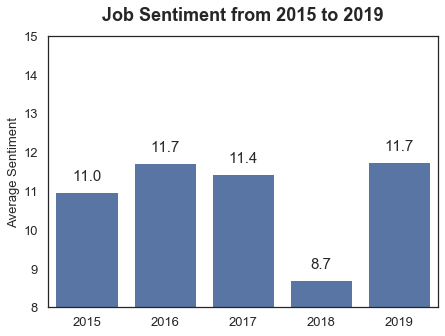

In [368]:
sns.set(rc={'figure.figsize':(7,5),"font.size":15,"axes.titlesize":18, "axes.labelsize":13, 'xtick.labelsize': 13, 'ytick.labelsize': 13},style="white")
ax = sns.barplot(x="Year", y="Average Sentiment", data=jobsent_df, color = "b").set_title('Job Sentiment from 2015 to 2019', weight='bold',pad = 15)
ax.axes.set_ylim([8, 15])
ax.axes.set_xlabel('')
for p in ax.axes.patches:
    height = p.get_height()
    ax.axes.text(p.get_x()+p.get_width()/2.,
            height + 0.3,
            '{:1.1f}'.format(height/1),
            ha="center") 

We observe that job sentiment stays relatively the same across the years, with a dip in 2018. Let's look at the most negative posts of 2018 to understand why.

In [288]:
job_2018.sort_values(by = "sentence_sentiment")

confession_id                                            content  \
13089        49337.0  Tip: If you find NUS spamming useless promotio...   
13106        49311.0  Well, I guess us NUS Science students are dupe...   
12345        50387.0  Nus business analytics is not about producing ...   
8483         56025.0  why do fass students pay similar school fees t...   
15684        45442.0  What was your gross monthly salary (and AWS, p...   
10891        52415.0  Has anyone been screwed over by GRO? Basically...   
8385         56197.0  I find that some of the CS students are quite ...   
13755        48334.0  The only reason i go cashless because.... i'm ...   
15085        46389.0  Are moe tuition grant sureties liable for liqu...   
15148        46290.0  If you know exactly where you had lost your va...   
10439        53077.0  Really envy those who can afford to go oversea...   
11560        51453.0  Is it not recommended that couples work in the...   
8668         55758.0  Aiyo fass degree, biz degree, engine degree. W...   
13426        48802.0  I'm looking for temp employment for the next 3...   
11071        52159.0  Does the drink store uncle at the air con cant...   
10381        53152.0  Anyone thinks the trays at the canteen in PGP ...   
12833        49689.0  How would you feel if your salary is lower tha...   
8846         55520.0  It is really irritating that everybody thinks ...   
11360        51747.0  I want to rent a locker in NUS utown by the pr...   
13558        48606.0  Is the western stall at techno edge halal cert...   
13149        49240.0  #49237 here's my side of the story. I'm not th...   
8178         56509.0  Have yall gotten the email to confirm that u h...   
15057        46432.0  Wtf NUS just sent me an SMS a minute to pay th...   
15528        45687.0  Does anyone know if the laksa yong tau foo sta...   
11565        51445.0  Anyone has the problem that can’t login to IVL...   
12217        50545.0  Does anyone know of any job out there that can...   
10873        52445.0  Sigh Y4 here and getting stressed out by all t...   
9364         54712.0  2008: Here's your welfare pack.\n2018: Let's m...   
12718        49851.0  why is it that a scientist that commit academi...   
11338        51783.0  hi just wondering how do we know if we have pa...   
...              ...                                                ...   
9533         54458.0  Anyone here has similar experiences as me? I h...   
11403        51678.0  I used to think nus is over priced. But recent...   
13013        49440.0  Just my 2 cents, if you're working at a semi p...   
8581         55887.0  Can anyone suggest something to do this holida...   
10199        53434.0  Anyone can advice on how much value a CS + app...   
15408        45867.0  #45855: Better to transfer earlier (y1-y2), ot...   
11768        51156.0  Are engineers poorly paid? I was going to appl...   
13231        49112.0  In view of Uber's exit and sell out to Grab, I...   
8395         56187.0  How true is it that the average CS grad earns ...   
13926        48113.0  Why don't MOE get graduate salary from IRAS in...   
8230         56422.0  [Advice for Grad School] (please admin post my...   
8162         56538.0  Hi, I'm a Science undergrad hoping to transfer...   
15596        45578.0  #45560 yes go for it. Young fresh meat is very...   
8270         56354.0  A gentle reminder to our freshies who have man...   
13033        49409.0  #49406\nAs a continuation of the post, I'm onl...   
11159        52029.0  Is 4.5k a low salary for a CS fresh graduate w...   
11382        51712.0  Currently in engineering now and really demora...   
15349        45947.0  Ever since after graduation, I have been stari...   
9368         54707.0  Is there anyone who work in a lab as a researc...   
14875        46678.0  I am an international student who recently cha...   
11555        51460.0  Is it worth it to pursue my passion in an indu...   
15421        45852.0  Anyone wen

It turns out that there is a lot of noise (many posts unrelated to finding jobs), as you can see below. 

In [289]:
job_2018.loc[job_2018["confession_id"]==56197]["content"].values

array(['I find that some of the CS students are quite arrogant and ignorant.....They keep suggesting that your job should be automated etc. when they know nuts about our fields.'],
      dtype=object)

In [290]:
job_2018.loc[job_2018["confession_id"]==49689]["content"].values

array(['How would you feel if your salary is lower than the 25th percentile in the graduate employment survey?'],
      dtype=object)

In [291]:
job_2019.sort_values(by = "sentence_sentiment")

confession_id                                            content  \
5793        60244.0  I attend every class and do every reading that...   
4827        61925.0  Maybe the reason why sg has low crime rates is...   
7001        58269.0  Being from a lower-income household, I cannot ...   
5368        60951.0                        What a April fools prank :(   
3351        64707.0  Can someone, who have been struggling with own...   
4281        63134.0  Has anyone failed SEP interviews because they ...   
6004        59885.0  To all my graduating peers, when do y'all star...   
7508        57531.0  As a ITE student , I think uni grads really un...   
1185        69029.0  First year student here and I really hate the ...   
4991        61597.0  I had a chat with some of my parents' colleagu...   
1163        69070.0  I’m looking for stories from seniors who took ...   
4362        63012.0  Can someone with really shaky hands do lab wor...   
3201        64977.0  Anyone who is overweight (say Bmi > 28) who co...   
3103        65137.0  My ex-colleague mentioned to me that our boss ...   
7963        56856.0  #56840: Maybe you can prove #56208 wrong by so...   
1971        67343.0  Hi Prof. Ben, given that your views on MComp C...   
2717        65828.0  You know your otaku life is over when typing "...   
7386        57695.0  Would it be useful to do an internship at a bi...   
4746        62215.0  NUS and the Police/AGC needs to change its sys...   
5510        60692.0  The short-sightedness of people complaining ab...   
3550        64354.0  I feel very aimless in life after graduating f...   
6067        59786.0  I have always aimed to get a second upper but ...   
6408        59252.0  Why do we study so hard in NUS to lose to some...   
3588        64289.0  Is it a waste of my degree if I become a Grab ...   
6763        58653.0  Anyone else hear that annoying high pitch soun...   
4908        61760.0  Hi, I'm looking at the graduate employment sur...   
5322        61017.0  So how is one supposed to have a social life h...   
6045        59823.0  To all the kids complaining about CS2030, u ha...   
1655        68000.0  Can someone explain why every accommodation at...   
3724        64081.0  Professor Ben Leong,\n\nDoes the CS or softwar...   
...             ...                                                ...   
3749        64036.0  #63975 response to  @Nigel Sim comments, it’s ...   
6704        58755.0  I was excited when I got a job offer of my dre...   
2648        65939.0  Do anyone know of good recommendable online co...   
2673        65907.0  Wish to ask is 2nd major important in terms of...   
3812        63923.0  Hi guys,\n\nAs a fresh grad entering the workf...   
6964        58337.0  I just want to show my appreciation to this pl...   
5959        59954.0  Dear Prof. Ben, honestly, roughly how many peo...   
7610        57375.0  I am a Y1 student currently taking PL1101E but...   
6715        58742.0  NUS is no longer best in Asia-Pac... how am I ...   
6965        58336.0  hello anyone interested in playing casual ulti...   
1541        68270.0  Hi just got an engineering job but somehow fee...   
1923        67453.0           Winning TOTO has higher chance than this   
2964        65396.0  What are some high-paying jobs for the best FA...   
1630        68061.0  I wonder if Prof Ben will start his own MOOC i...   
3202        64979.0  Hi, anyone can share more insights about the d...   
833         69733.0  Boy in air force t-shirt who alighted at Centr...   
4447        62877.0  Im an international student here studying CS, ...   
5581        60583.0  I would like to know which are the best tech c...   
6323        59420.0  Is civil servant or private sector path better...   
70          71386.0  I need some advice; should i quit my job if i'...   
5370        60946.0  Lots or CS students, alumni and IT people seem...   
5957        59959.0  Not quite sure how intelligent students of ‘th...   
635       

What we are interested in are posts like this:

In [292]:
job_2019.loc[job_2019["confession_id"]==61760]["content"].values

array(["Hi, I'm looking at the graduate employment survey and I was wondering why some people are unable to find a job within 6 months. Is it because of bad CAP? My grades arent good and I'm afraid I'll be unemployed too :("],
      dtype=object)

Therefore, we shall refine our analysis by filtering our dataset further. For instance, we will identify posts that contain "find job" or "secure employment"

In [293]:
job_2019_find = job_2019.copy()
find_19 = job_2019_find["content"].str.contains("find")
found_19 = job_2019_find["content"].str.contains("found")
secure_19 = job_2019_find["content"].str.contains("secure")
employ_19 = job_2019_find["content"].str.contains("employ")
job_19 = job_2019_find["content"].str.contains("job")


job_2019_find["contains_find"] = (find_19|found_19|secure_19) & (job_19|employ_19)  #returns boolean if content string fulfills condition
findjob_2019 = job_2019_find.loc[job_2019_find["contains_find"]==True]              #add as new column to dataframe

In [294]:
#Sentiment values of our filtered dataset
findjob_2019["sentence_sentiment"].describe()

count    126.000000
mean       0.104352
std        0.196190
min       -0.397200
25%        0.005350
50%        0.117150
75%        0.191475
max        0.919600
Name: sentence_sentiment, dtype: float64

In [295]:
#it is likely that Vader sentiment misclassifies some negative posts as positive. So we will look at just negative sentiments and how negative it is
findjob_2019.loc[findjob_2019["sentence_sentiment"]<= 0]["sentence_sentiment"].describe()

count    31.000000
mean     -0.139565
std       0.107118
min      -0.397200
25%      -0.193200
50%      -0.137800
75%      -0.043200
max      -0.000100
Name: sentence_sentiment, dtype: float64

In [296]:
#repeat for 2017. We will skip 2018 since the sample size is too small
job_2017_find = job_2017.copy()
find_17 = job_2017_find["content"].str.contains("find")
found_17 = job_2017_find["content"].str.contains("found")
secure_17 = job_2017_find["content"].str.contains("secure")
employ_17 = job_2017_find["content"].str.contains("employ")
job_17 = job_2017_find["content"].str.contains("job")


job_2017_find["contains_find"] = (find_17|found_17|secure_17) & (job_17|employ_17)
findjob_2017 = job_2017_find.loc[job_2017_find["contains_find"]==True]

In [297]:
findjob_2017["sentence_sentiment"].describe()

count    81.000000
mean      0.103048
std       0.191858
min      -0.331400
25%      -0.021700
50%       0.093400
75%       0.230000
max       0.616500
Name: sentence_sentiment, dtype: float64

In [298]:
#Just looking at negative posts, how negative it is?
findjob_2017.loc[findjob_2017["sentence_sentiment"]<= 0]["sentence_sentiment"].describe()

count    25.000000
mean     -0.107456
std       0.093859
min      -0.331400
25%      -0.134800
50%      -0.089000
75%      -0.034600
max      -0.008600
Name: sentence_sentiment, dtype: float64

In [299]:
#repeat for 2016
job_2016_find = job_2016.copy()
find_16 = job_2016_find["content"].str.contains("find")
found_16 = job_2016_find["content"].str.contains("found")
secure_16 = job_2016_find["content"].str.contains("secure")
employ_16 = job_2016_find["content"].str.contains("employ")
job_16 = job_2016_find["content"].str.contains("job")


job_2016_find["contains_find"] = (find_16|found_16|secure_16) & (job_16|employ_16)
findjob_2016 = job_2016_find.loc[job_2016_find["contains_find"]==True]

In [300]:
findjob_2016["sentence_sentiment"].describe()

count    88.000000
mean      0.117320
std       0.132604
min      -0.150100
25%       0.018375
50%       0.111250
75%       0.215025
max       0.502400
Name: sentence_sentiment, dtype: float64

In [301]:
findjob_2016.loc[findjob_2016["sentence_sentiment"]<= 0]["sentence_sentiment"].describe()

count    16.000000
mean     -0.059963
std       0.051920
min      -0.150100
25%      -0.096100
50%      -0.053100
75%      -0.014800
max       0.000000
Name: sentence_sentiment, dtype: float64

In [302]:
#repeat for 2015
job_2015_find = job_2015.copy()
find_15 = job_2015_find["content"].str.contains("find")
found_15 = job_2015_find["content"].str.contains("found")
secure_15 = job_2015_find["content"].str.contains("secure")
employ_15 = job_2015_find["content"].str.contains("employ")
job_15 = job_2015_find["content"].str.contains("job")


job_2015_find["contains_find"] = (find_15|found_15|secure_15) & (job_15|employ_15)
findjob_2015 = job_2015_find.loc[job_2015_find["contains_find"]==True]

In [303]:
findjob_2015["sentence_sentiment"].describe()

count    30.000000
mean      0.137190
std       0.157999
min      -0.146900
25%       0.018125
50%       0.153000
75%       0.252025
max       0.379100
Name: sentence_sentiment, dtype: float64

In [304]:
findjob_2015.loc[findjob_2015["sentence_sentiment"]<= 0]["sentence_sentiment"].describe()

count    7.000000
mean    -0.086957
std      0.051269
min     -0.146900
25%     -0.127100
50%     -0.091100
75%     -0.050750
max     -0.015000
Name: sentence_sentiment, dtype: float64

In [305]:
findjob_2019_mean = findjob_2019.loc[findjob_2019["sentence_sentiment"]<= 0]["sentence_sentiment"].mean()
findjob_2017_mean = findjob_2017.loc[findjob_2017["sentence_sentiment"]<= 0]["sentence_sentiment"].mean()
findjob_2016_mean = findjob_2016.loc[findjob_2016["sentence_sentiment"]<= 0]["sentence_sentiment"].mean()
findjob_2015_mean = findjob_2015.loc[findjob_2015["sentence_sentiment"]<= 0]["sentence_sentiment"].mean()

findjobsent_df = pd.DataFrame()
findjobsent_df["Year"] = "2015", "2016", "2017", "2019"
findjobsent_df.set_index("Year")
findjobsent_df["Average Sentiment"] = findjob_2015_mean, findjob_2016_mean, findjob_2017_mean, findjob_2019_mean

In [306]:
findjobsent_df["Average Sentiment"] = findjobsent_df["Average Sentiment"] * 100

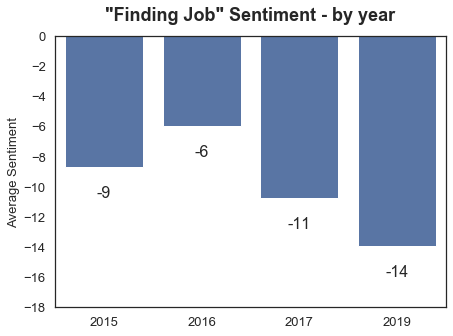

In [374]:
sns.set(rc={'figure.figsize':(7,5),"font.size":16,"axes.titlesize":18, "axes.labelsize":13, 'xtick.labelsize': 13, 'ytick.labelsize': 13},style="white")
ax = sns.barplot(x="Year", y="Average Sentiment", data=findjobsent_df, color = "b").set_title('"Finding Job" Sentiment - by year', weight='bold', pad = 15)
ax.axes.set_ylim([-18, 0])
ax.axes.set_xlabel('')
for p in ax.axes.patches:
    height = p.get_height()
    ax.axes.text(p.get_x()+p.get_width()/2.,
            height - 2,
            '{:1.0f}'.format(height/1),
            ha="center") 

*2018 was excluded due to low sample size

*Sentiments only include negative sentiments

Here, we can see that negative sentiments become more negative generally across the years. Like what we hypothesized, 2019 has the most negative sentiment because of the poor job market.